<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [443]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import glob

import argparse
from pathlib import Path
import os

from veloce_luminosa_reduction import config

import matplotlib.pyplot as plt
from astropy.io import fits

# from veloce_luminosa_reduction.plotting import plot_ccd_imshow, create_rainbow_colormap, create_transparent_greyscale_colormap
# from veloce_luminosa_reduction.utils import identify_calibration_and_science_runs, match_month_to_date, read_veloce_fits_image_and_metadata, polynomial_function, radial_velocity_shift, interpolate_spectrum
from veloce_luminosa_reduction.utils import polynomial_function
# from veloce_luminosa_reduction.reduction import substract_overscan, extract_initial_order_ranges_and_coeffs
from veloce_luminosa_reduction.calibration import get_wavelength_coeffs_from_vdarc
# from veloce_luminosa_reduction.korg_synthesis import calculate_synthetic_korg_spectrum
# from veloce_luminosa_reduction.post_processing import degrade_resolution_with_uncertainty, interpolate_orders_and_merge, coadd_spectra

# import time
import numpy as np
# from numpy.polynomial.chebyshev import Chebyshev
from scipy.signal import medfilt, find_peaks
# from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
# from astropy.table import Table
# from astropy.time import Time
# from astropy.coordinates import SkyCoord, EarthLocation
# import astropy.units as u
# SSO = EarthLocation.of_site('Siding Spring Observatory')

In [444]:
initial_wavelength_coeffs = get_wavelength_coeffs_from_vdarc()

In [445]:
config.date = '240219'

In [446]:
path = config.working_directory+'reduced_data/'+config.date+'/minimal_spectra/'
print(path, len(path))
science_objects = [x[79:] for x in glob.glob(path+'*')]
science_objects

/Users/buder/git/veloce_luminosa_reduction/reduced_data/240219/minimal_spectra/ 79


['HIP57757',
 'HIP73184',
 'HIP37664',
 'HIP71681',
 'HIP67459',
 'HIP63608',
 'HIP50887',
 'HIP65721',
 'HIP74975',
 'HIP71683',
 'HIP69673',
 'HIP56127',
 'HIP47431']

In [447]:
def fourth_order(xdata, *coeffs):
    c0, c1, c2, c3, c4 = coeffs
    return(c0 + c1 * (xdata-2064) + c2 * (xdata-2064)**2 + c3 * (xdata-2064)**3 + c4 * (xdata-2064)**4)

(12, 2)


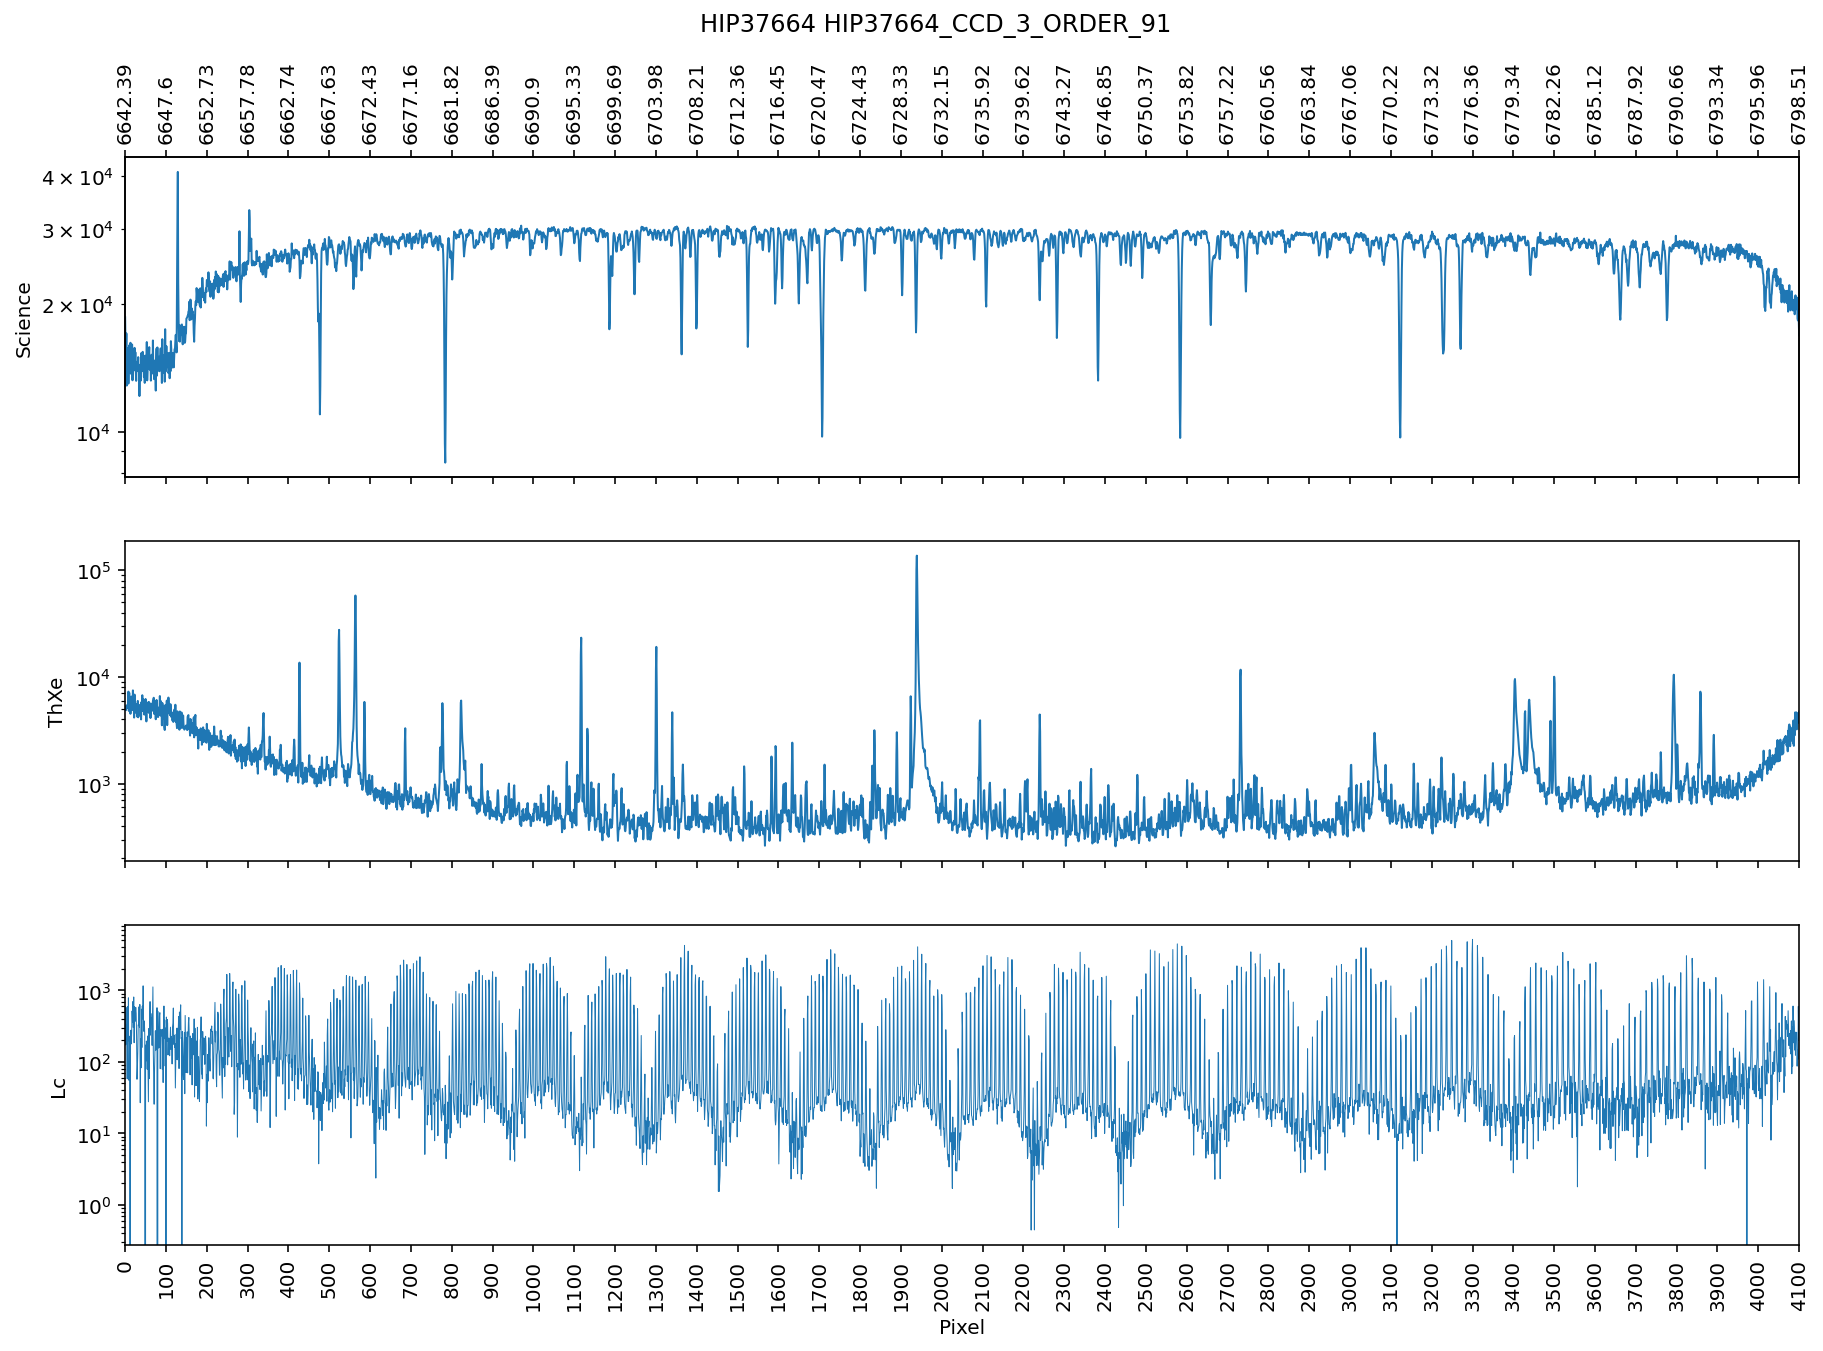

(19, 2)


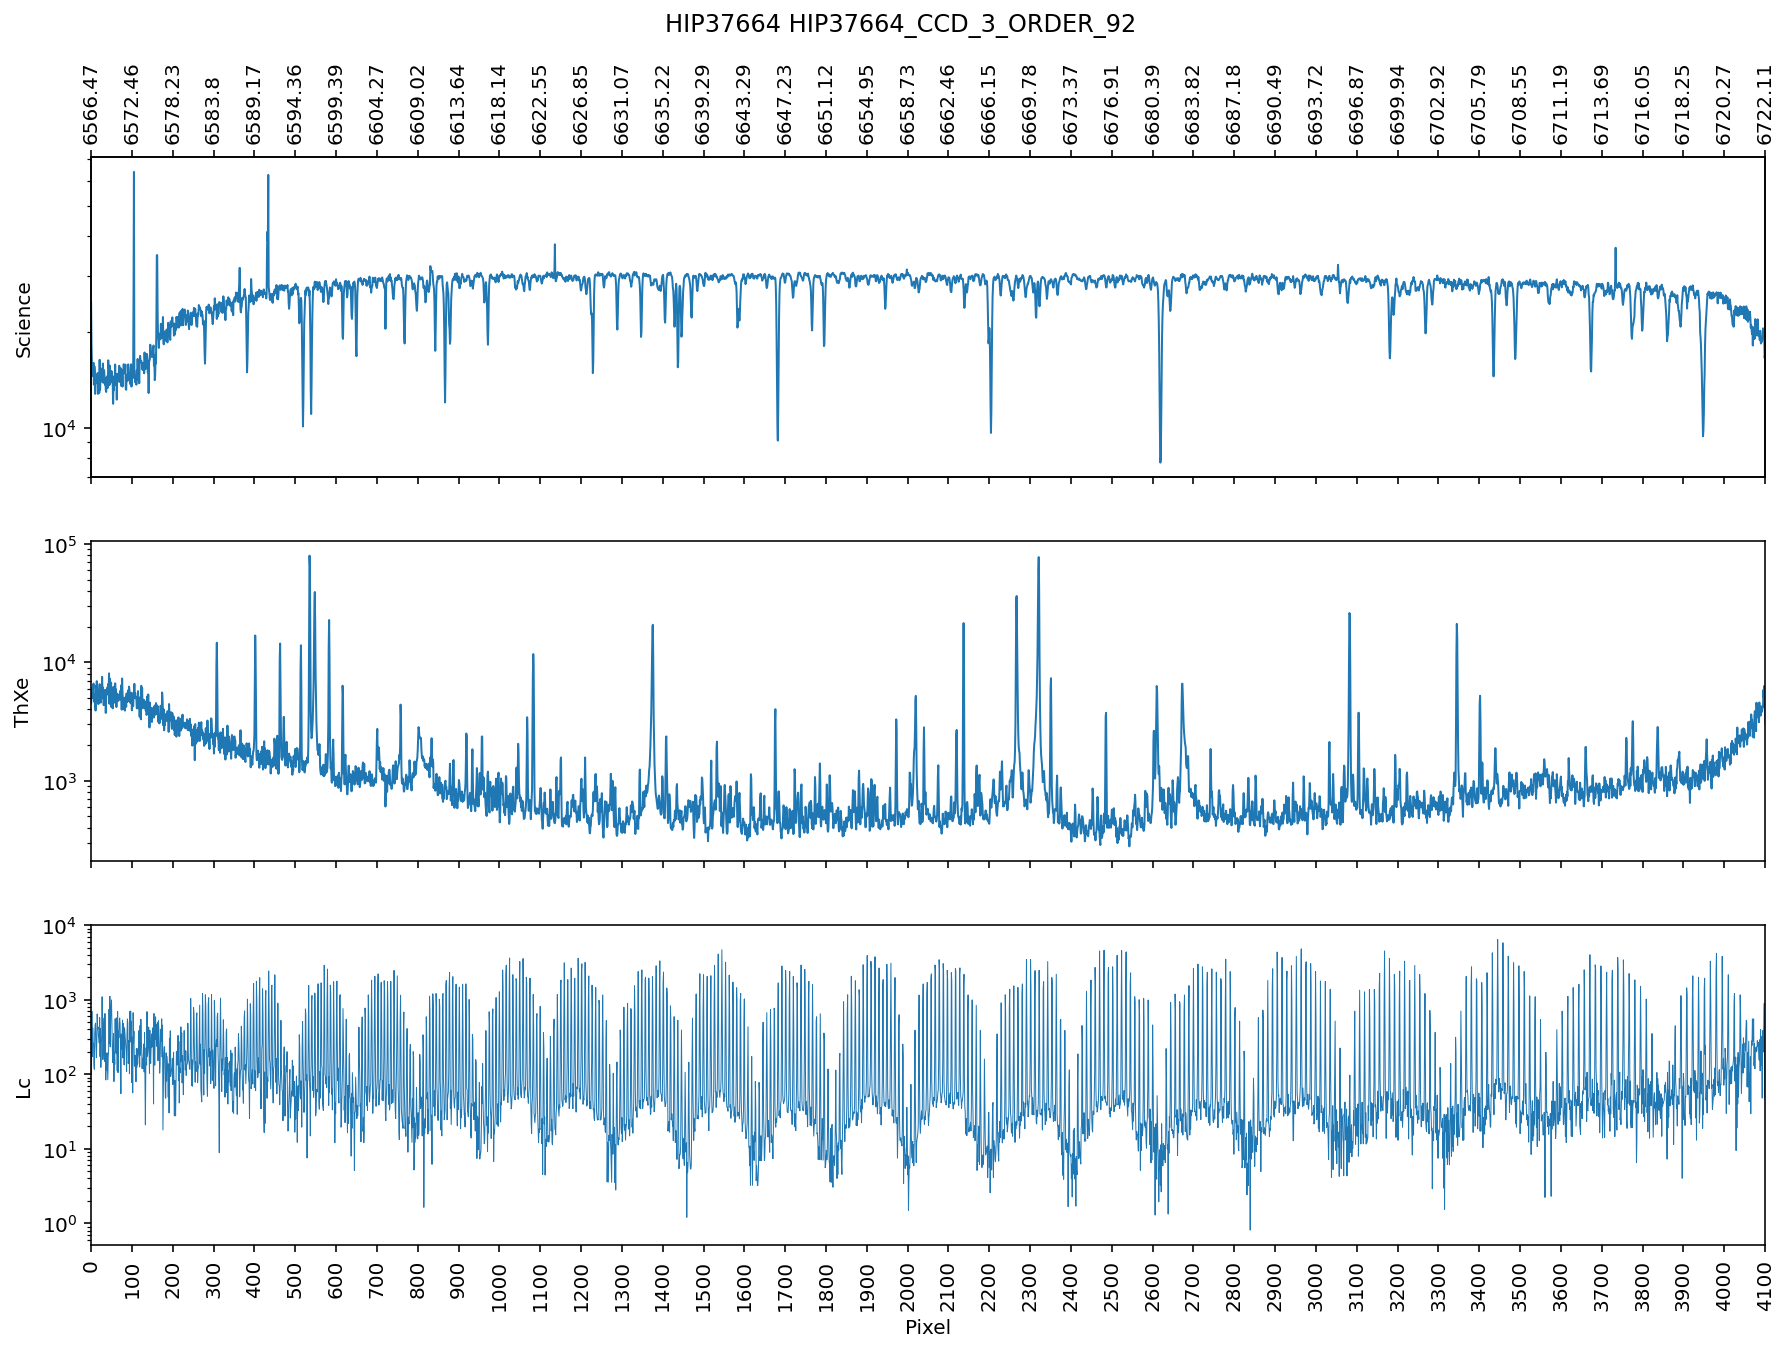

(19, 2)


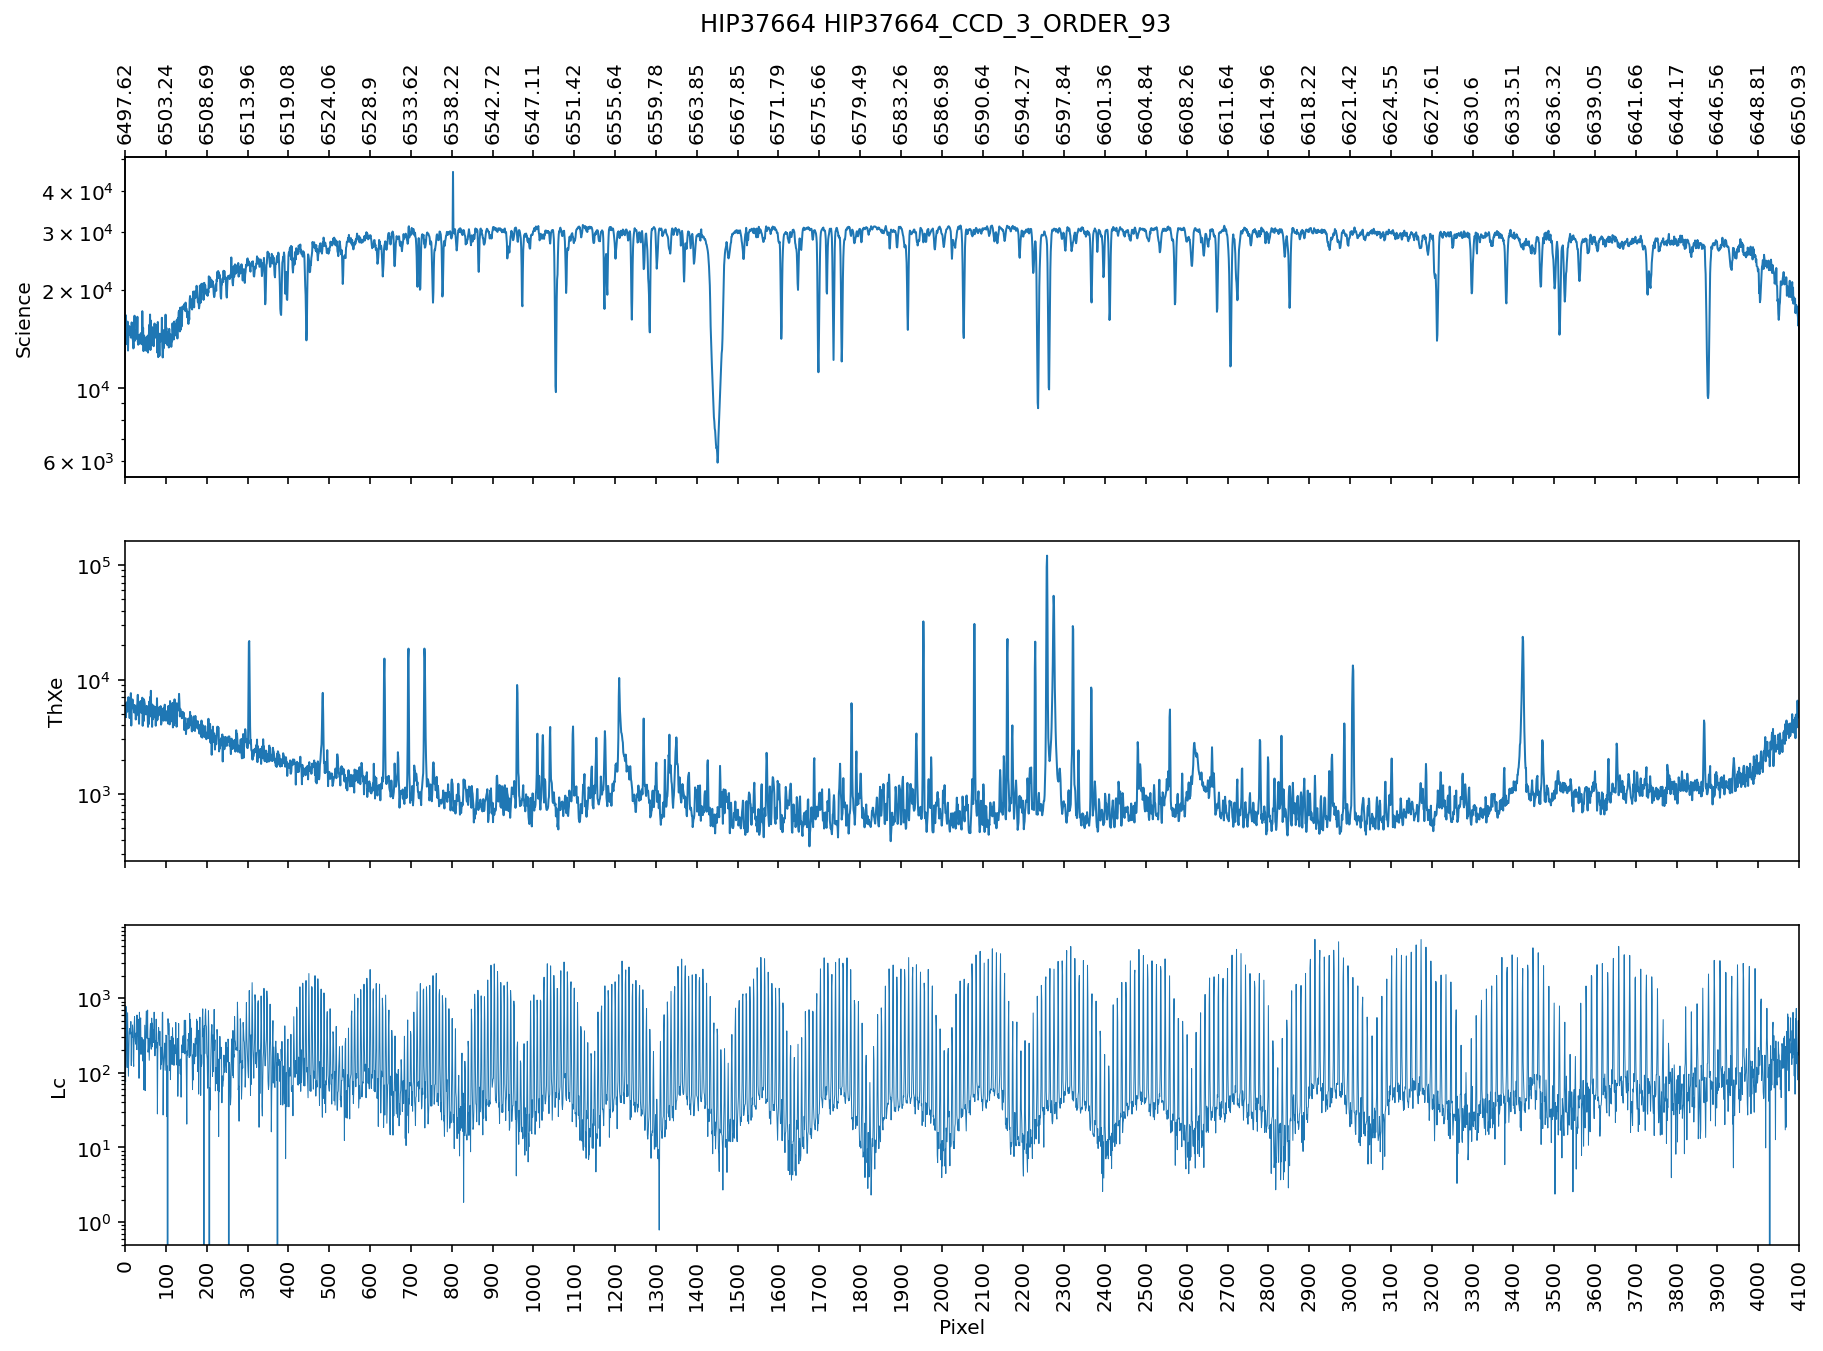

In [466]:
science_objects = ['HIP37664']

for science_object in science_objects:
    
    with fits.open(path+science_object+'/minimal_'+science_object+'.fits', mode='update') as file:

        for order in range(1,len(file)):

            if file[order].header['EXTNAME'] in [
                science_object+'_CCD_3_ORDER_91',
                science_object+'_CCD_3_ORDER_92',
                science_object+'_CCD_3_ORDER_93'
            ]:

                wavelength_coefficients[order_name] = np.array(np.loadtxt('../veloce_luminosa_reduction/fixed_arc_positions/'+file[order].header['EXTNAME'].lower()[len(science_object)+1:]+'_px_wl.txt'))

                print(np.shape(wavelength_coefficients[order_name]))
                
                fourth_order_coeffs, x = curve_fit(fourth_order,
                    wavelength_coefficients[order_name][:,0],
                    wavelength_coefficients[order_name][:,1],
                    p0 = [np.median(wavelength_coefficients[order_name][:,1]), 0.05, 0.0, 0.0, 0.0]
                )
                wavelength_from_pixels = fourth_order(np.arange(len(file[order].data['WAVE'])),*fourth_order_coeffs)
                file[order].data['WAVE'] = wavelength_from_pixels*10.

                f, gs = plt.subplots(3,1,figsize=(15,10),sharex=True)
                f.suptitle(science_object+' '+file[order].header['EXTNAME'])

                ax = gs[0]
                ax.plot(file[order].data['SCIENCE']/file[order].data['FLAT'], lw=1)
                ax.set_yscale('log')
                ax.set_ylabel('Science')

                ticks = np.arange(0,4128,100)
                ax.set_xticks(ticks,labels=ticks,rotation=90)
                ax.set_xlim(ticks[0],ticks[-1])   
                ax2 = ax.twiny()
                ax2.set_xticks(ticks-ticks[0])
                ax2.set_xticklabels(np.round(wavelength_from_pixels[ticks]*10,2),rotation=90)

                ax = gs[1]
                ax.plot(file[order].data['THXE']/file[order].data['FLAT'], lw=1)
                ax.set_yscale('log')
                ax.set_ylabel('ThXe')

                ax = gs[2]
                ax.plot(file[order].data['LC']/file[order].data['FLAT'], lw=0.5)
                ax.set_yscale('log')
                ax.set_ylabel('Lc')
                ax.set_xlabel('Pixel')
                ax.set_xticks(ticks,labels=ticks,rotation=90)

                wavelength = file[order].data['WAVE']
                science = file[order].data['SCIENCE']/file[order].data['FLAT']
                thxe = file[order].data['THXE']/file[order].data['FLAT']
                lc = file[order].data['LC']/file[order].data['FLAT']

                plt.show()
                plt.close()

    file.close()

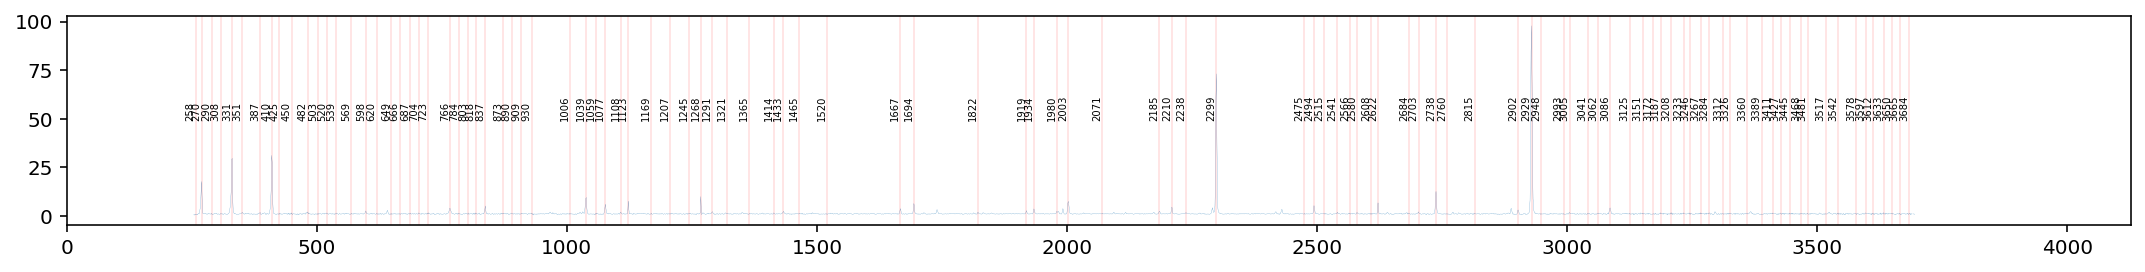

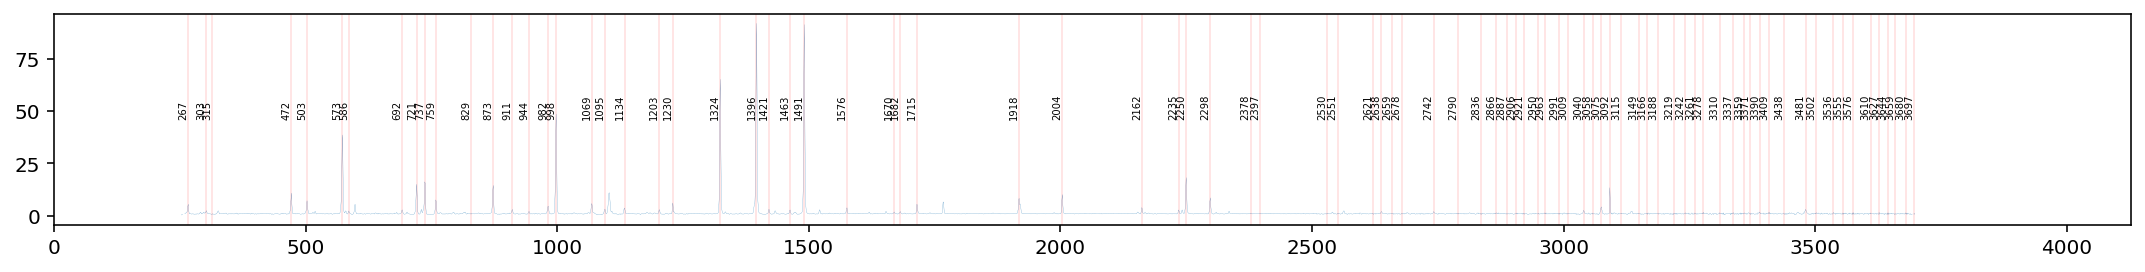

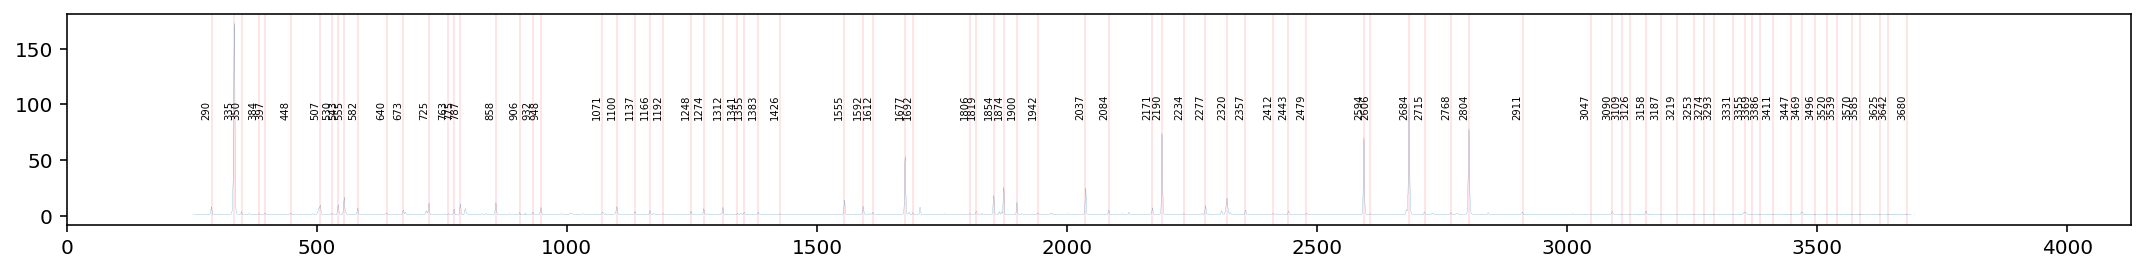

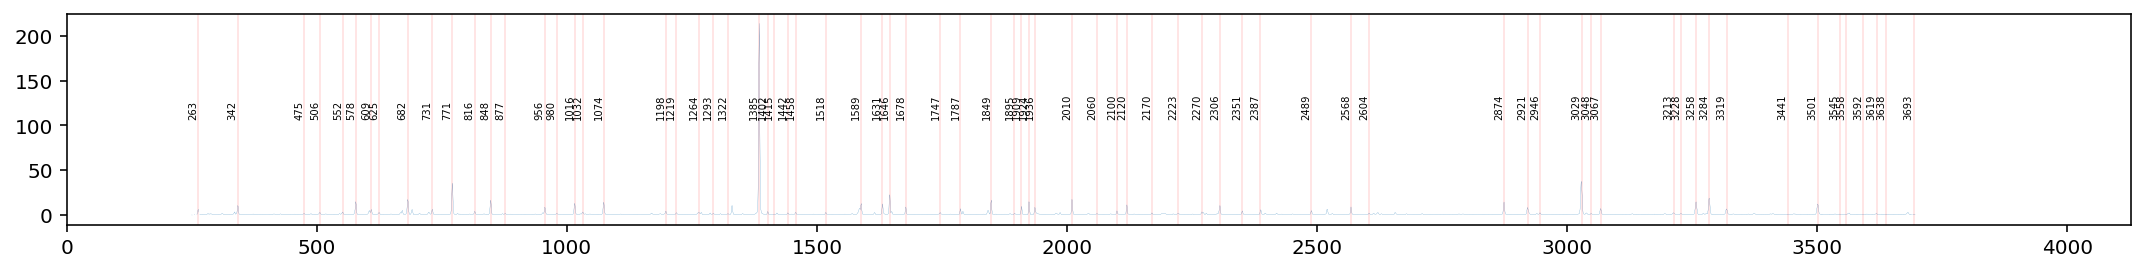

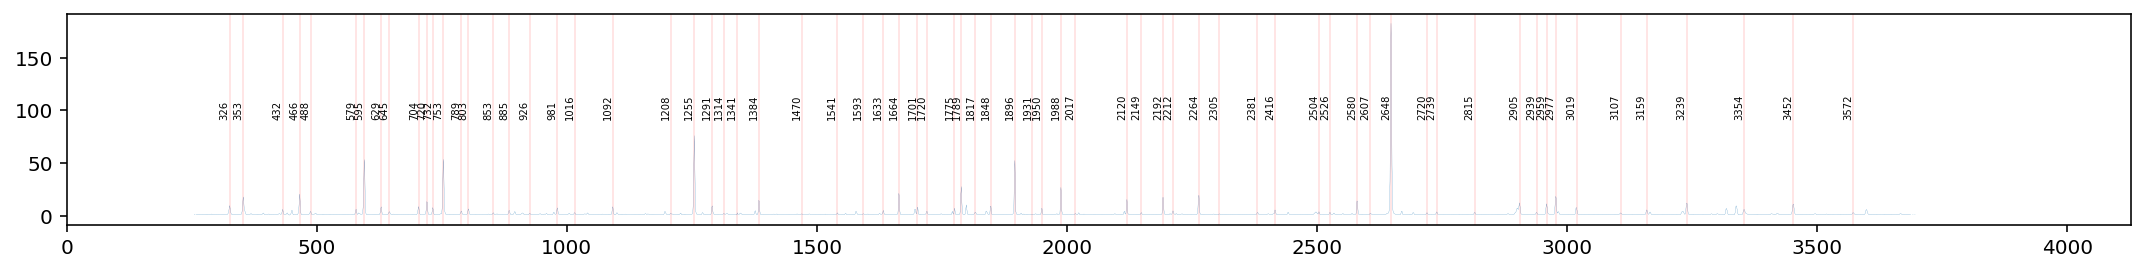

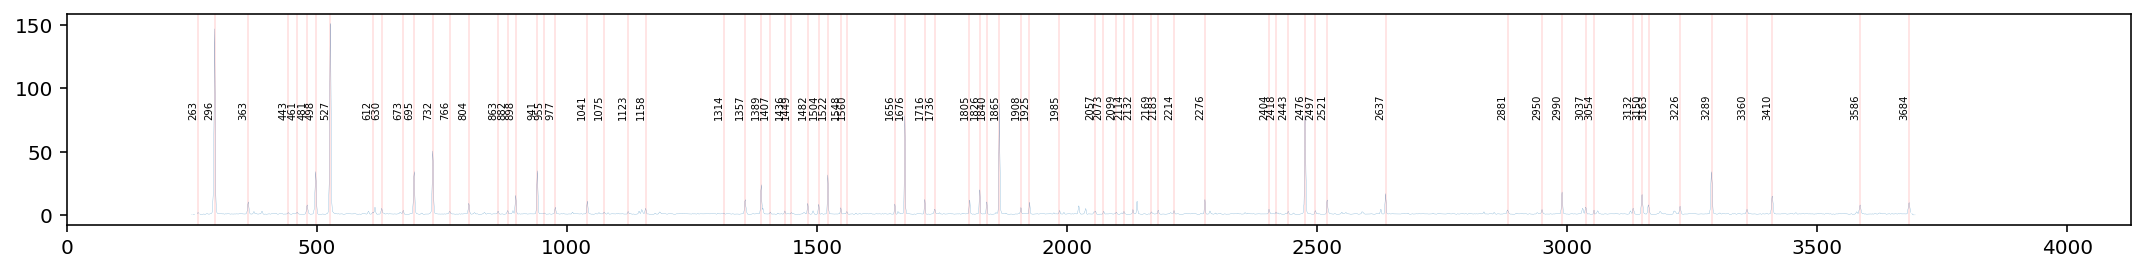

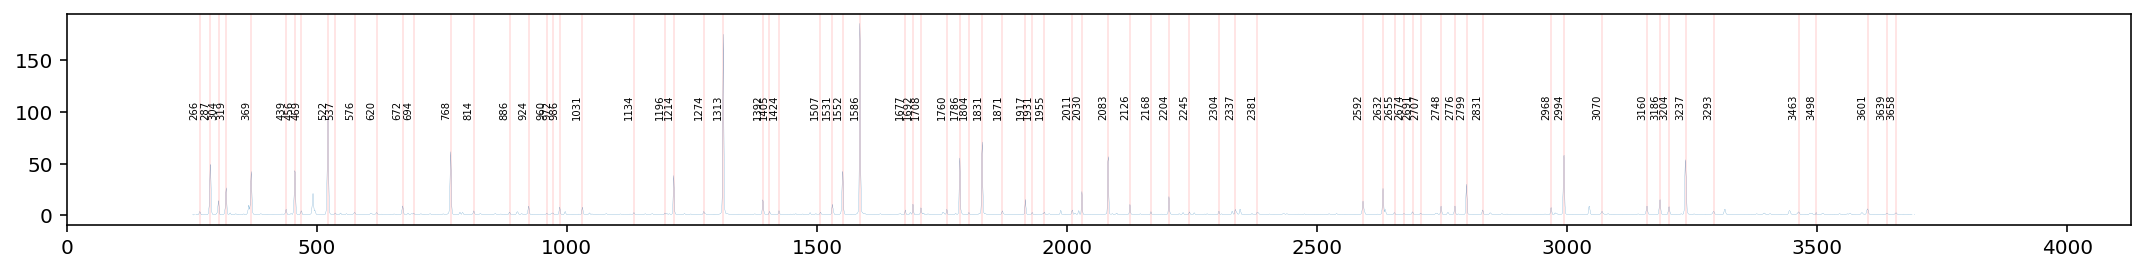

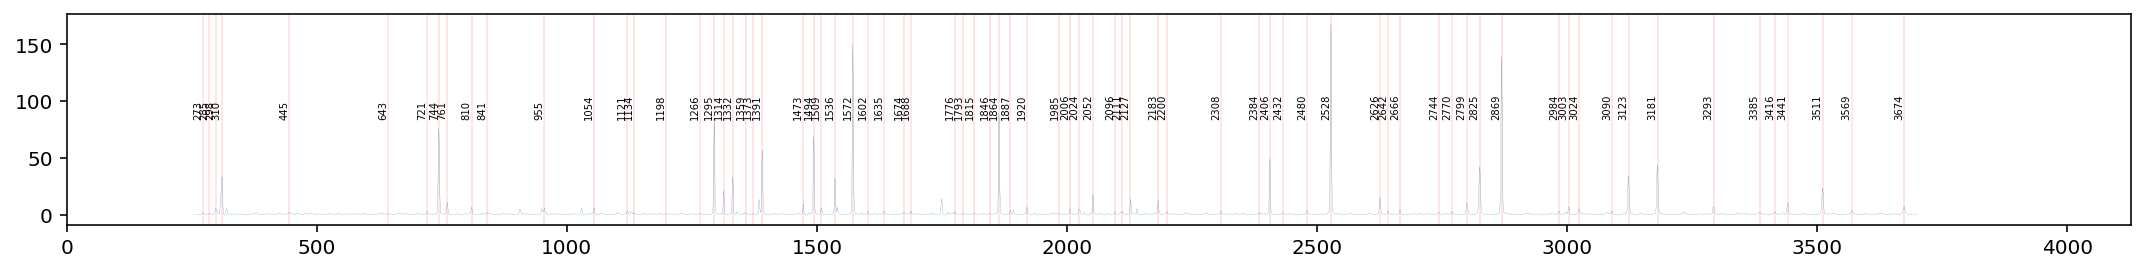

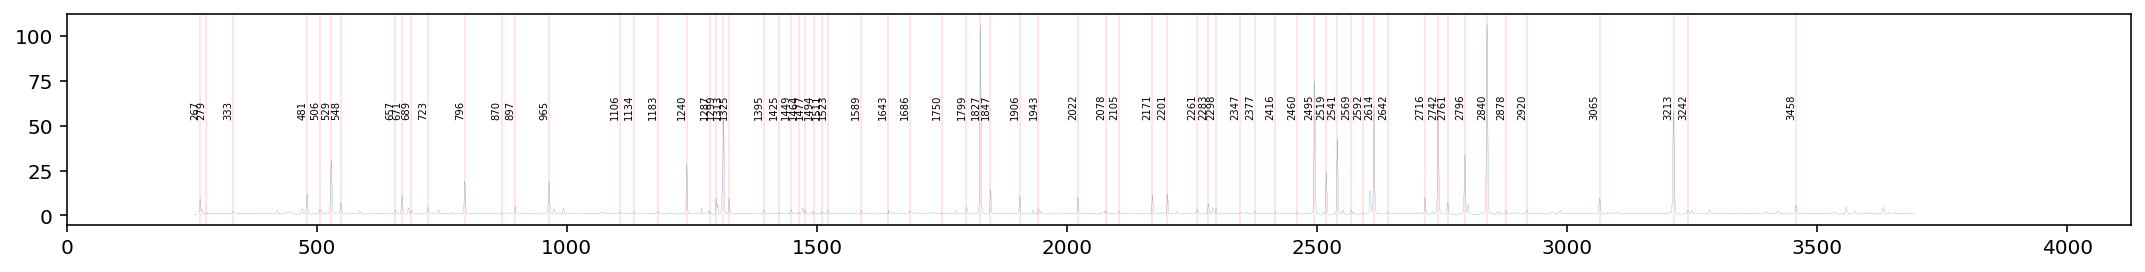

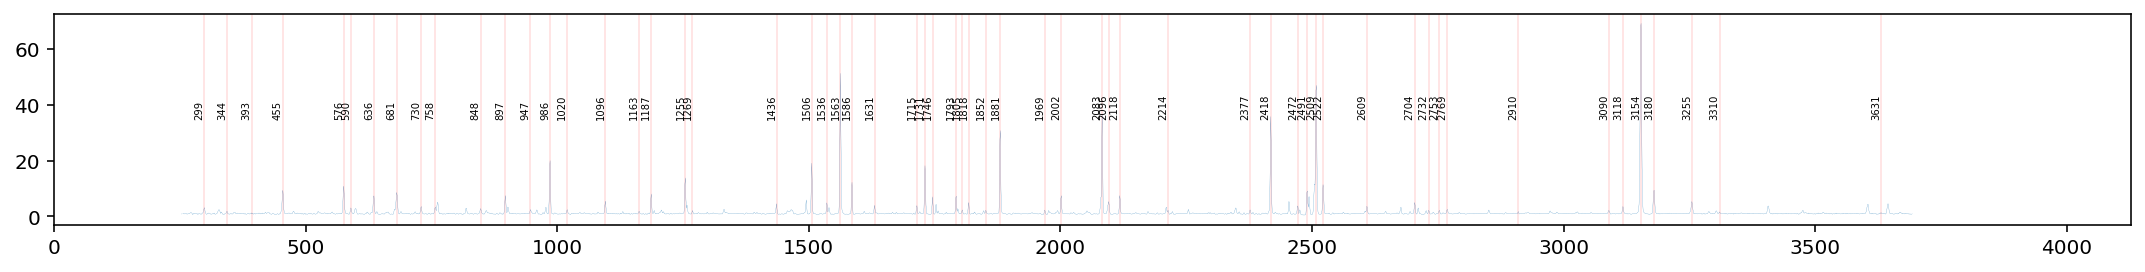

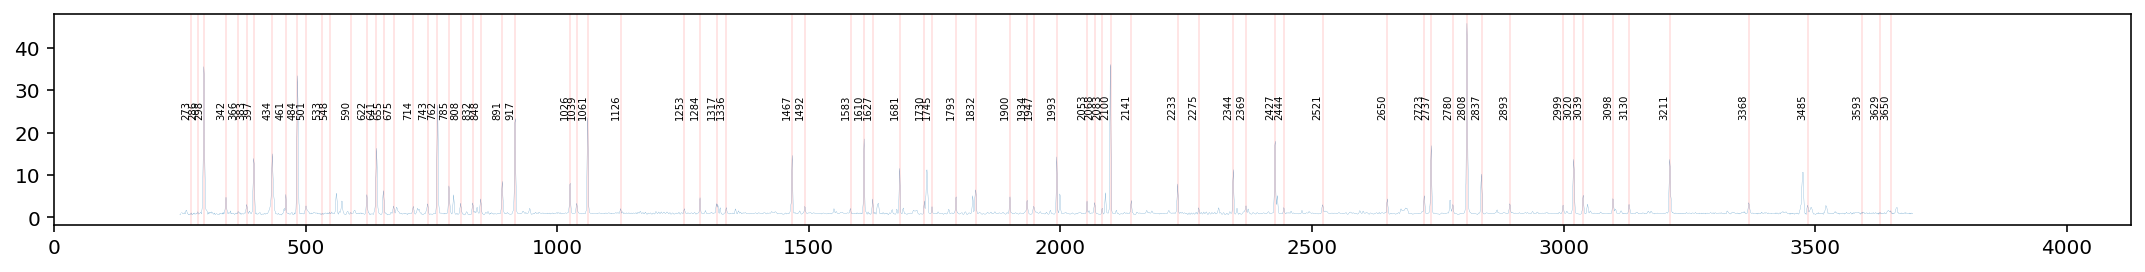

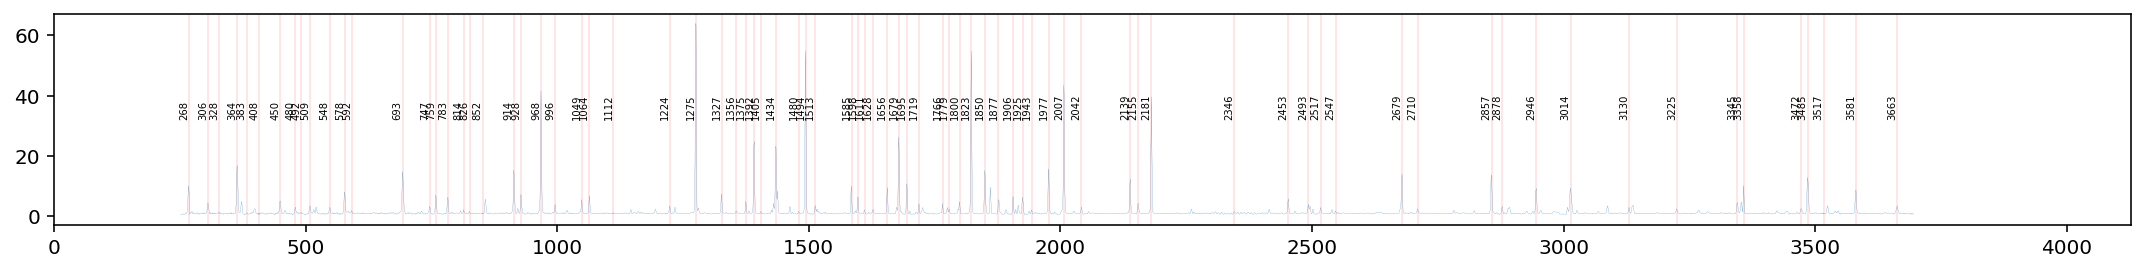

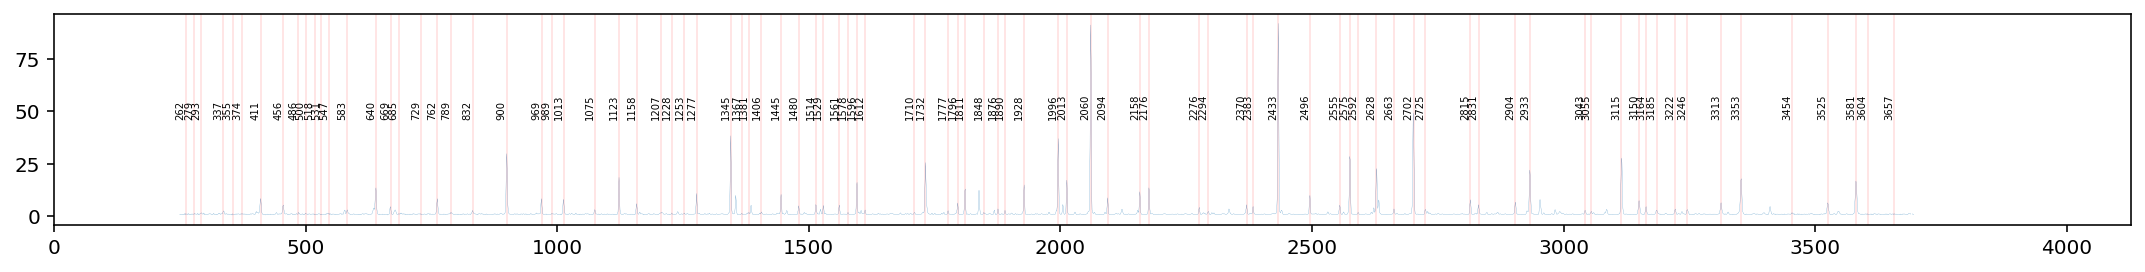

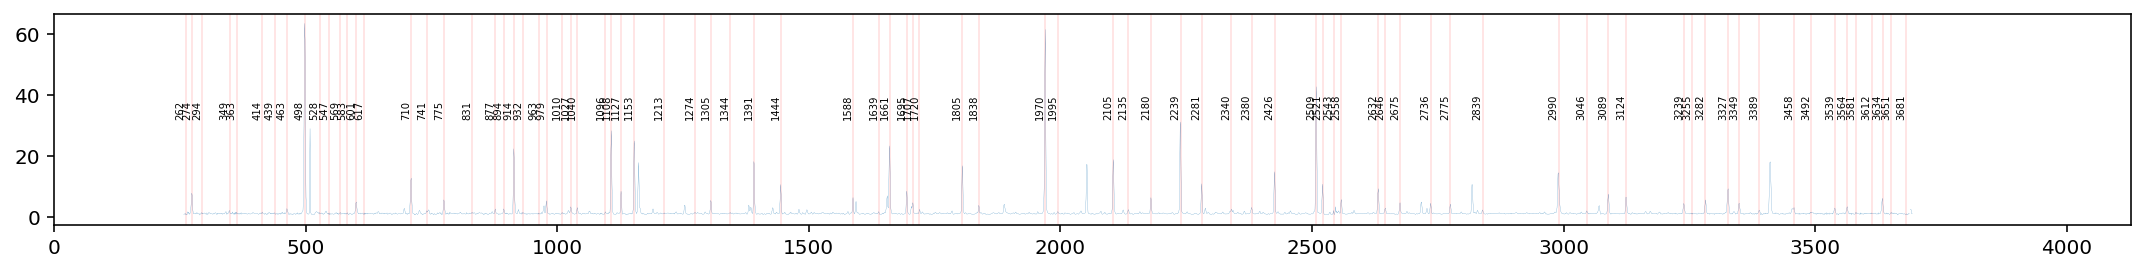

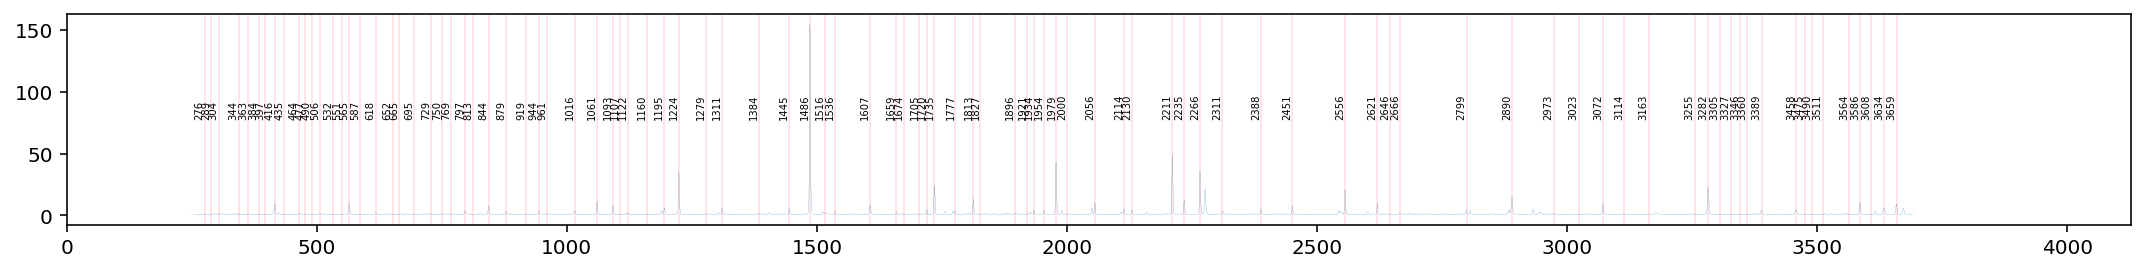

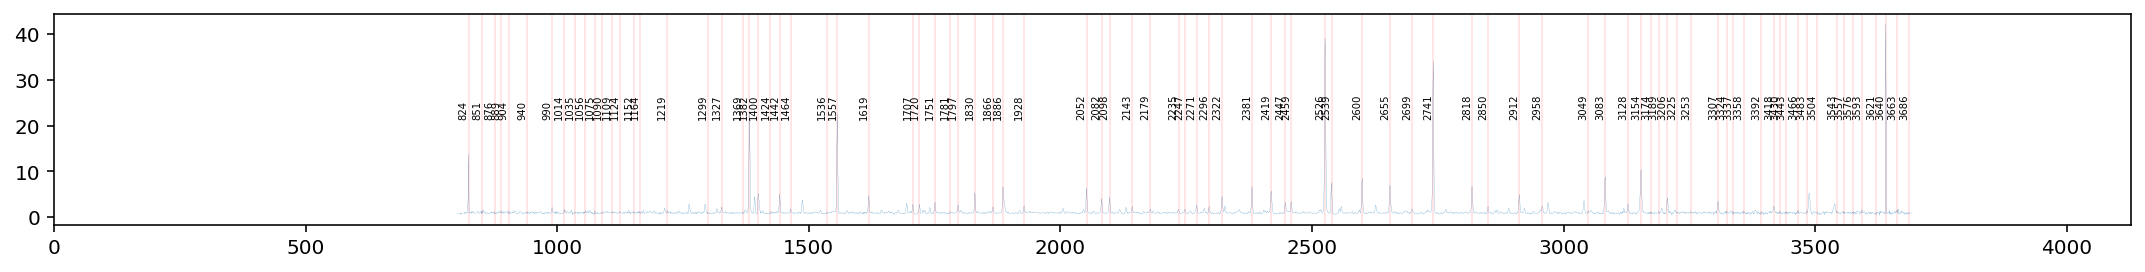

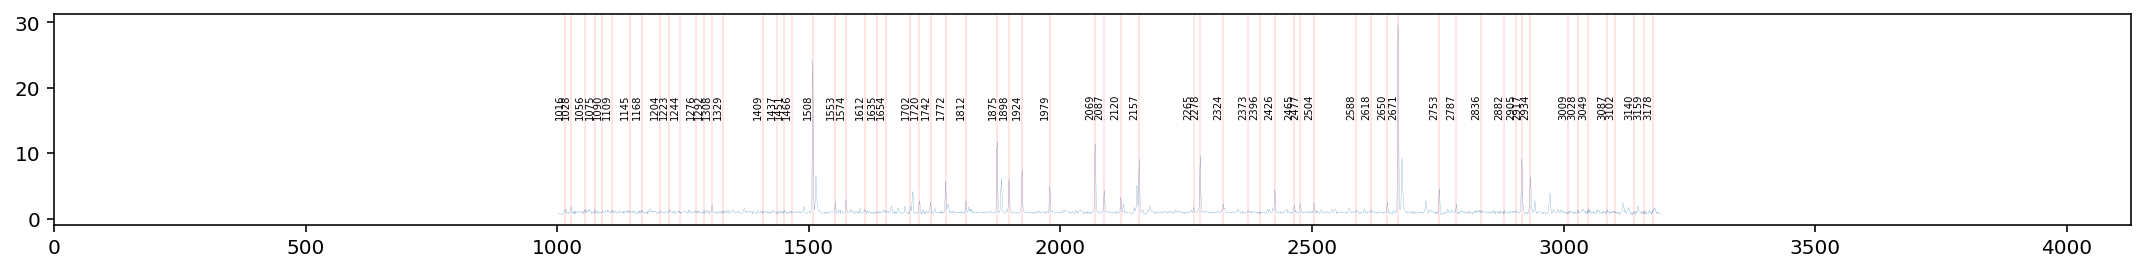

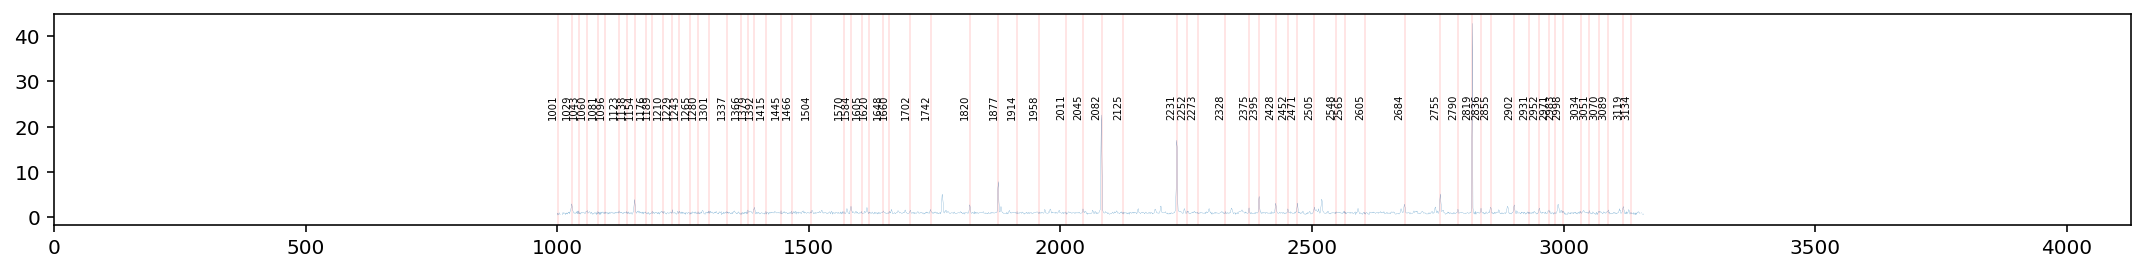

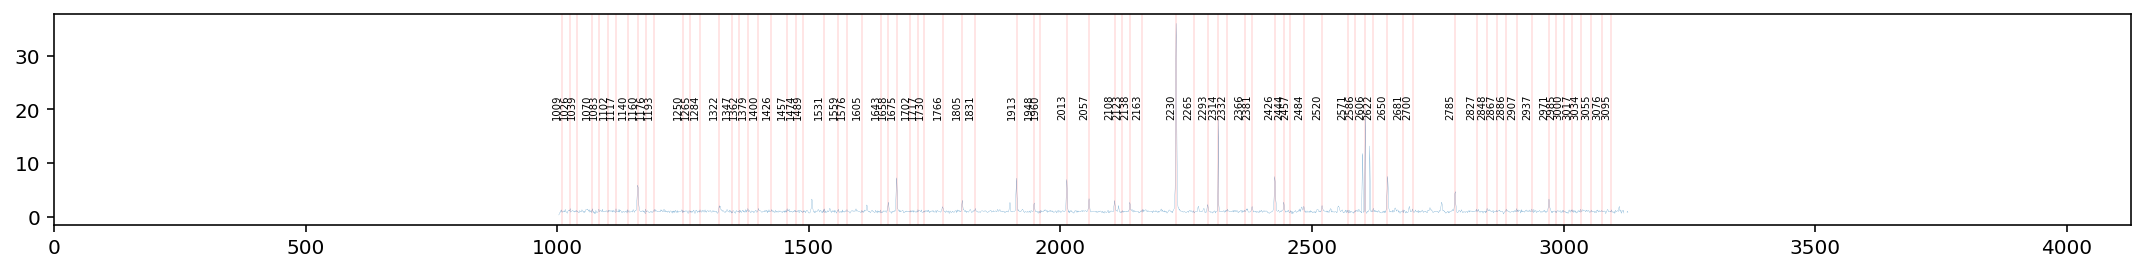

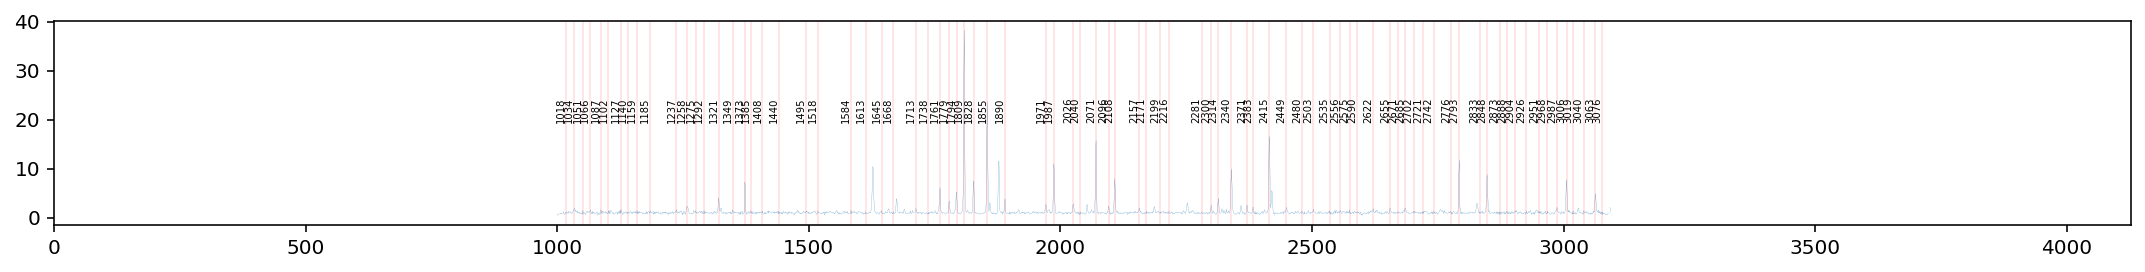

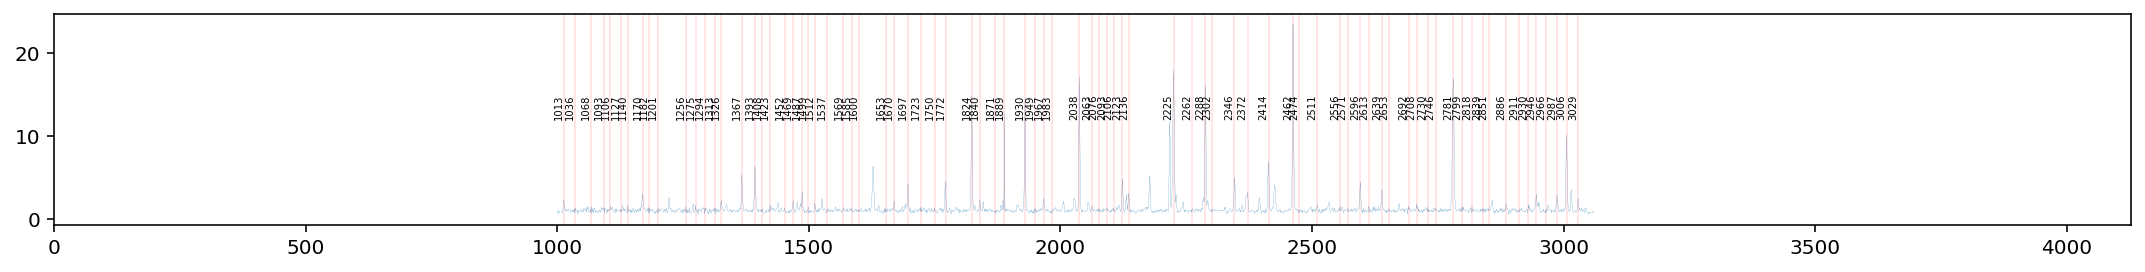

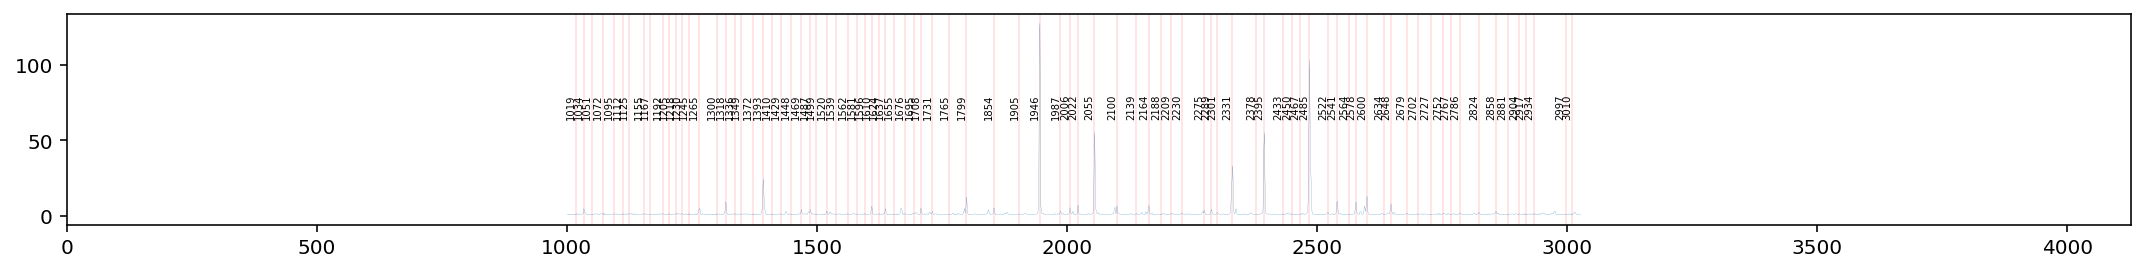

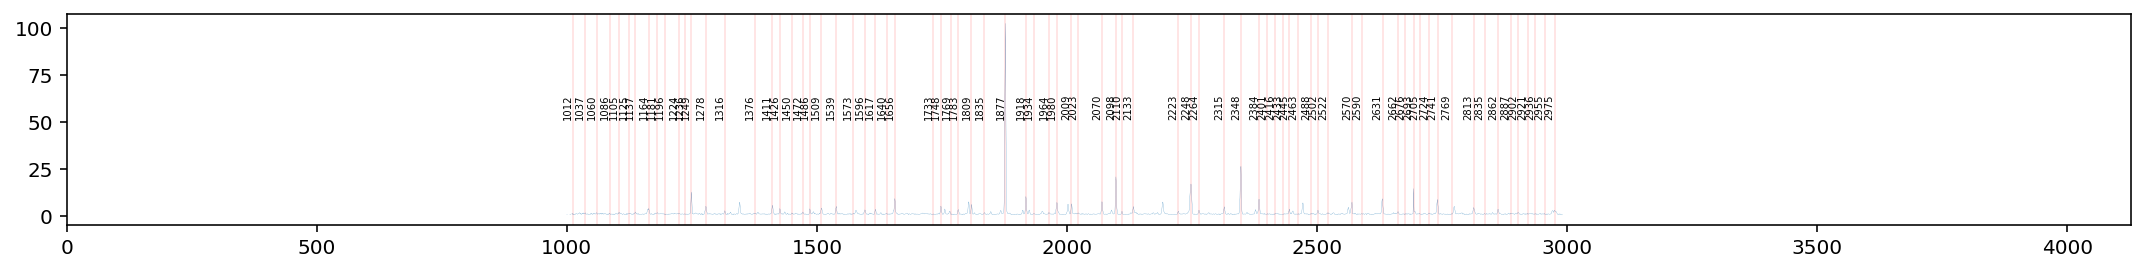

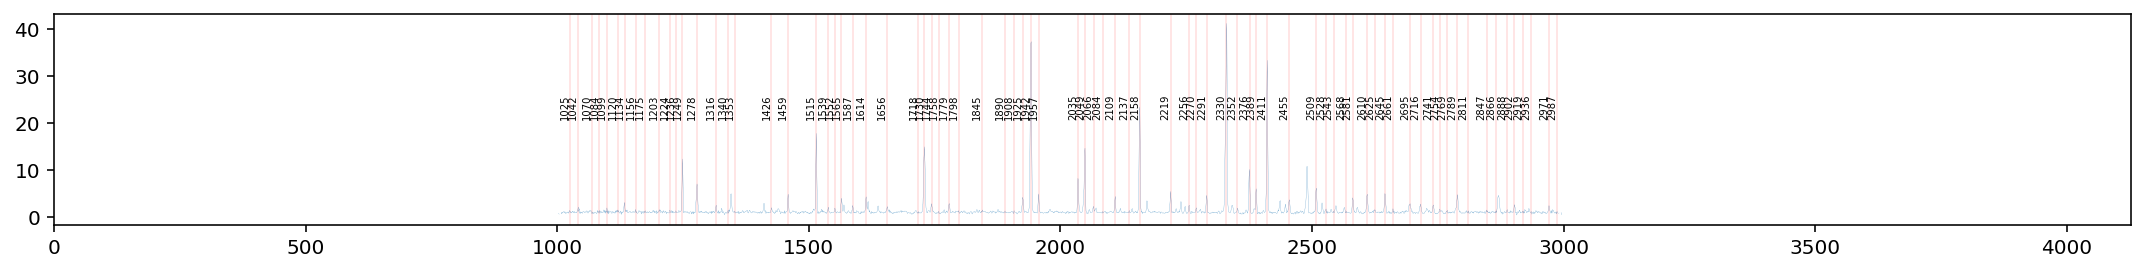

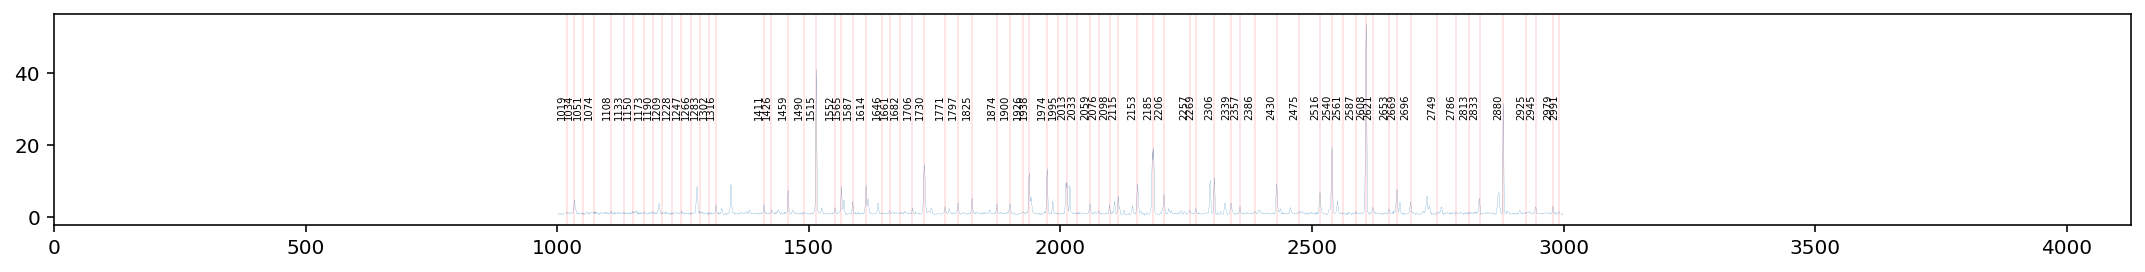

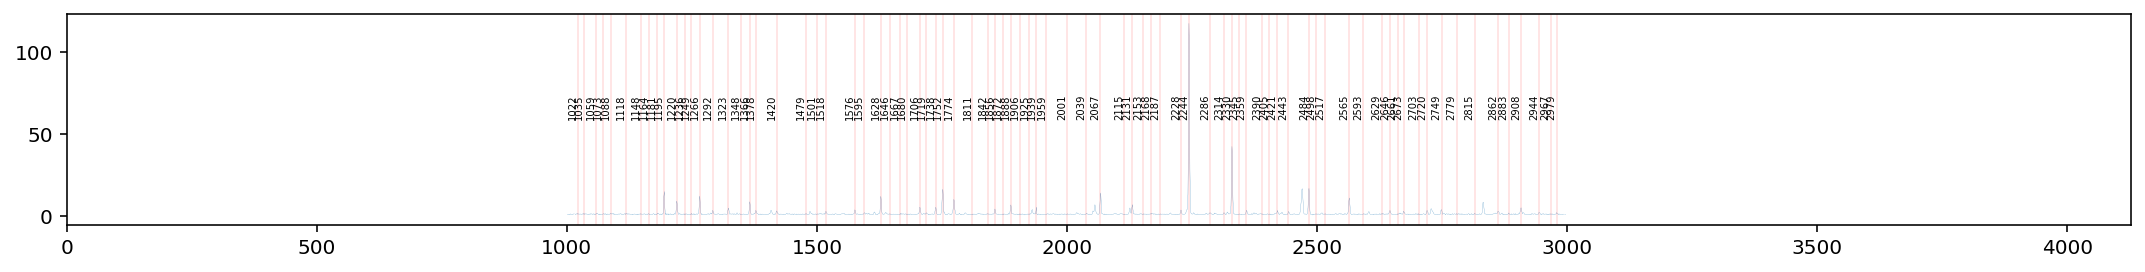

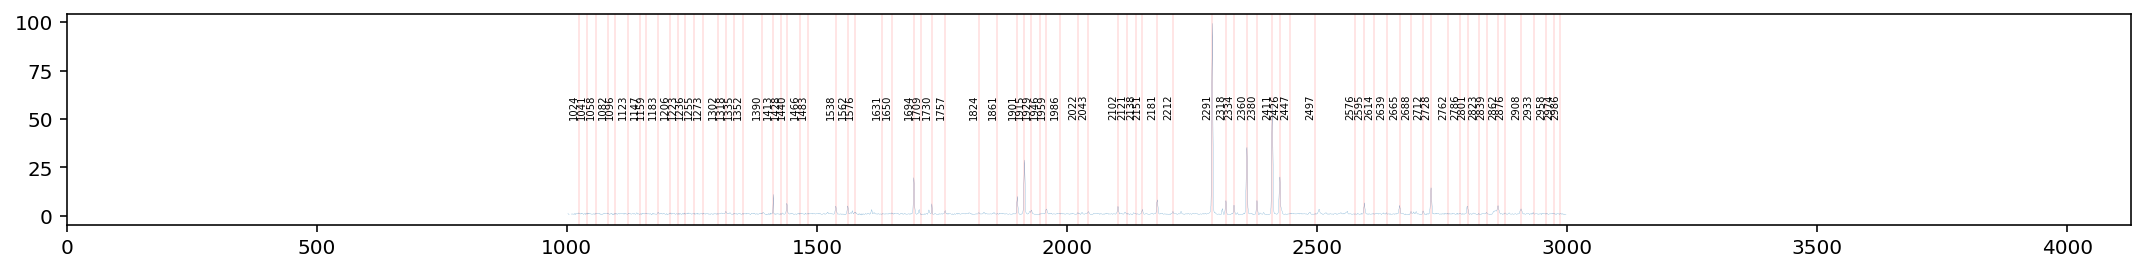

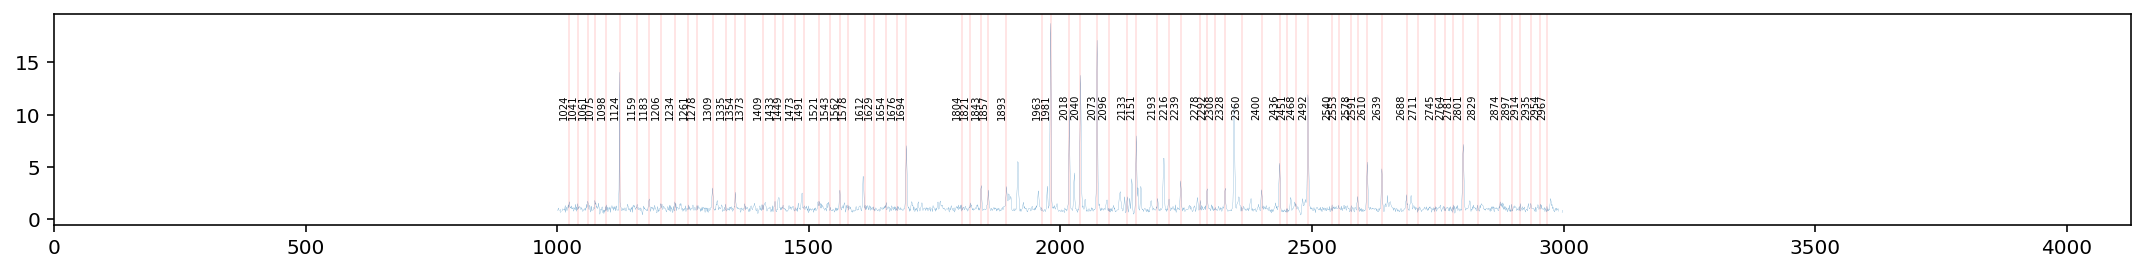

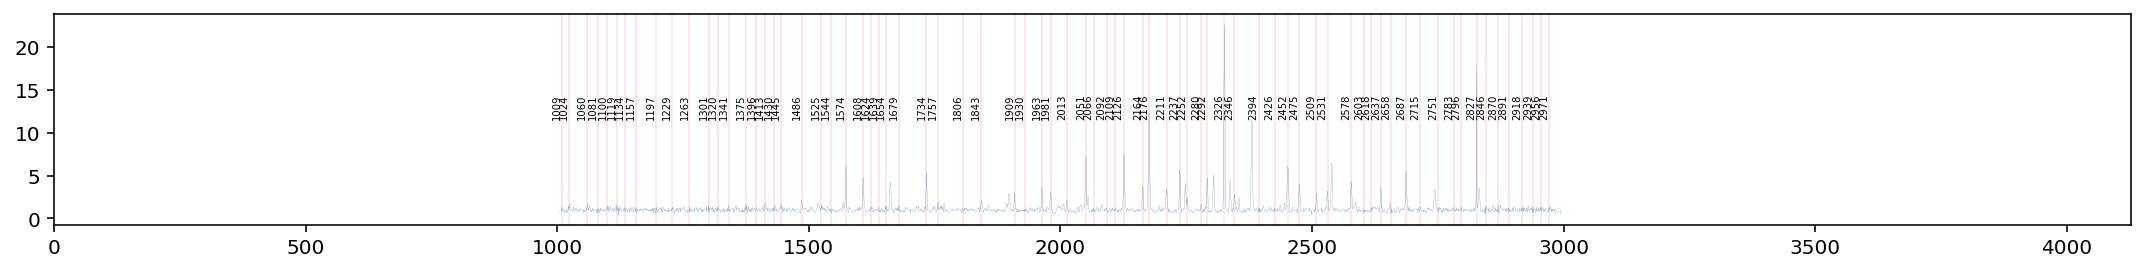

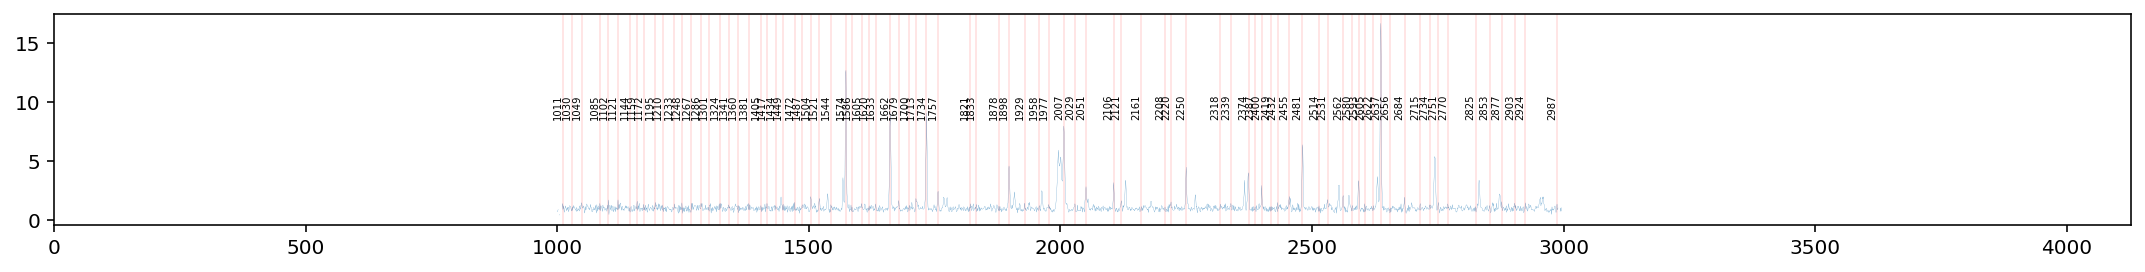

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_24814/2676032564.py:5: RuntimeWarning: invalid value encountered in true_divide
  thxe = file[order].data[2,:]/file[order].data[1,:]


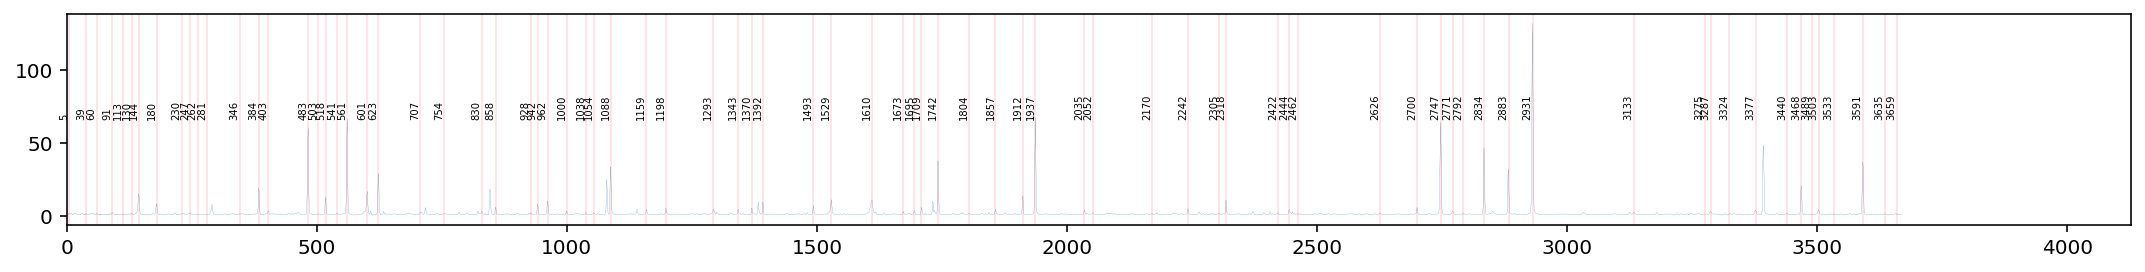

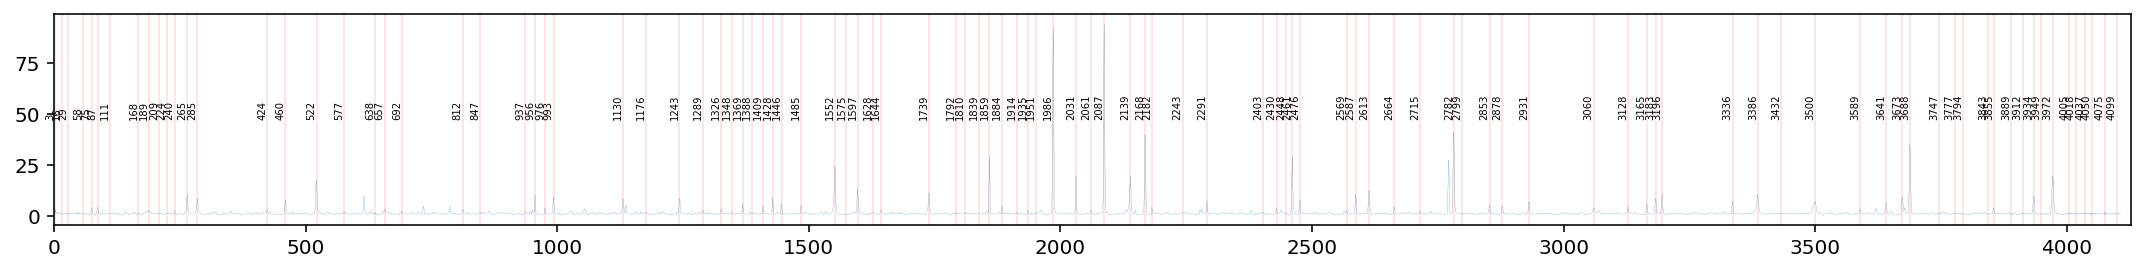

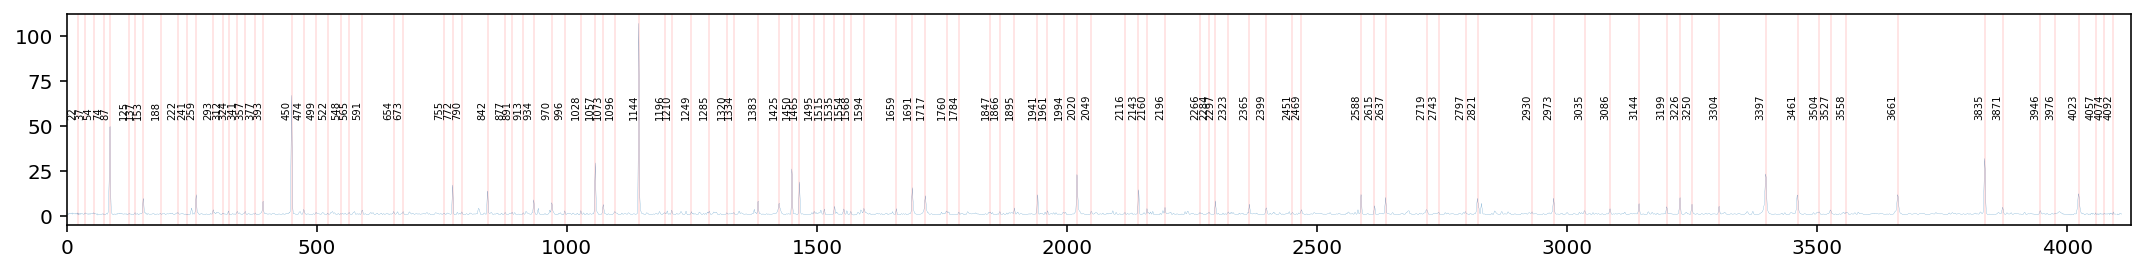

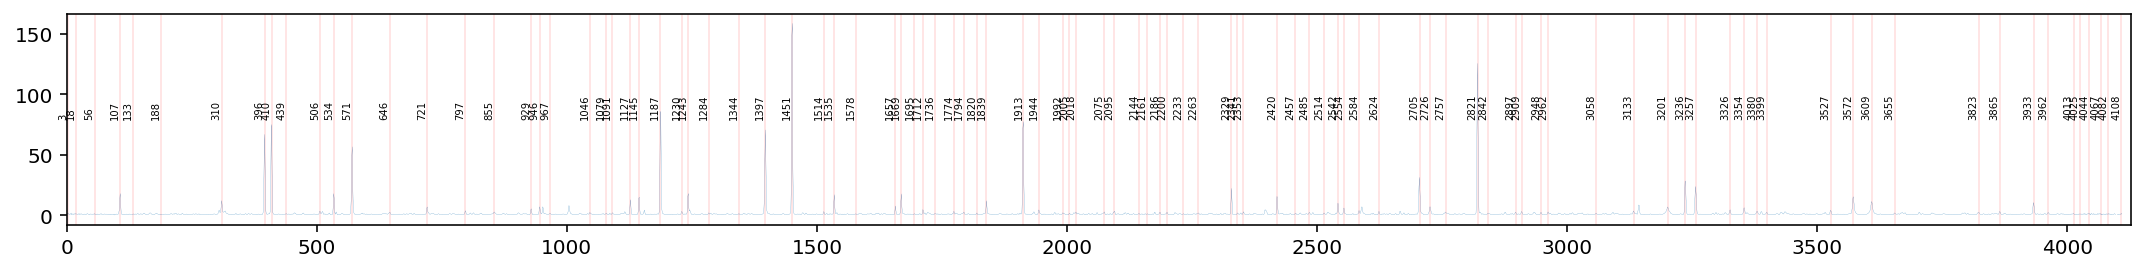

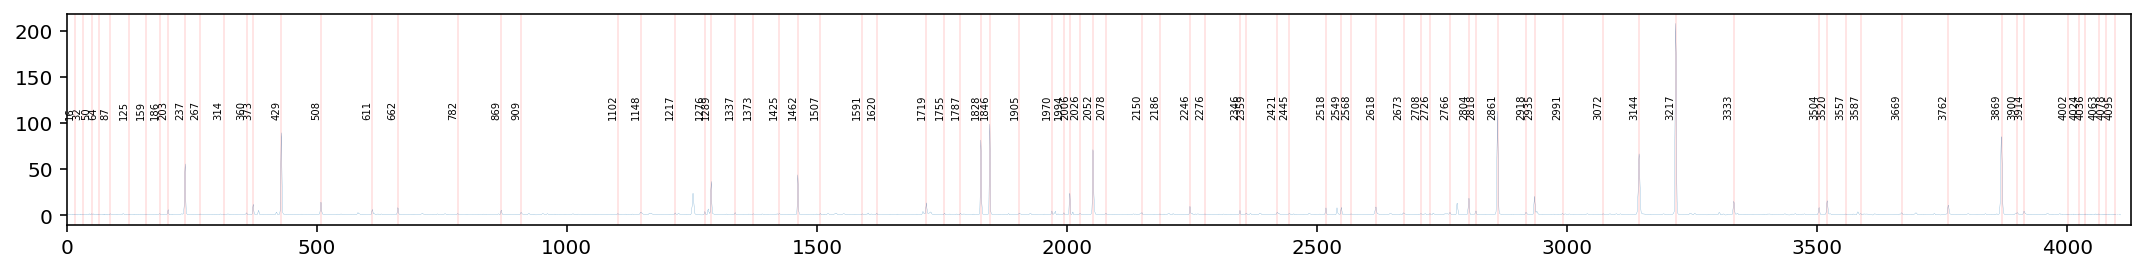

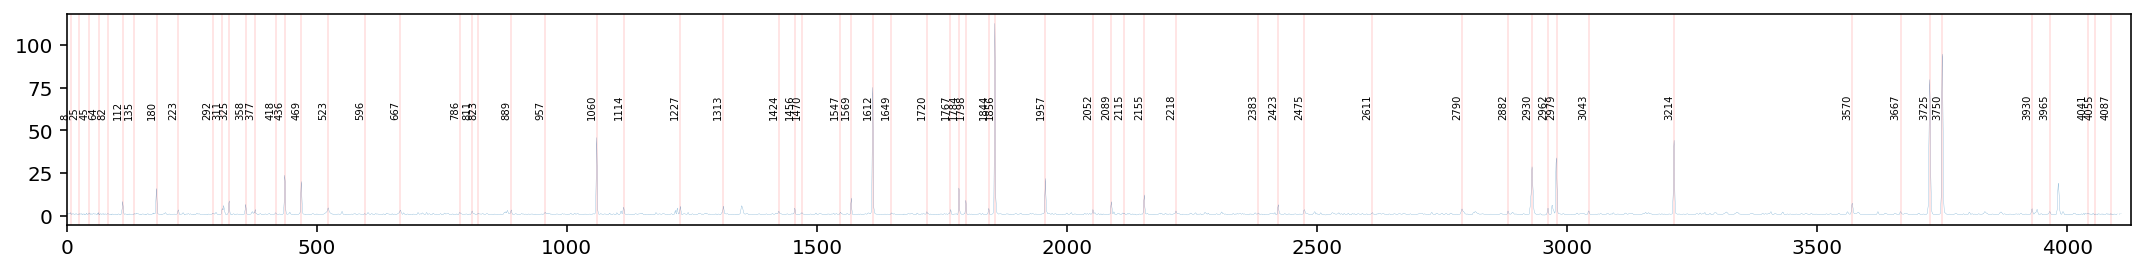

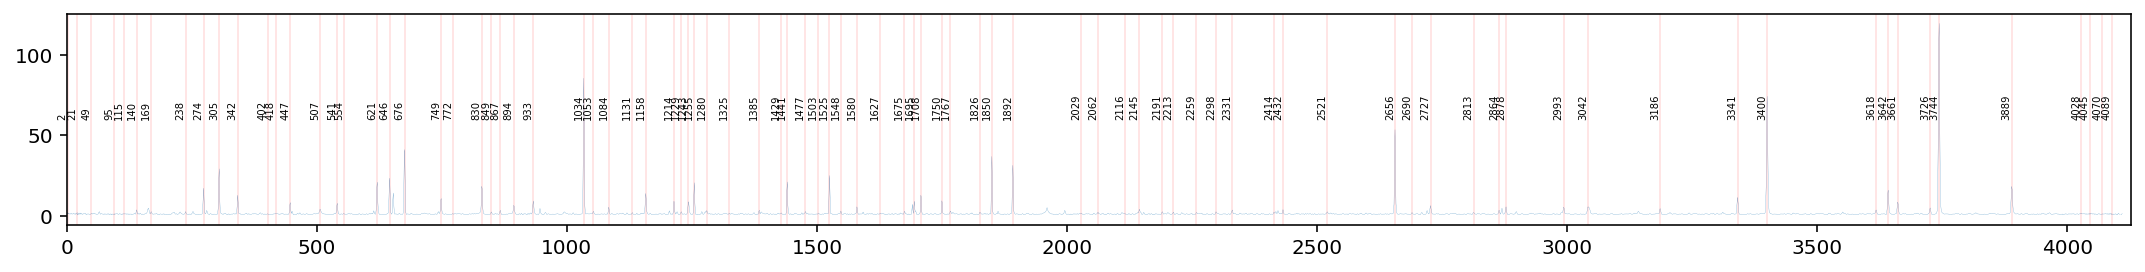

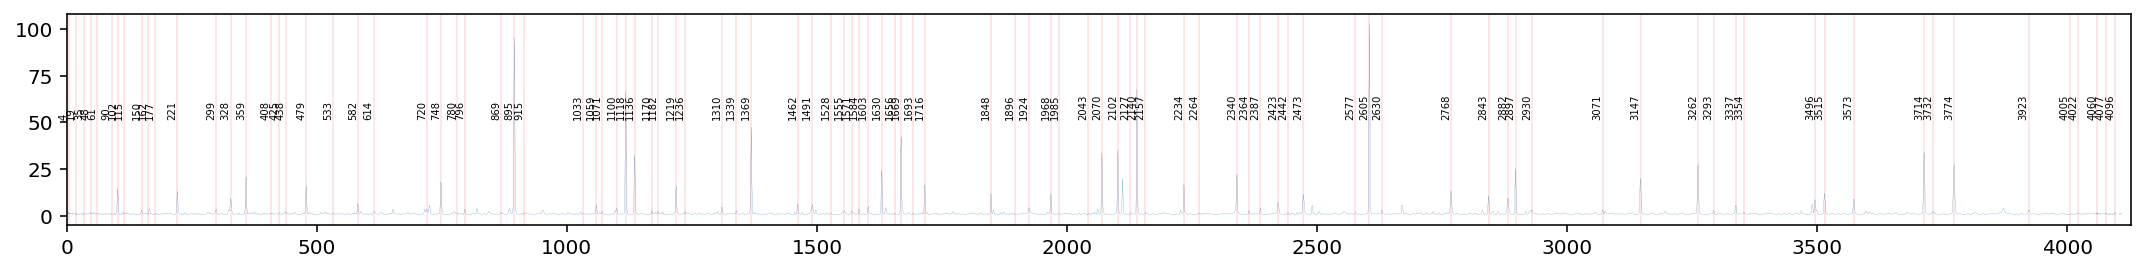

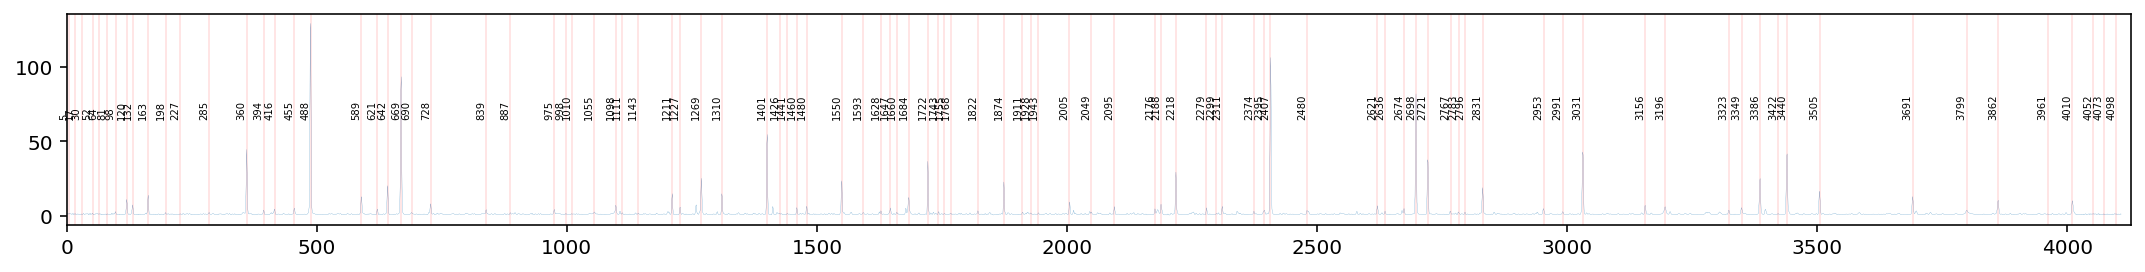

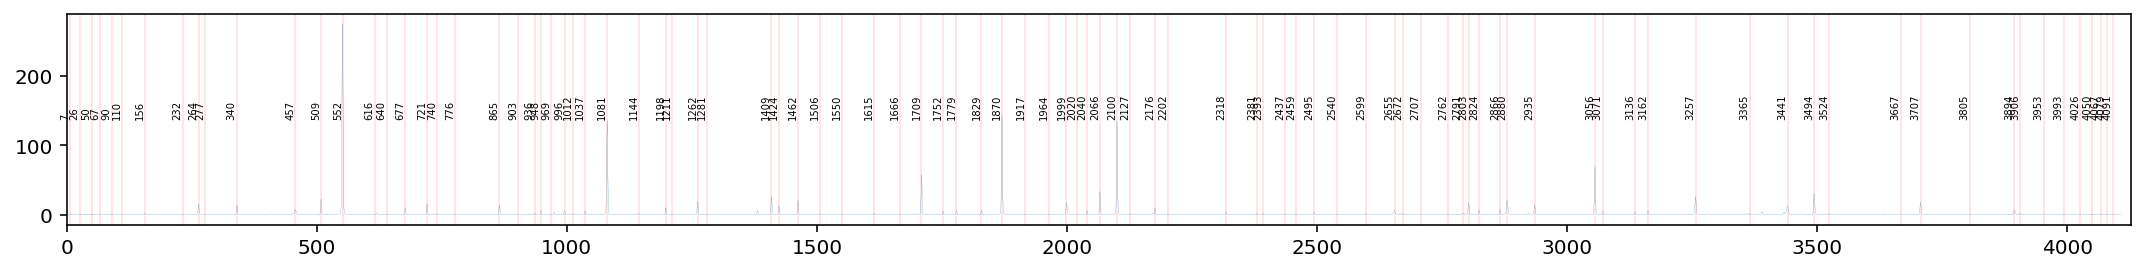

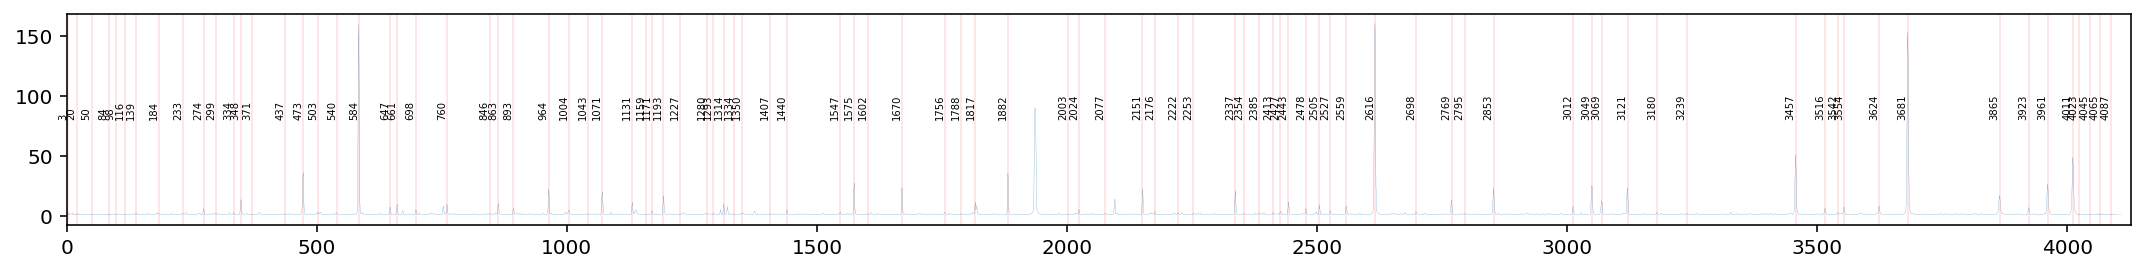

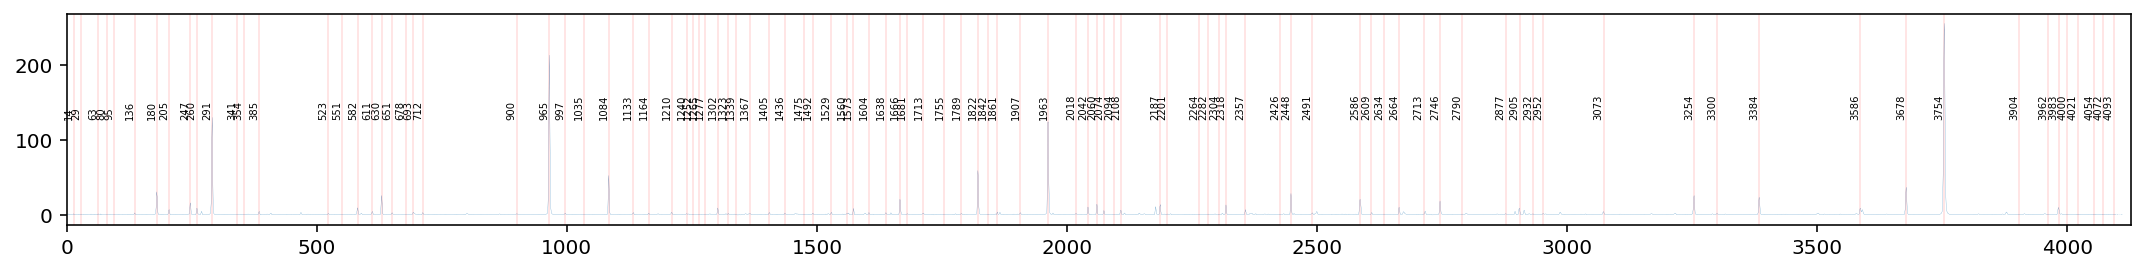

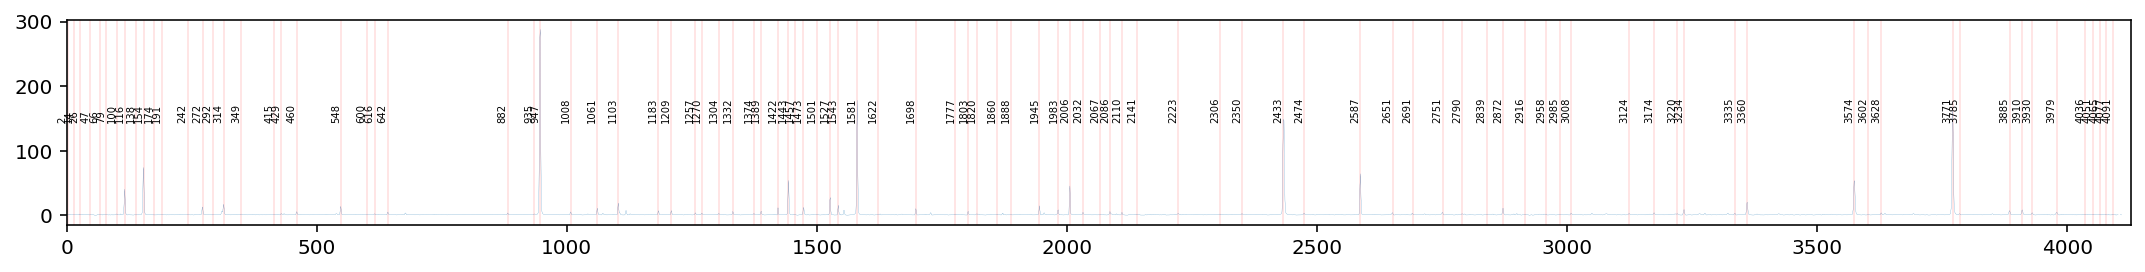

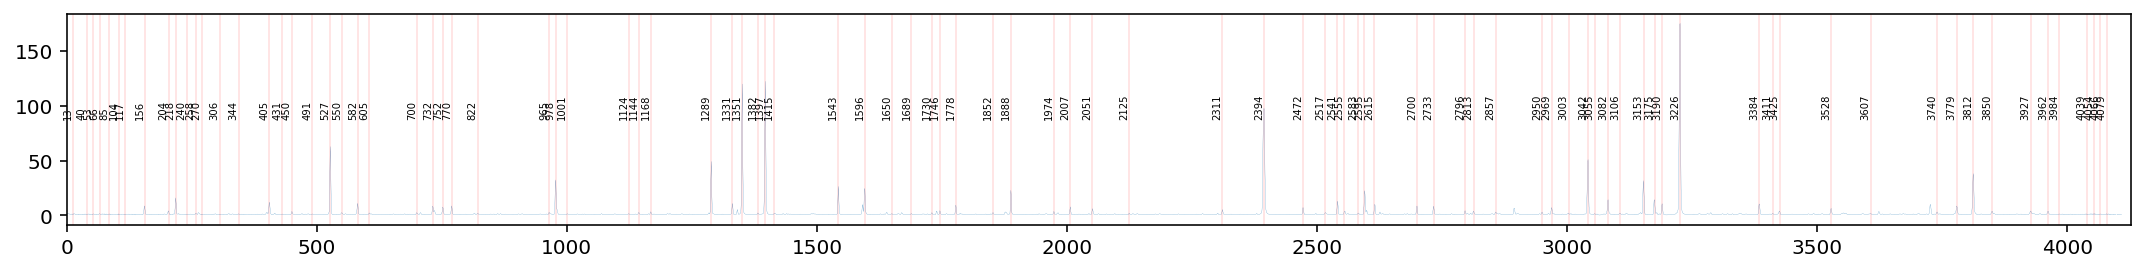

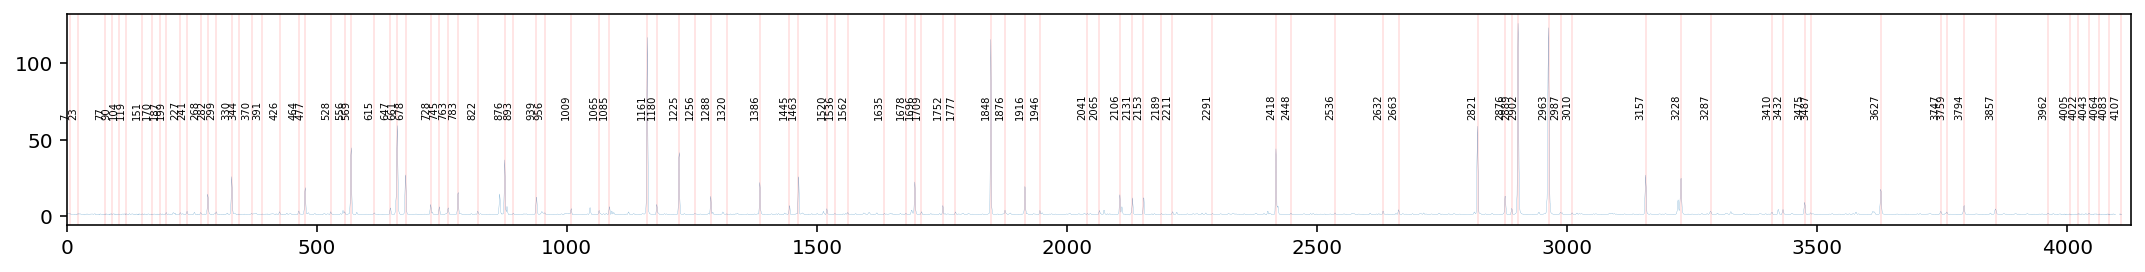

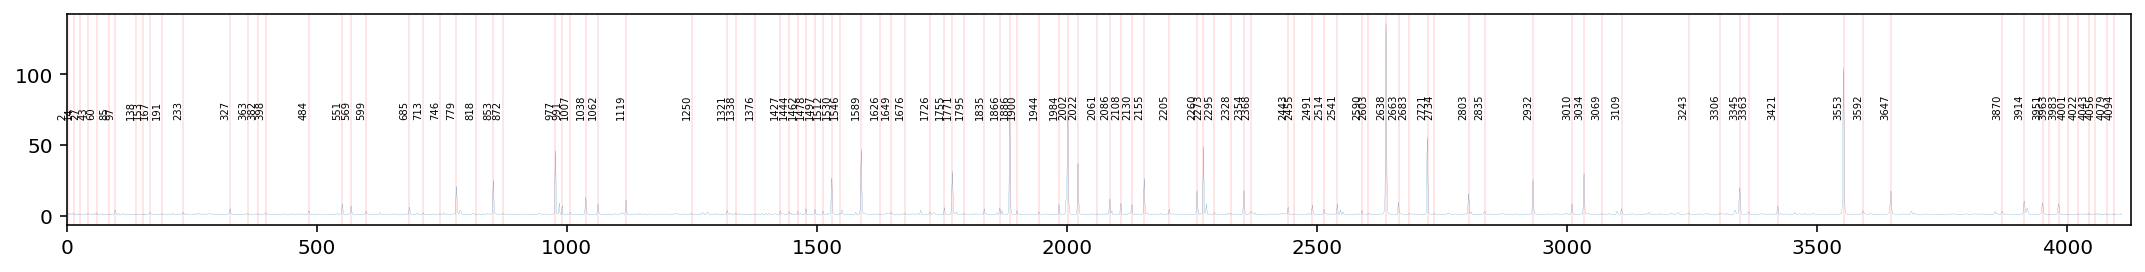

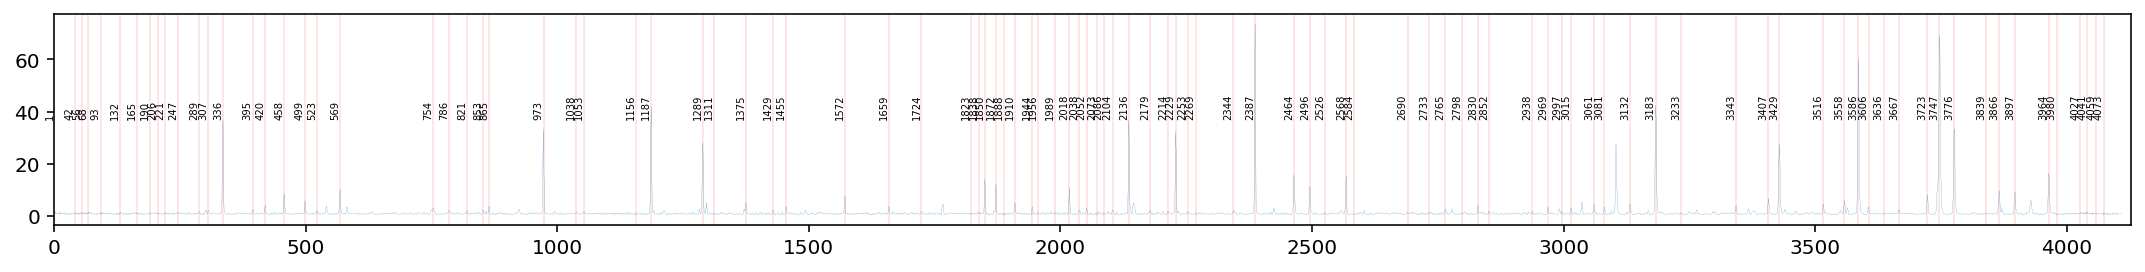

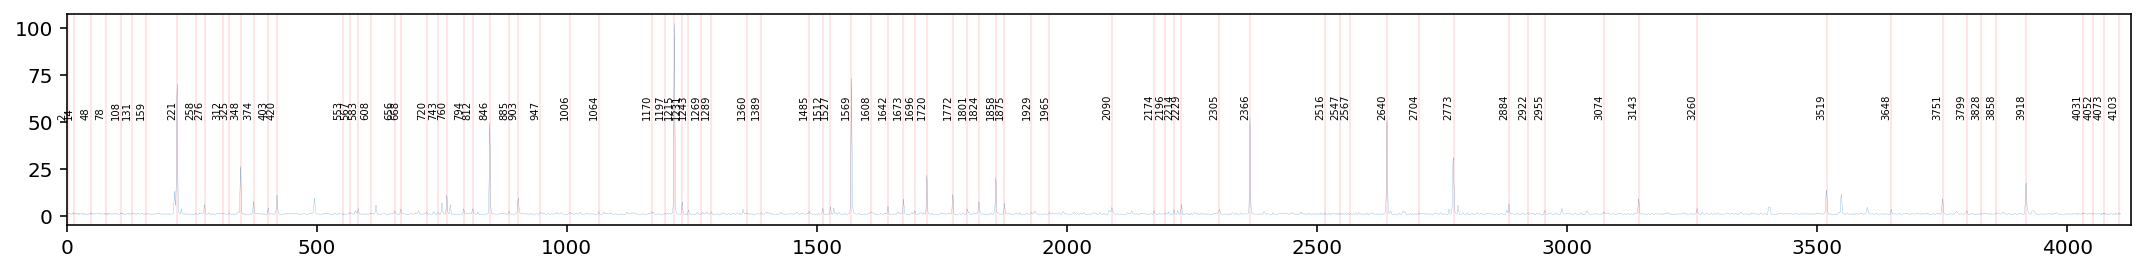

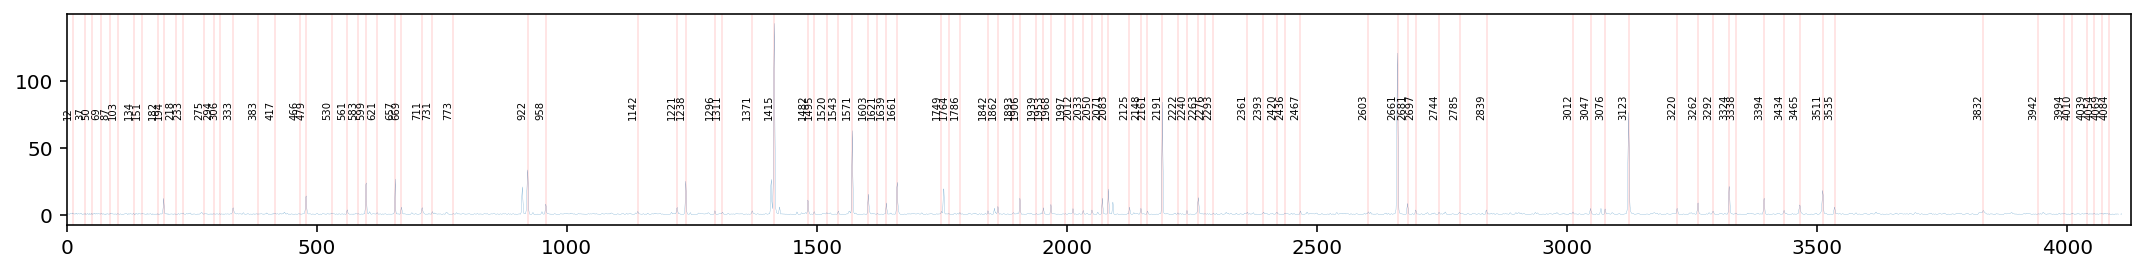

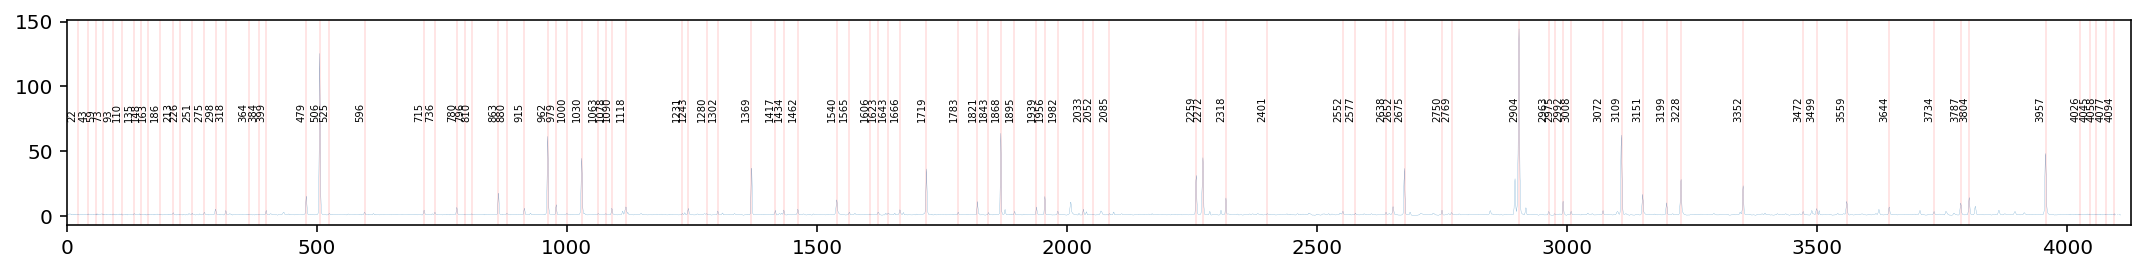

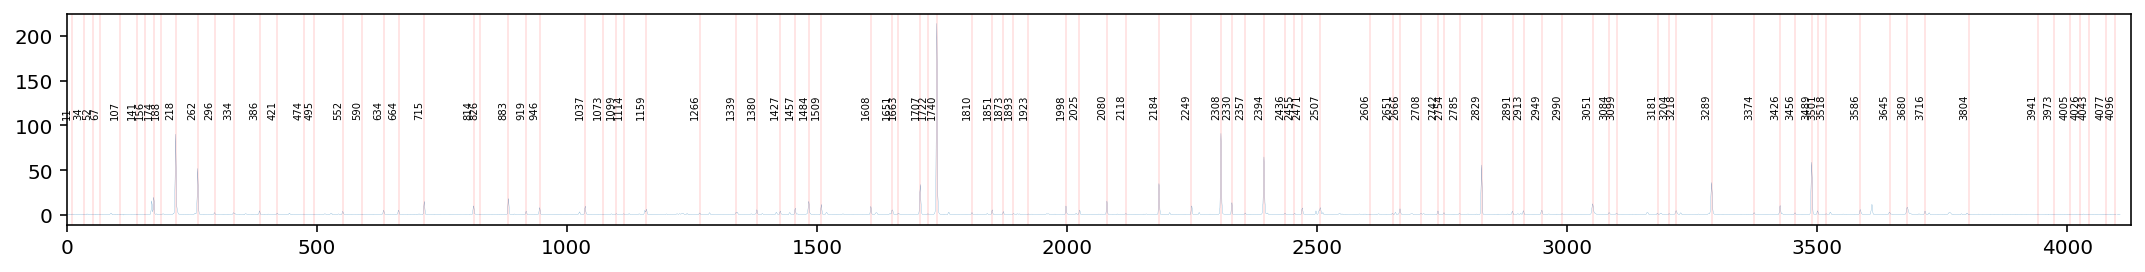

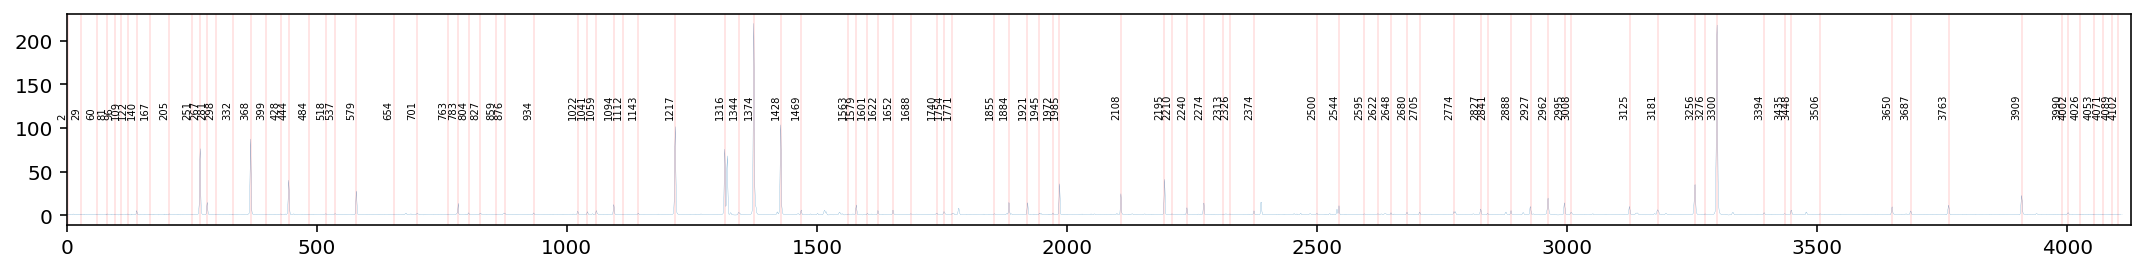

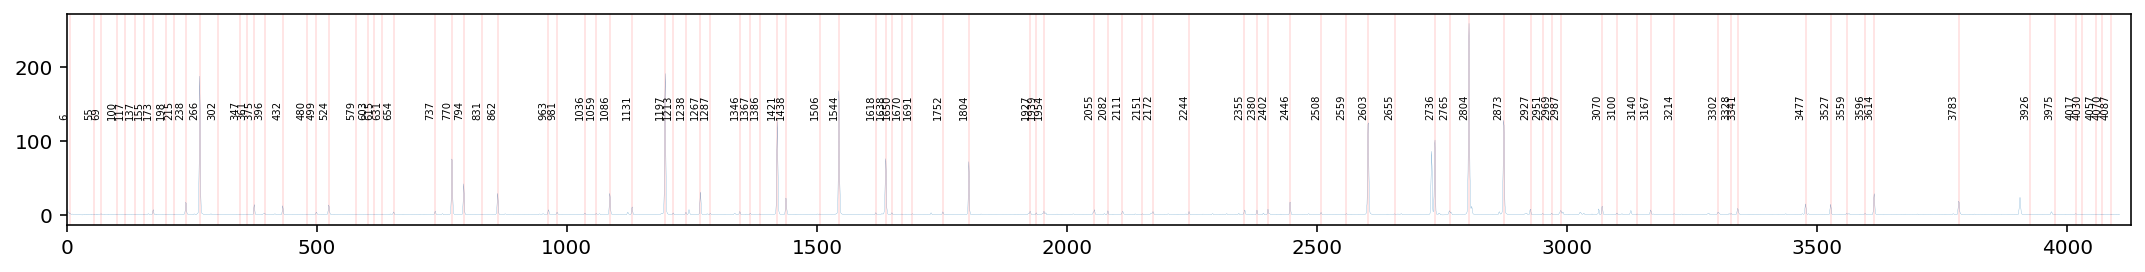

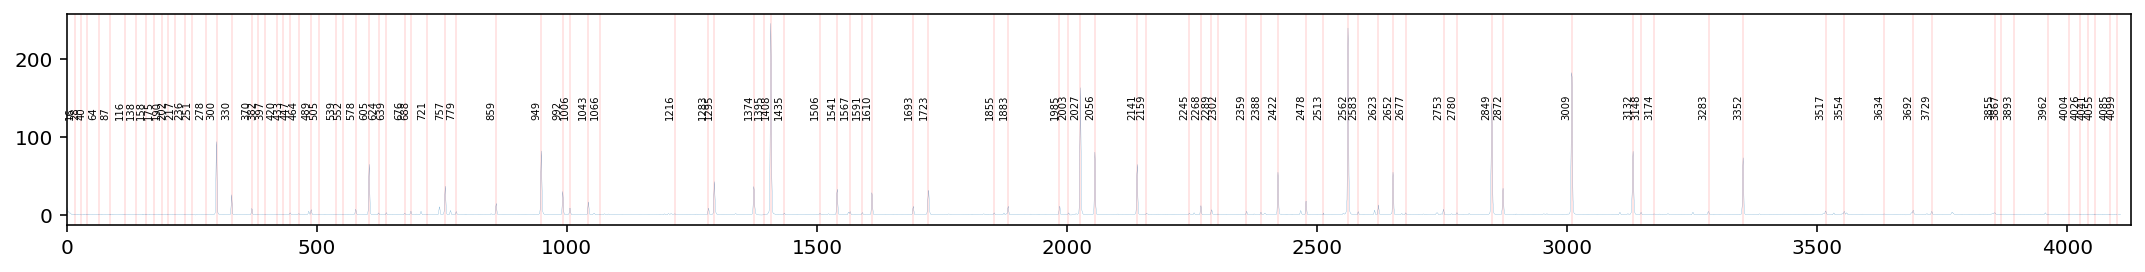

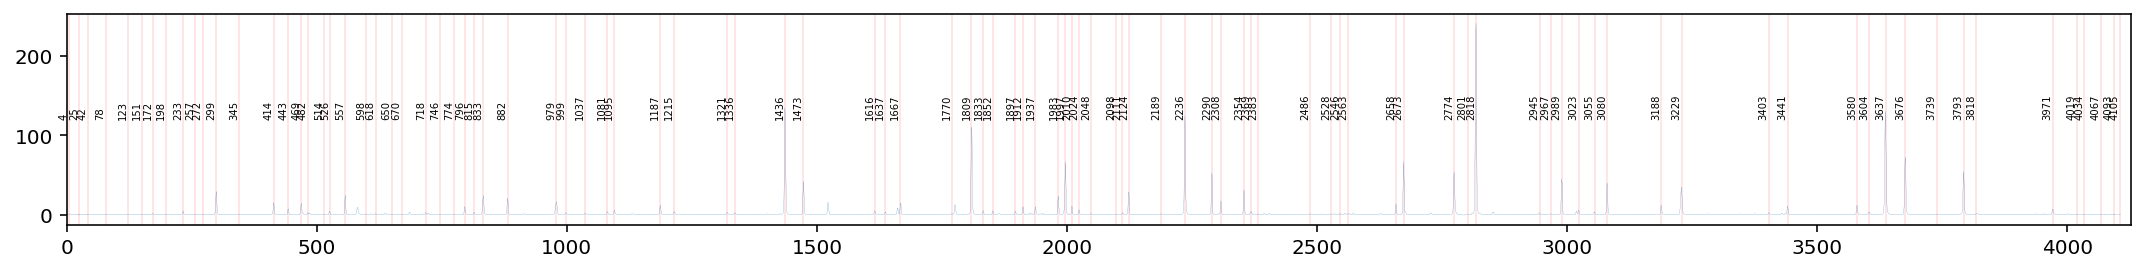

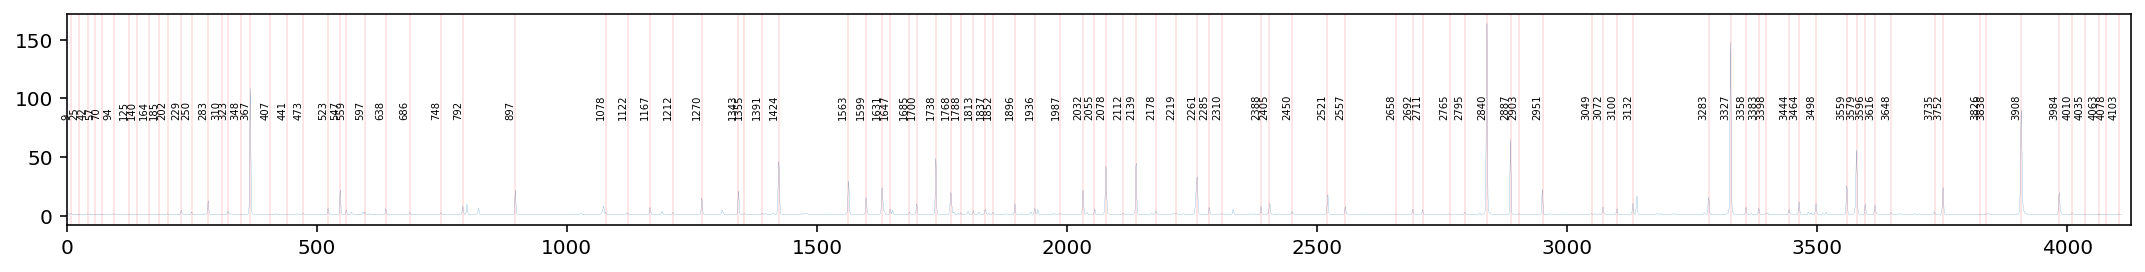

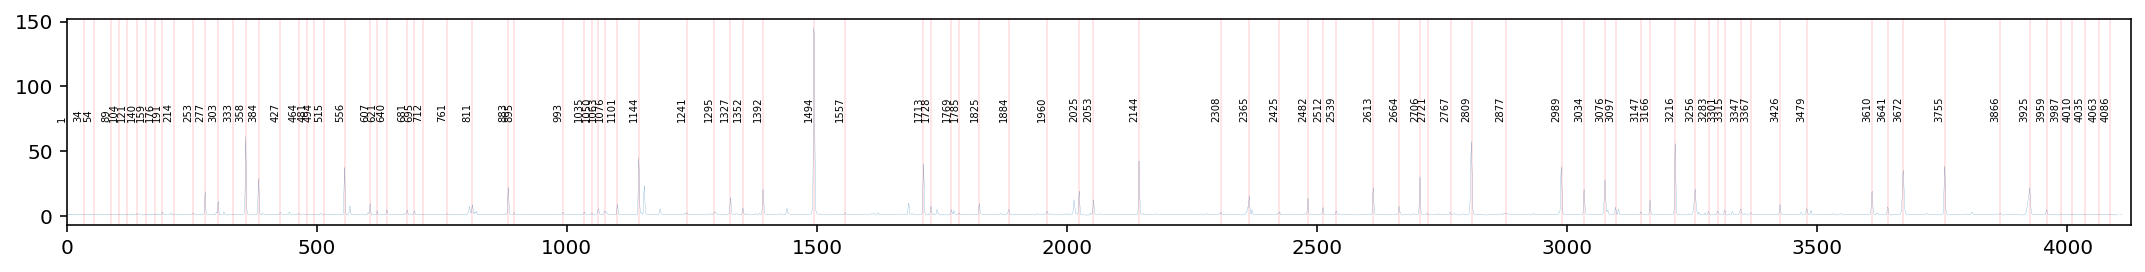

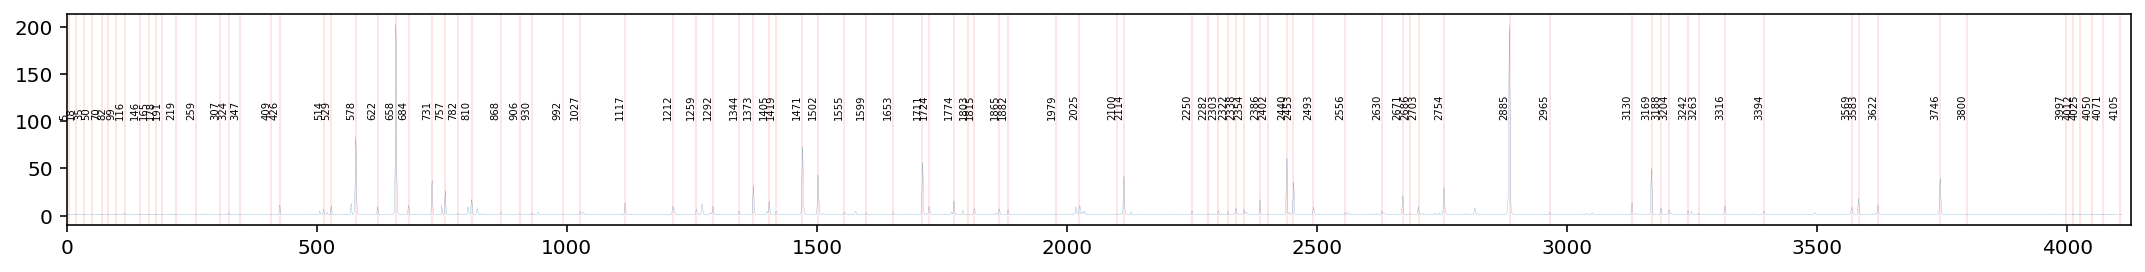

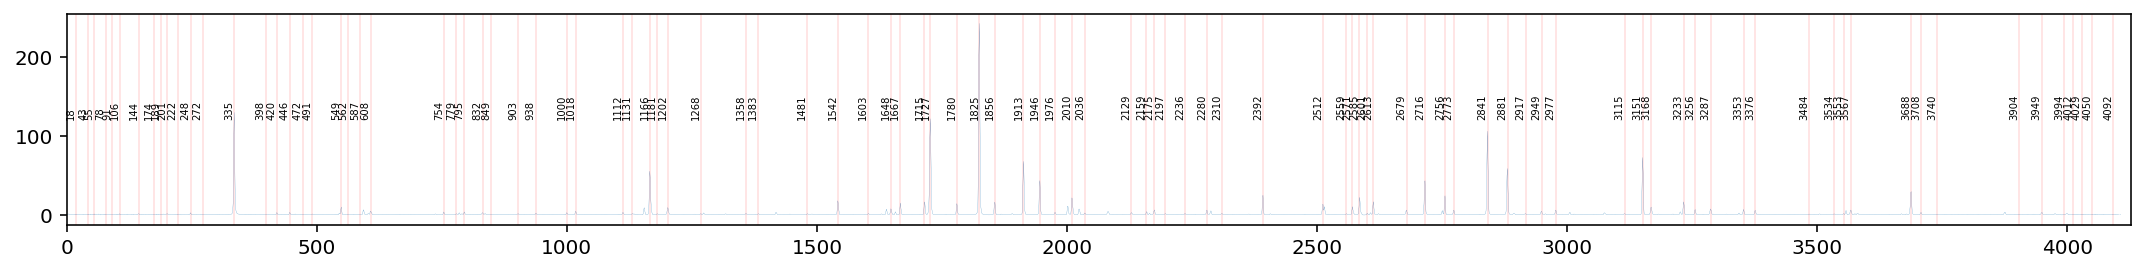

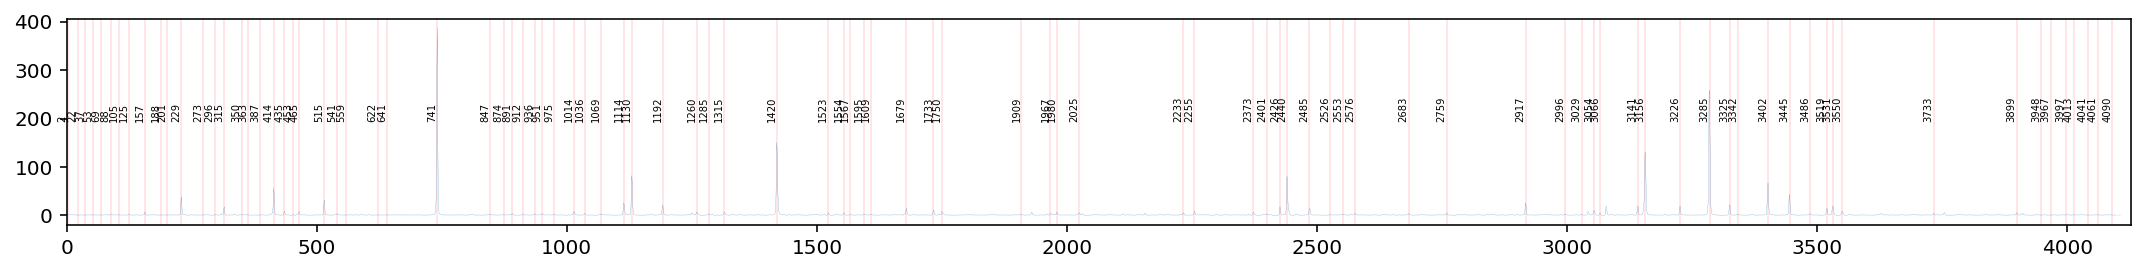

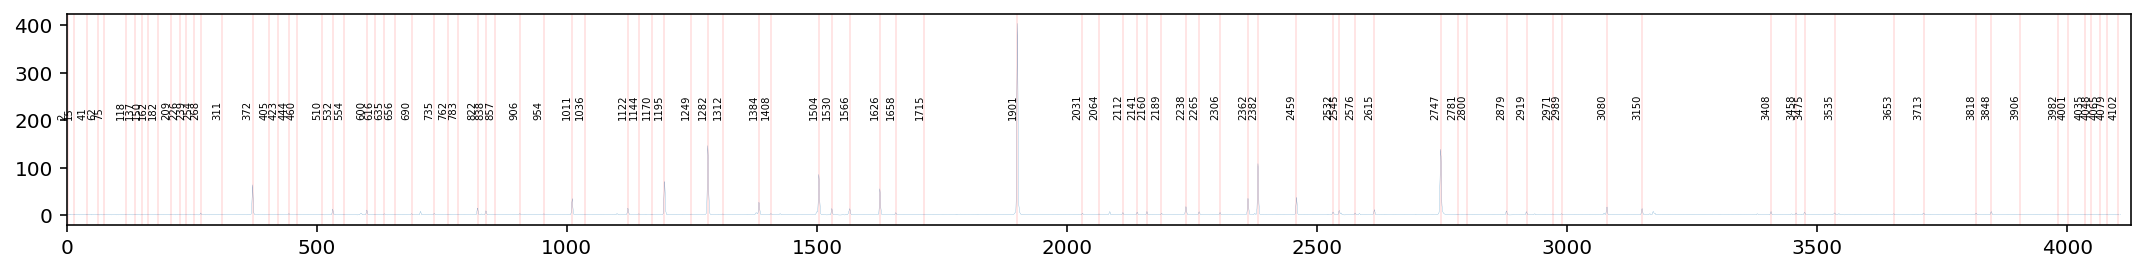

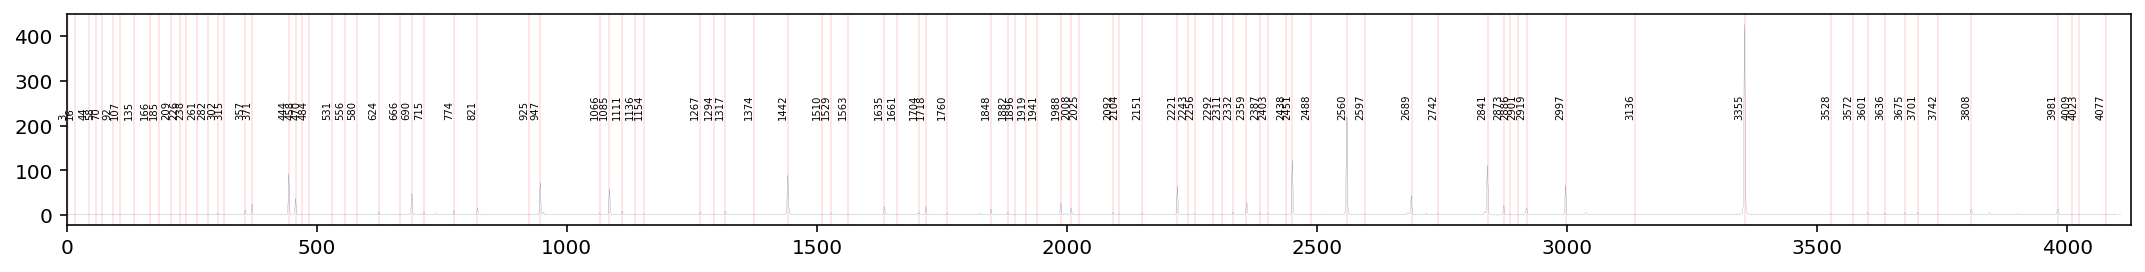

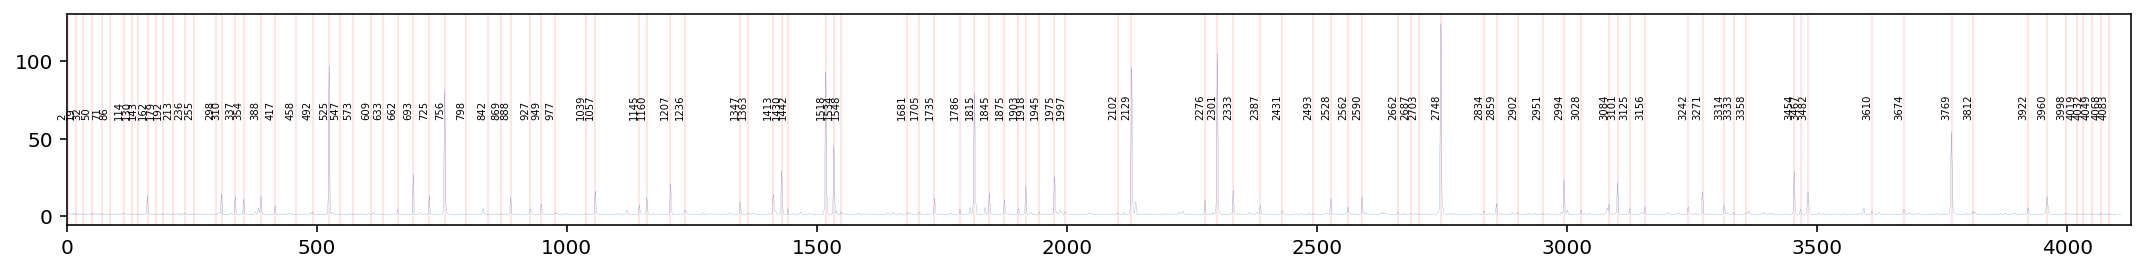

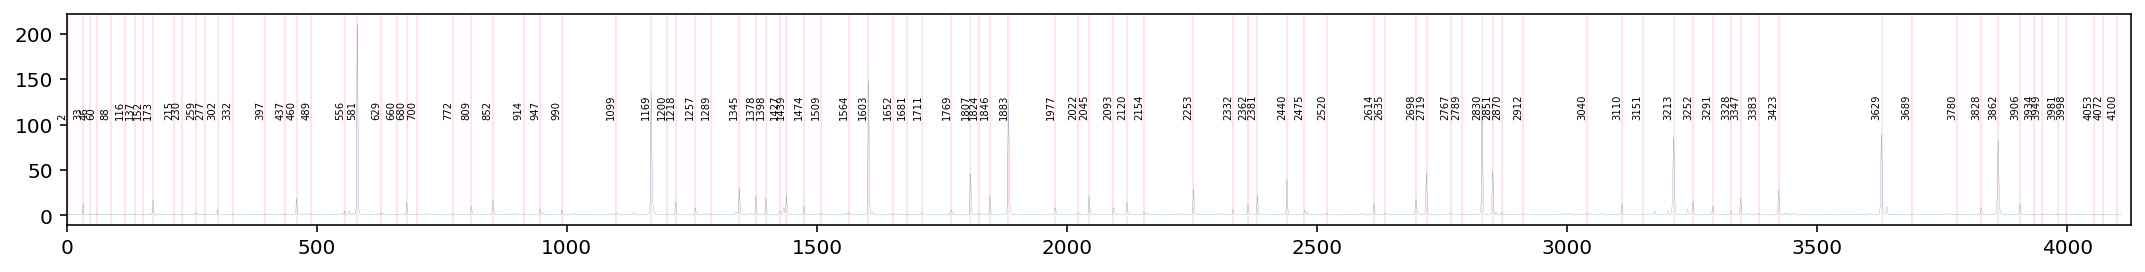

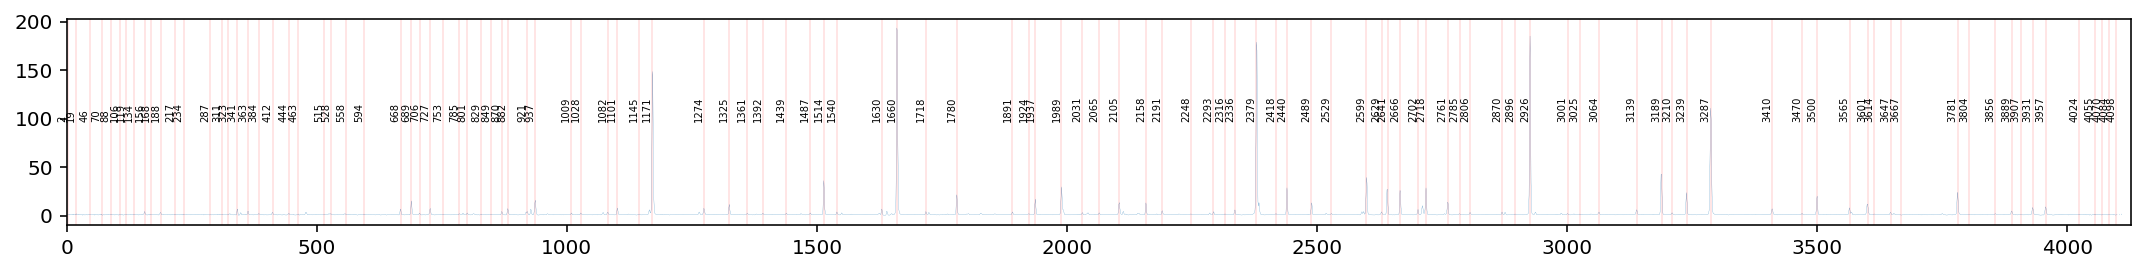

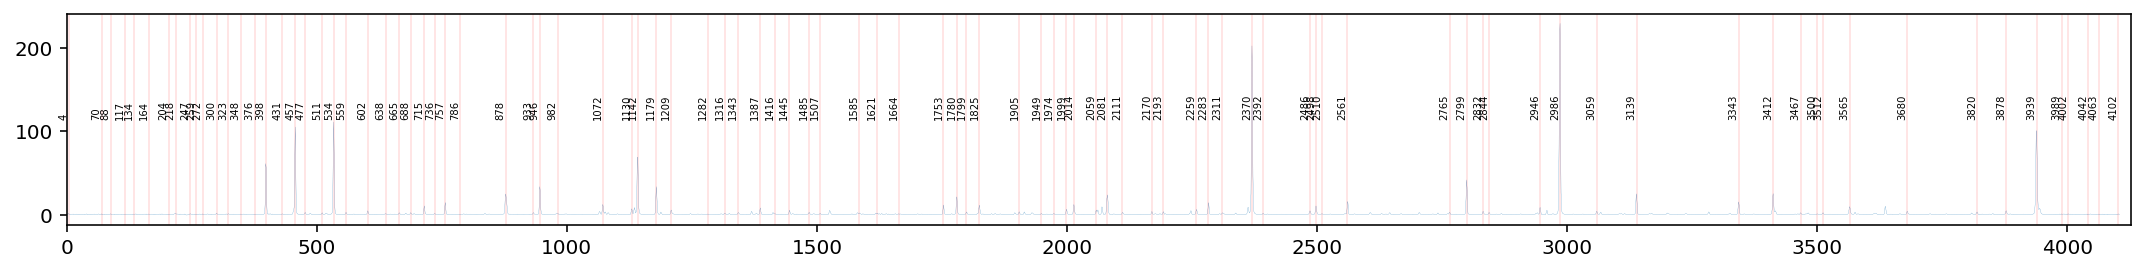

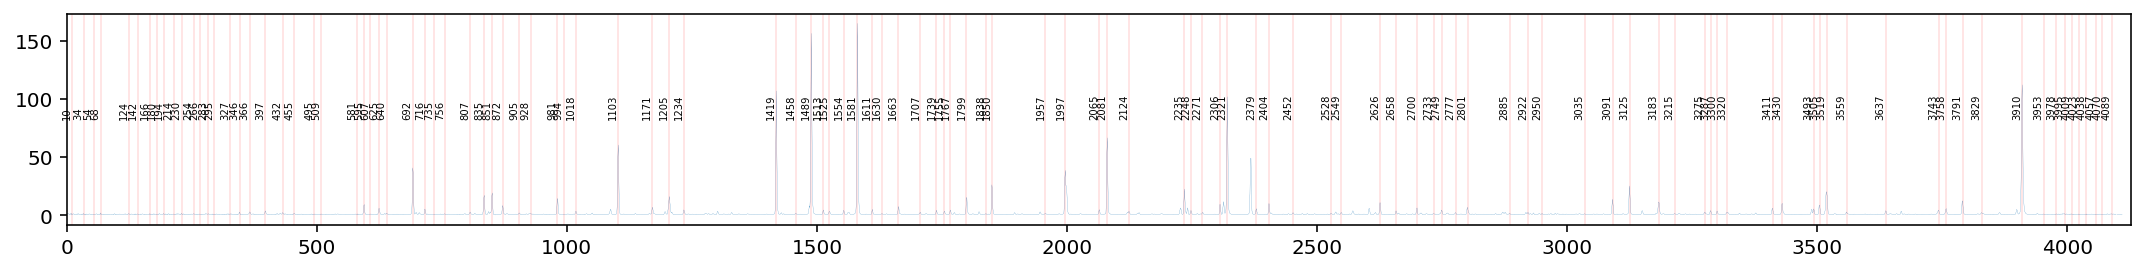

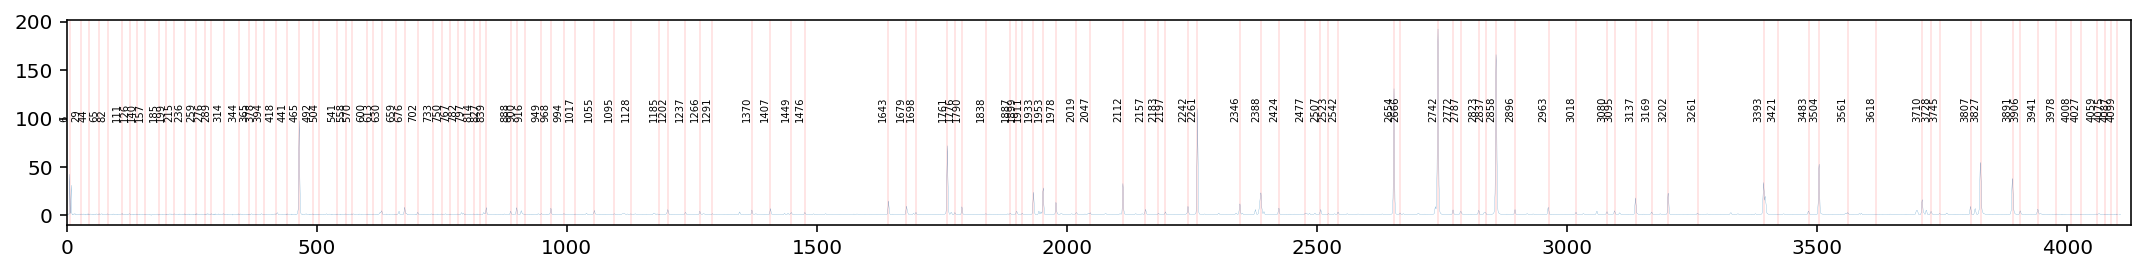

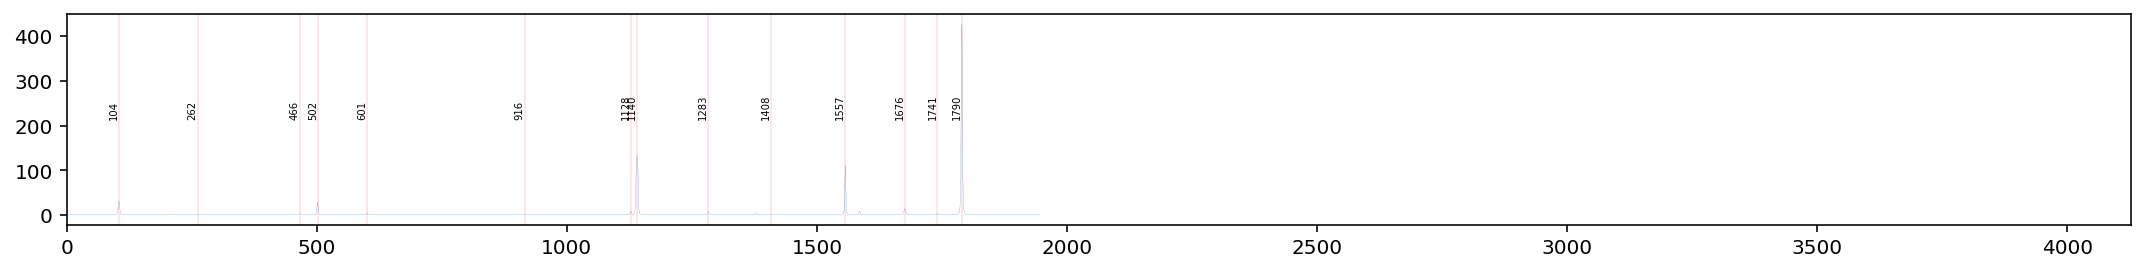

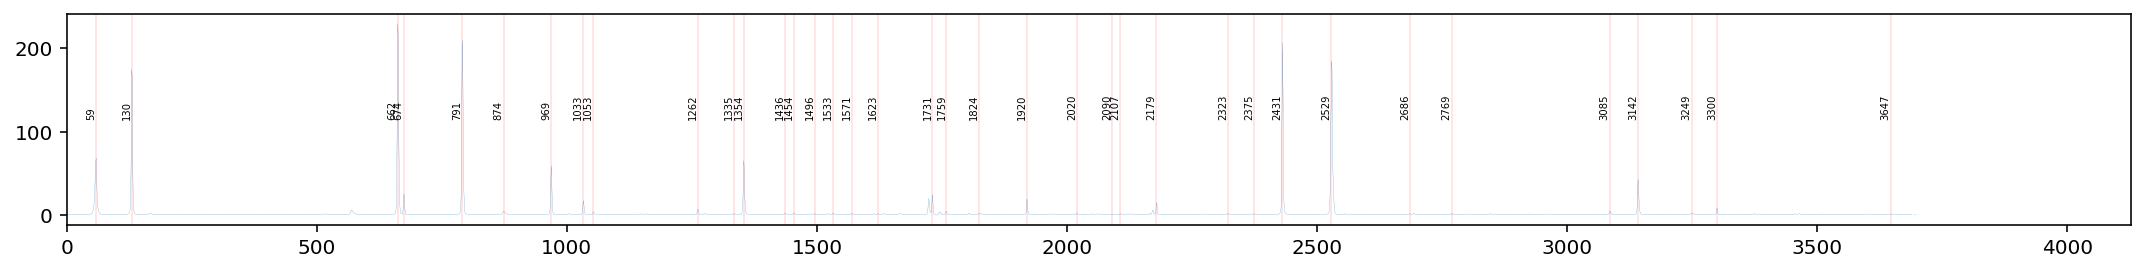

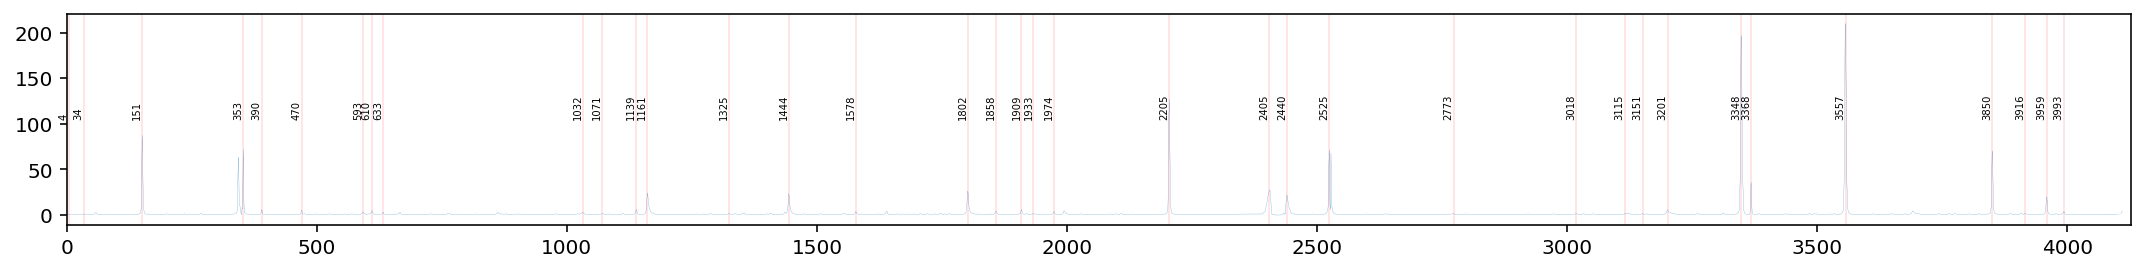

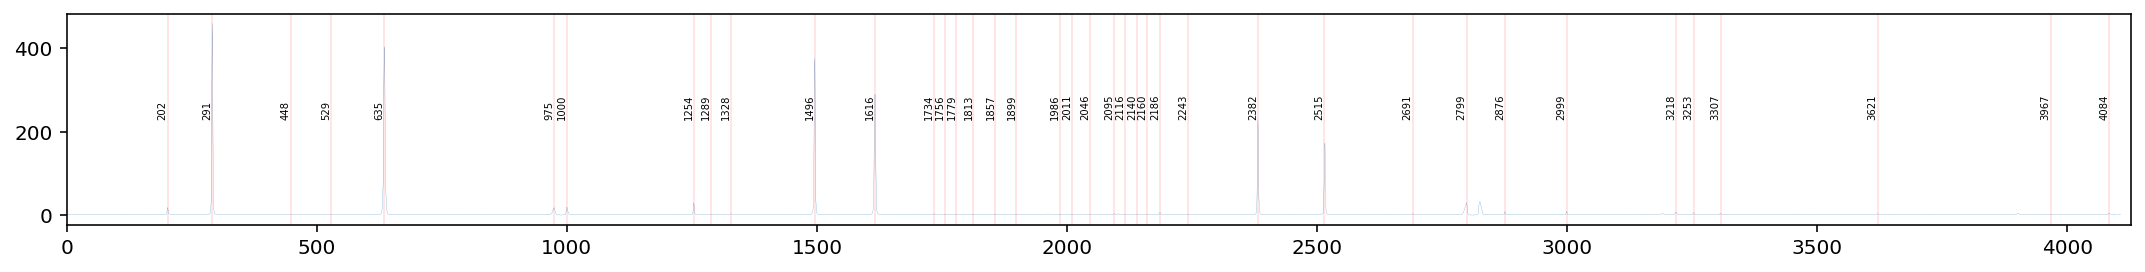

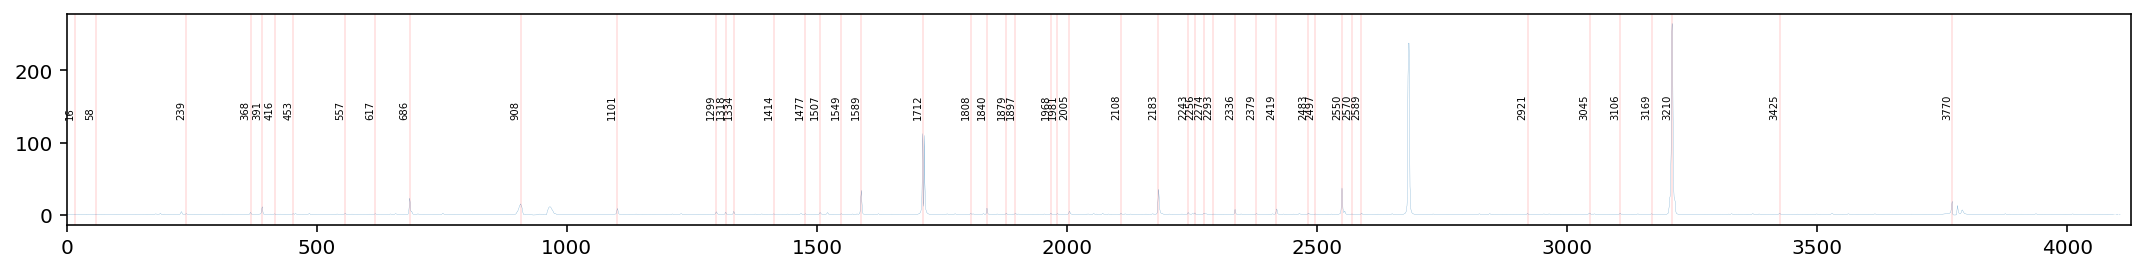

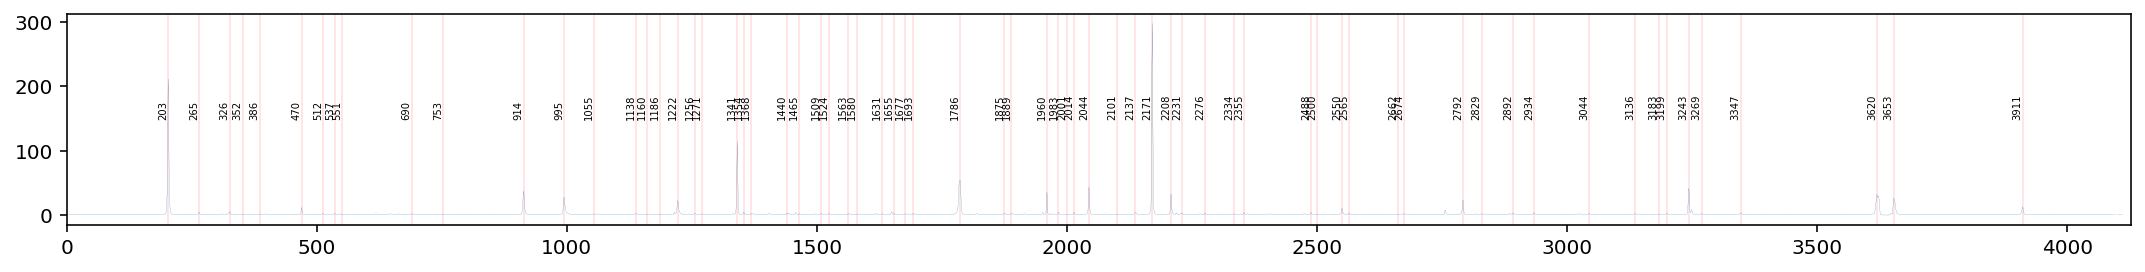

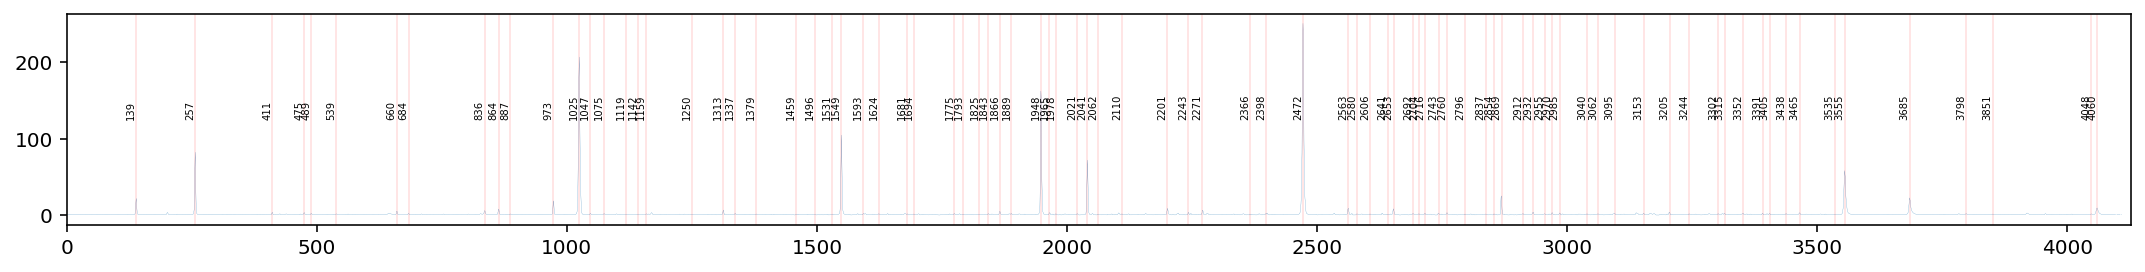

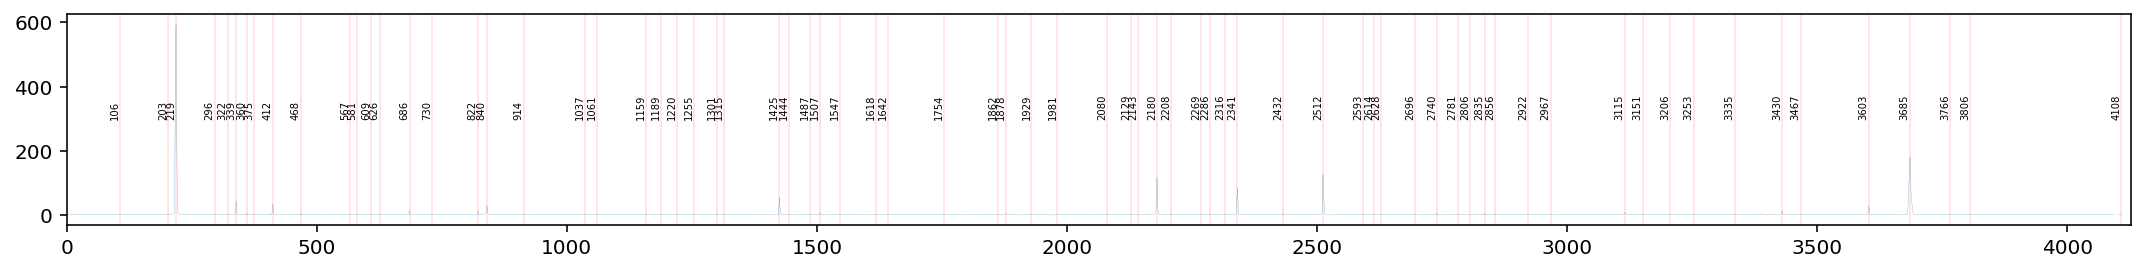

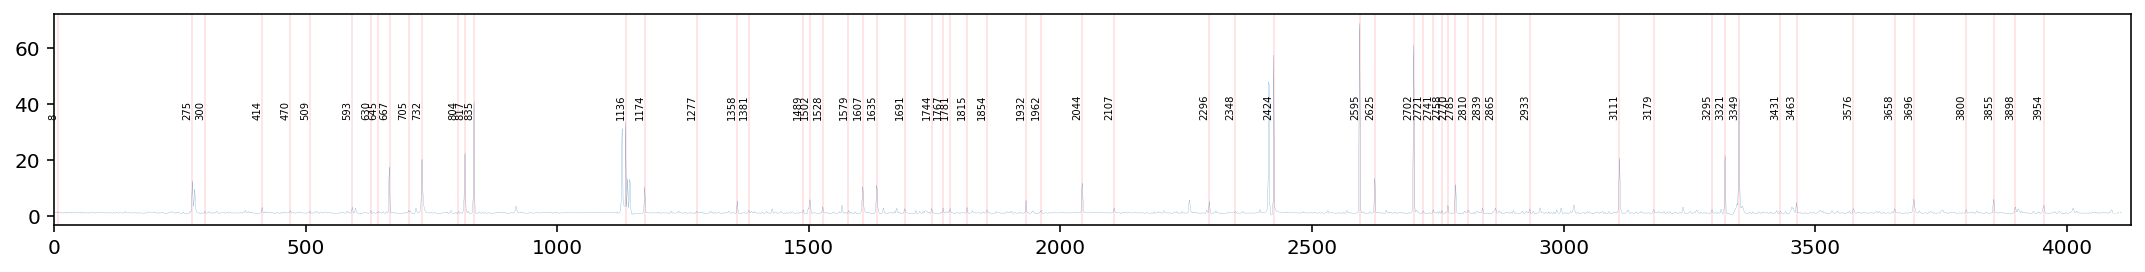

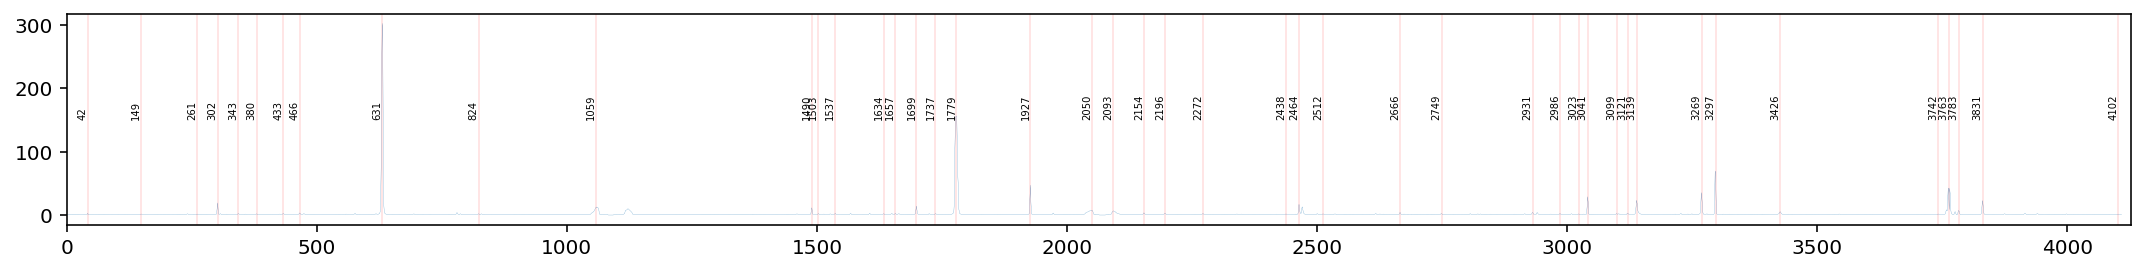

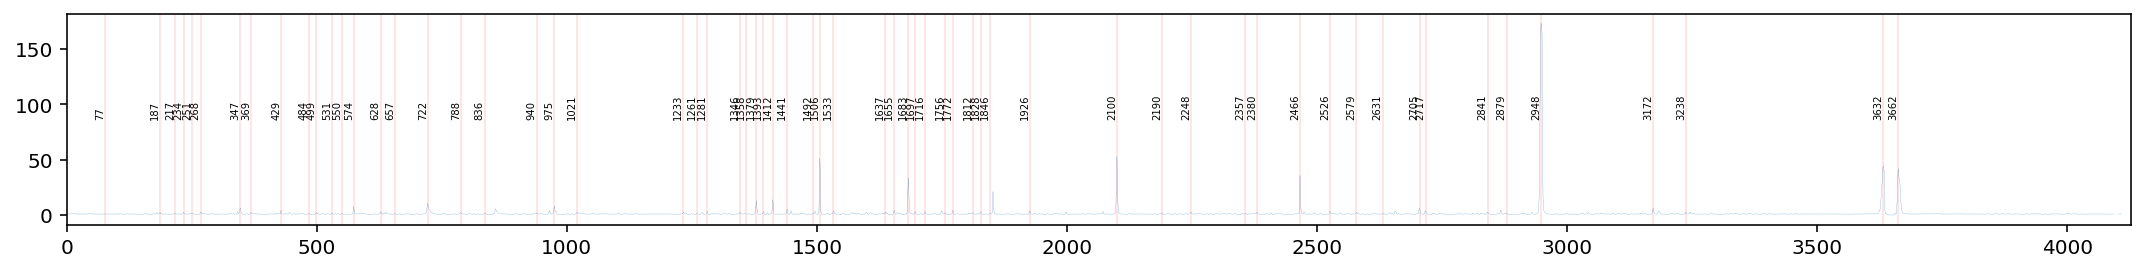

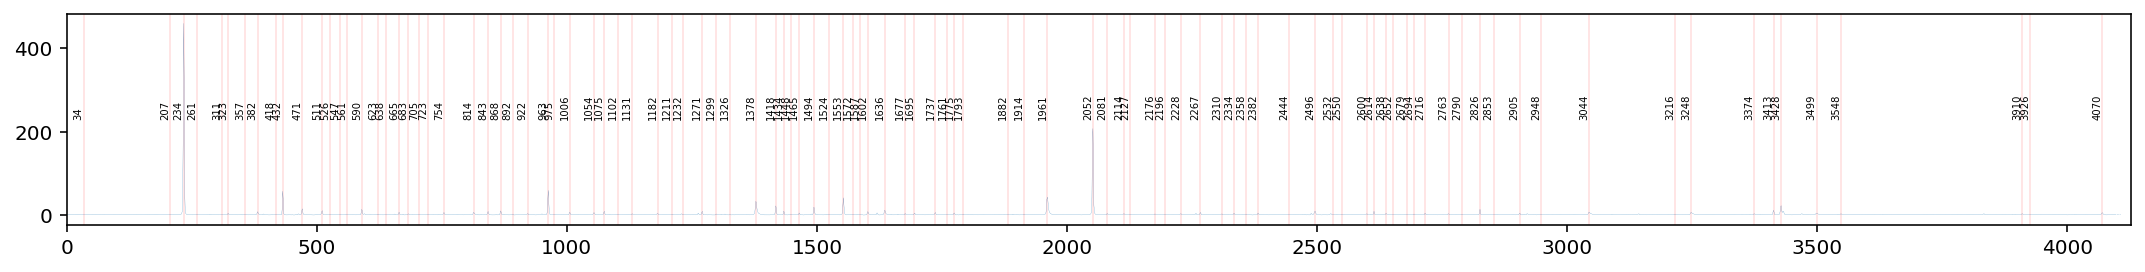

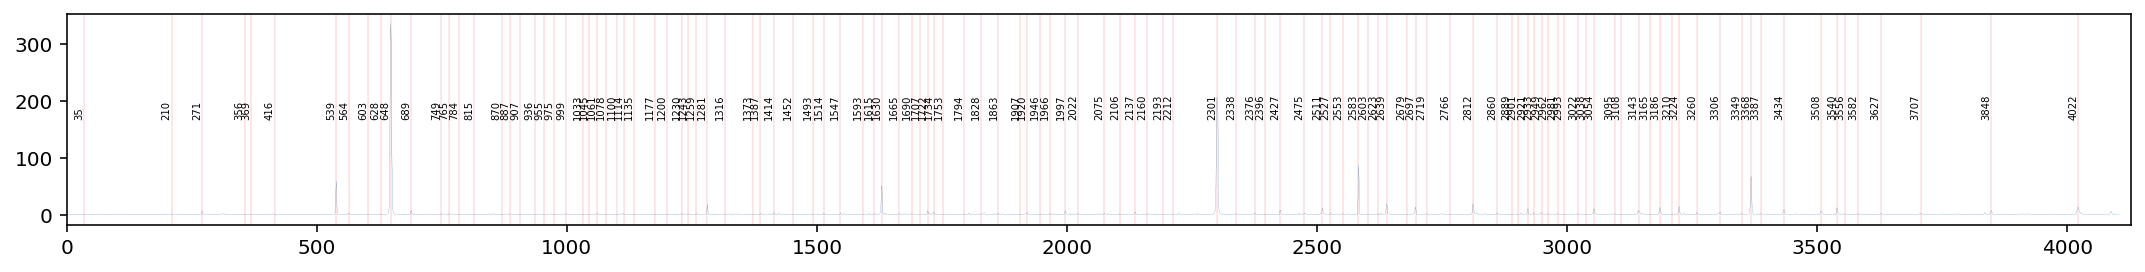

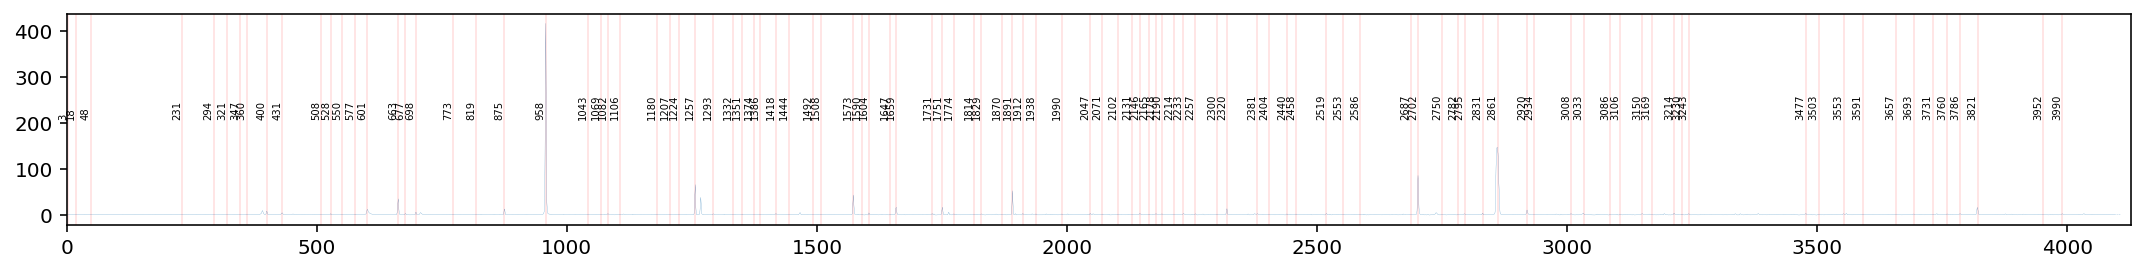

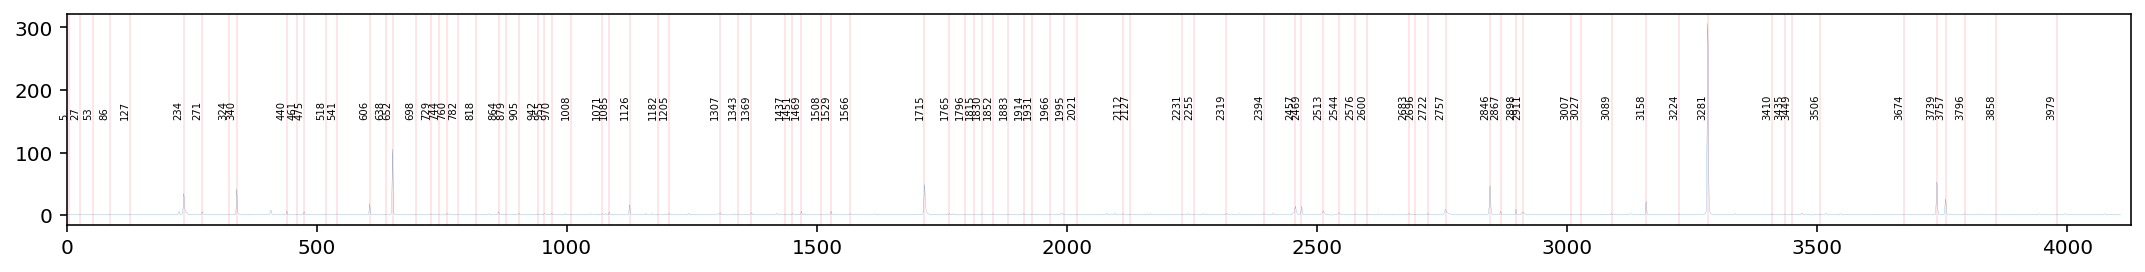

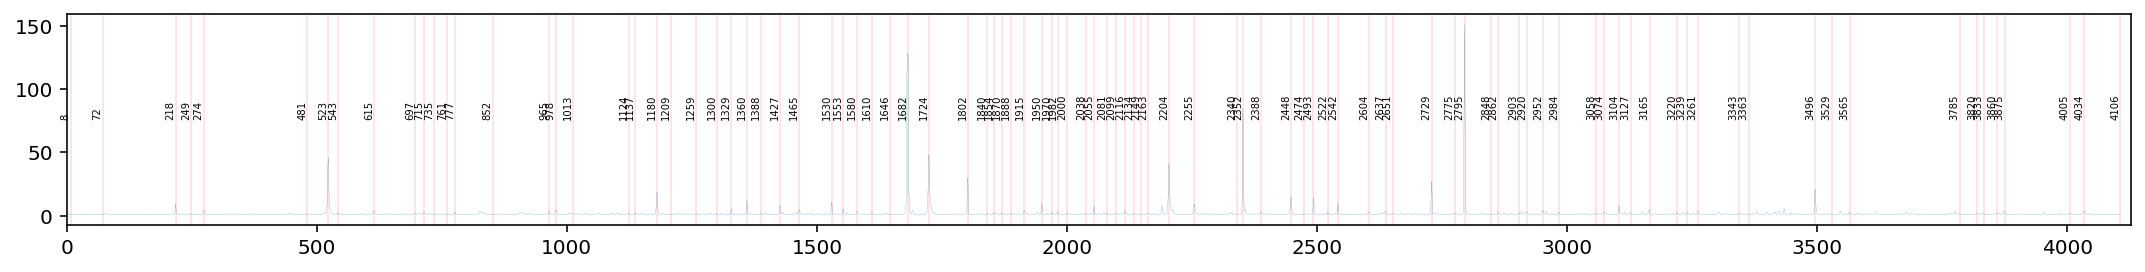

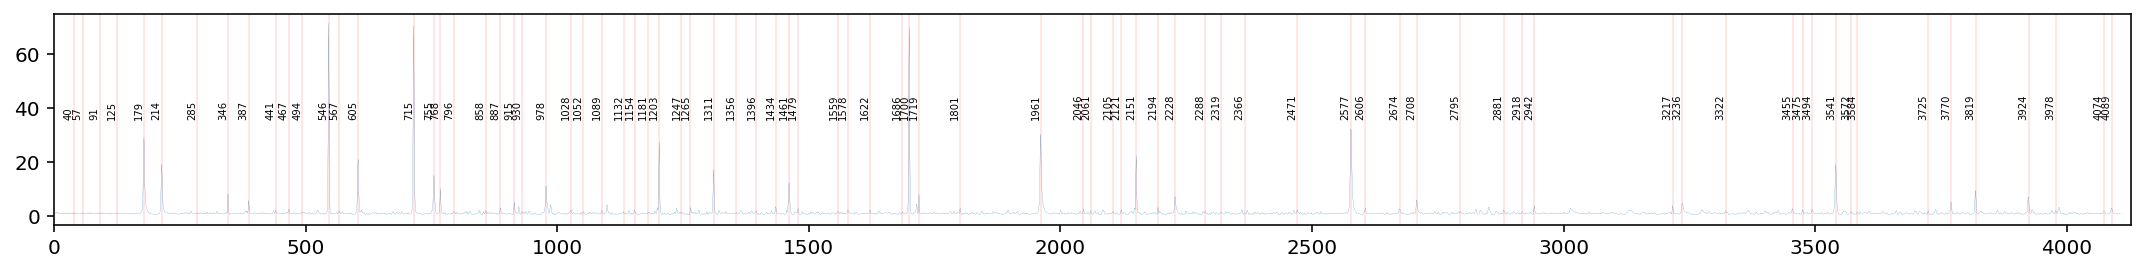

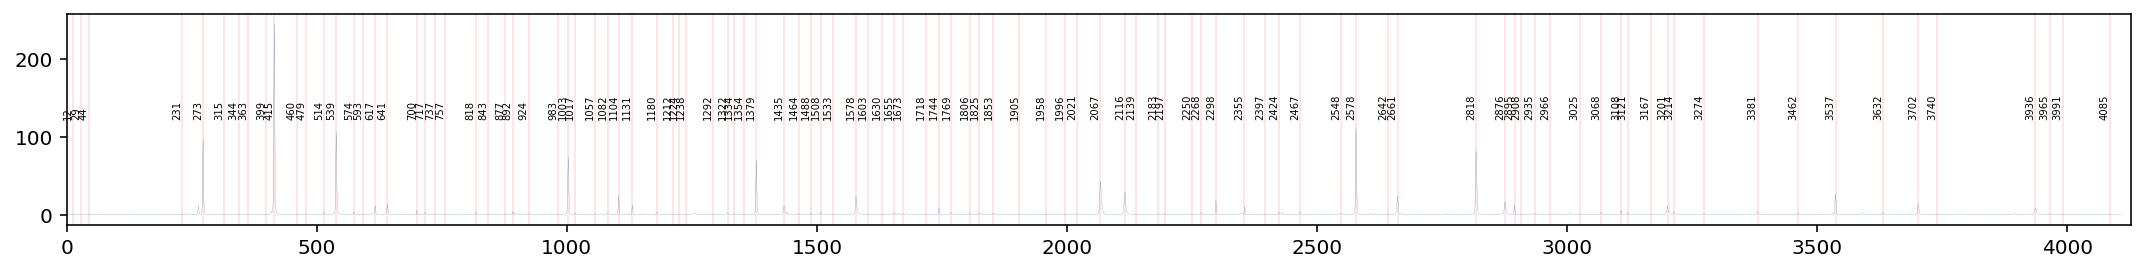

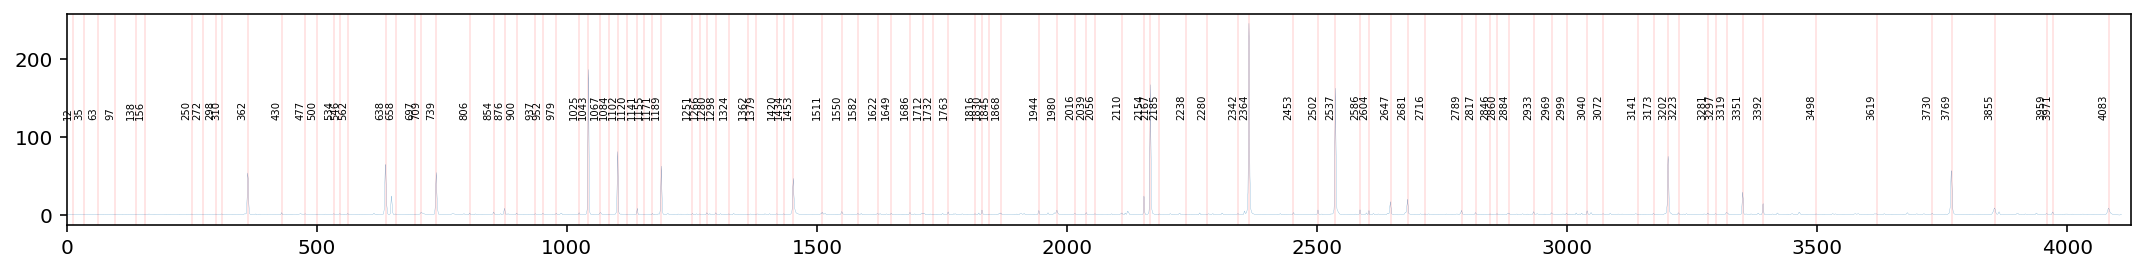

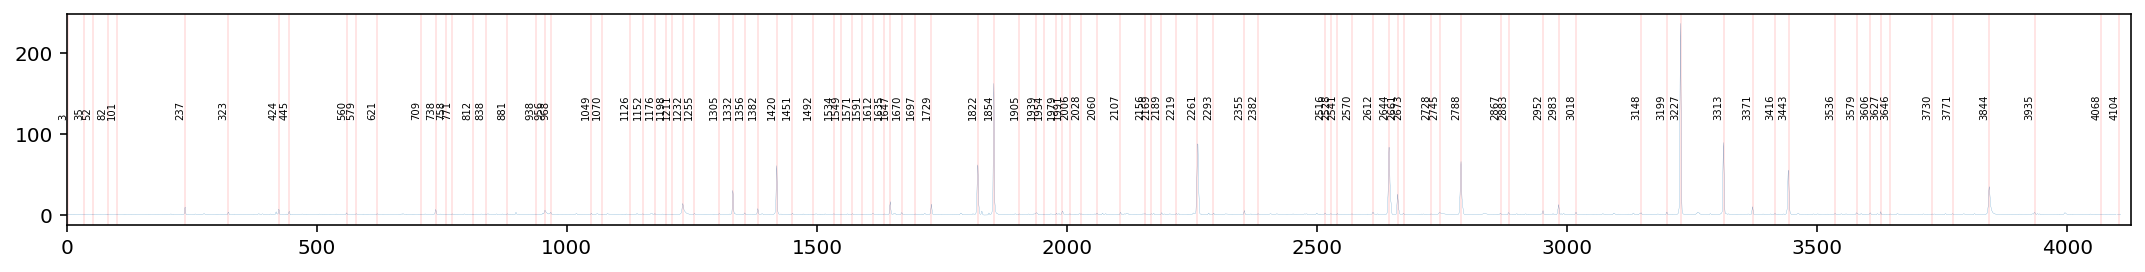

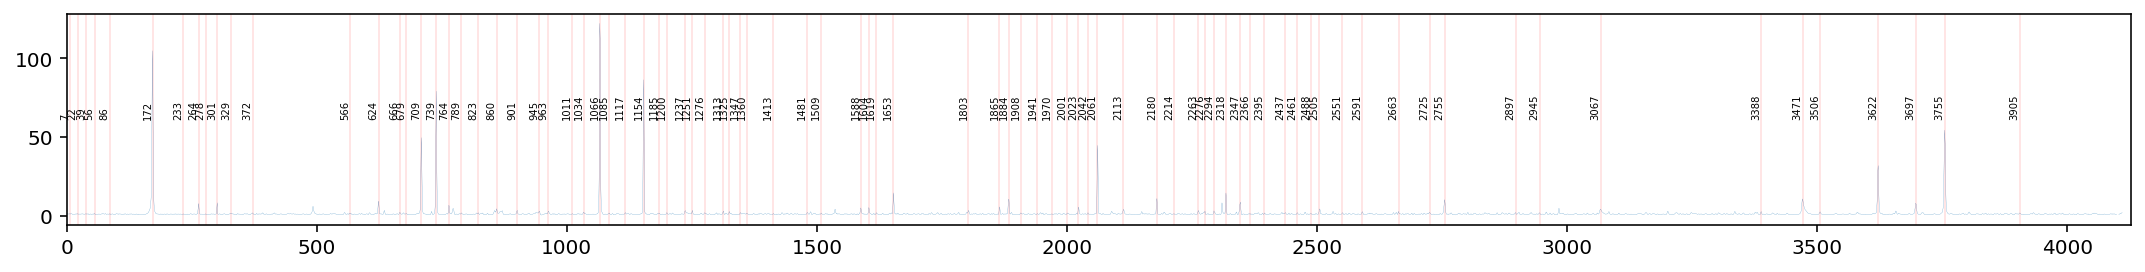

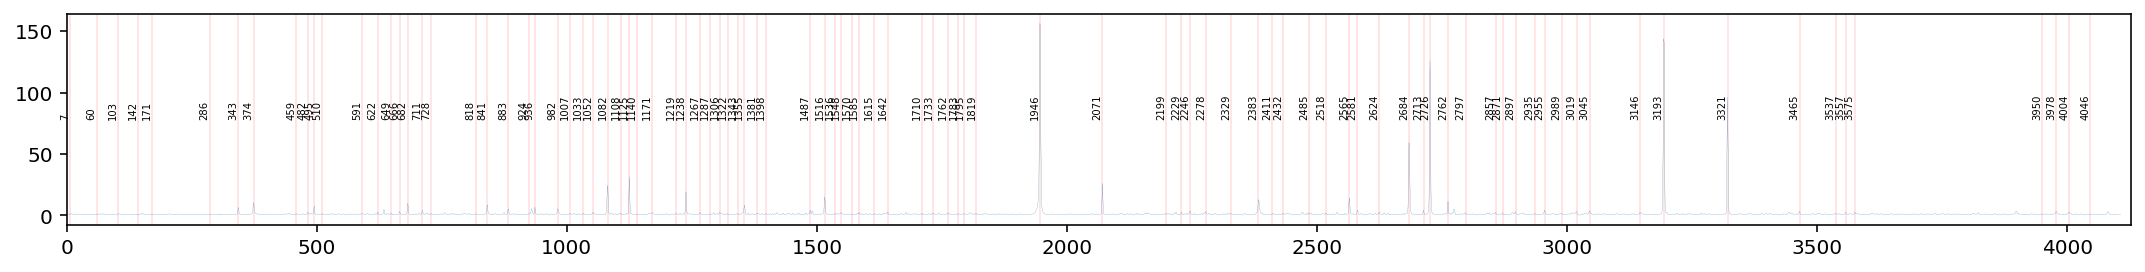

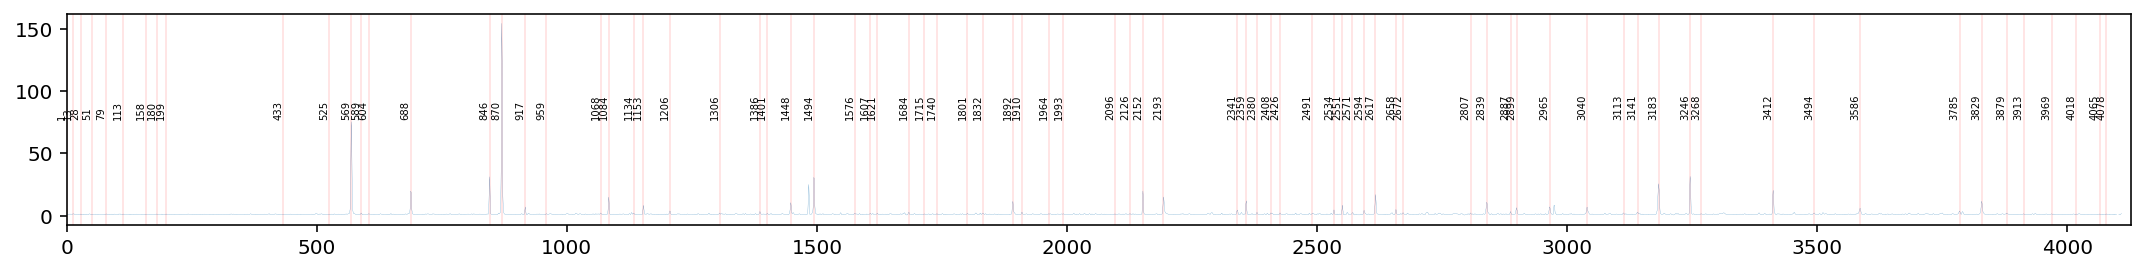

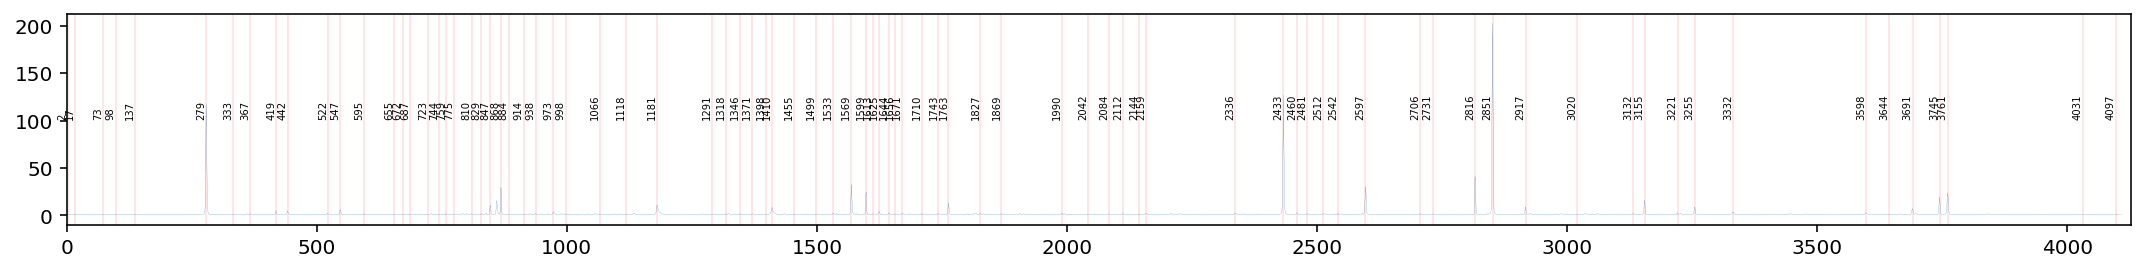

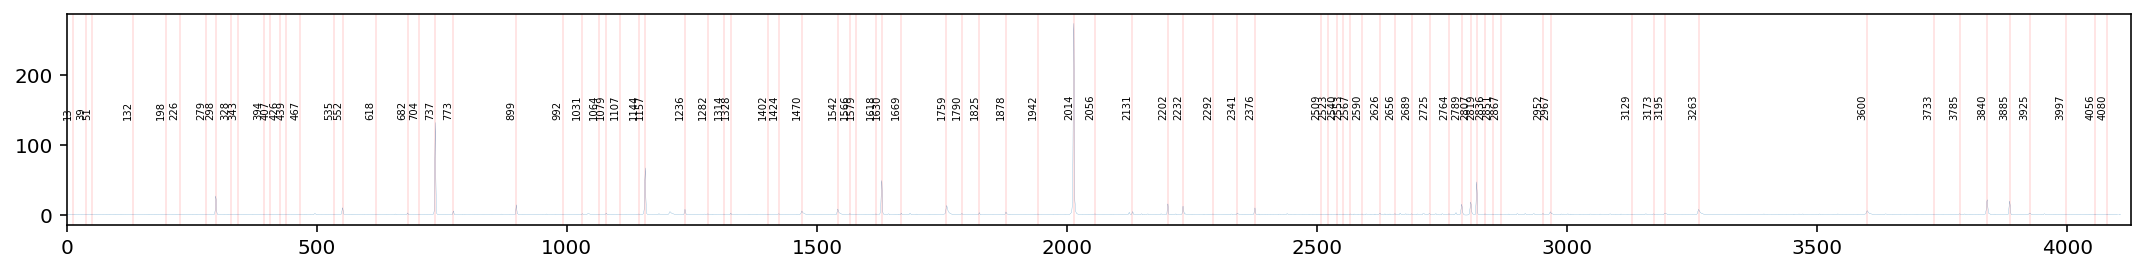

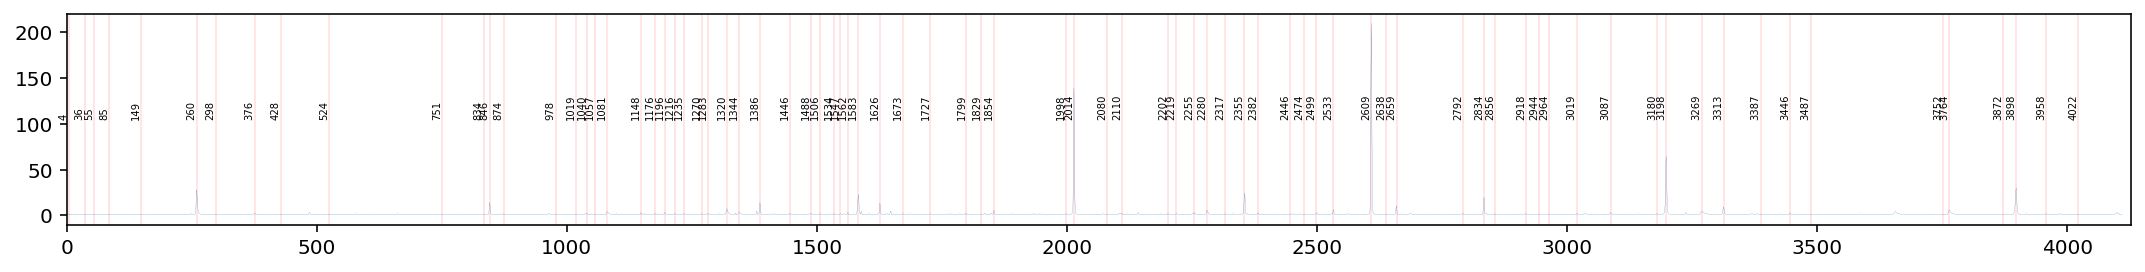

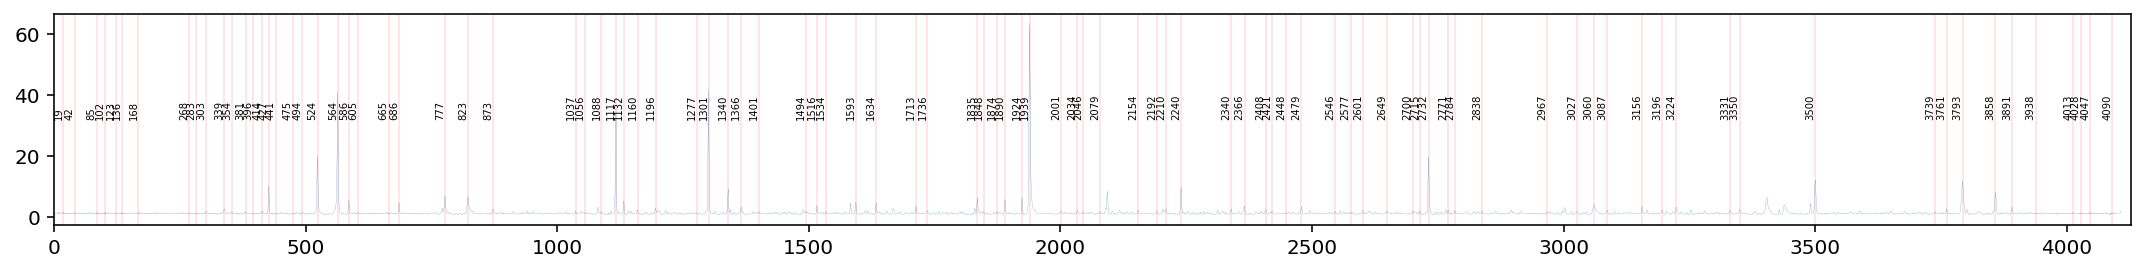

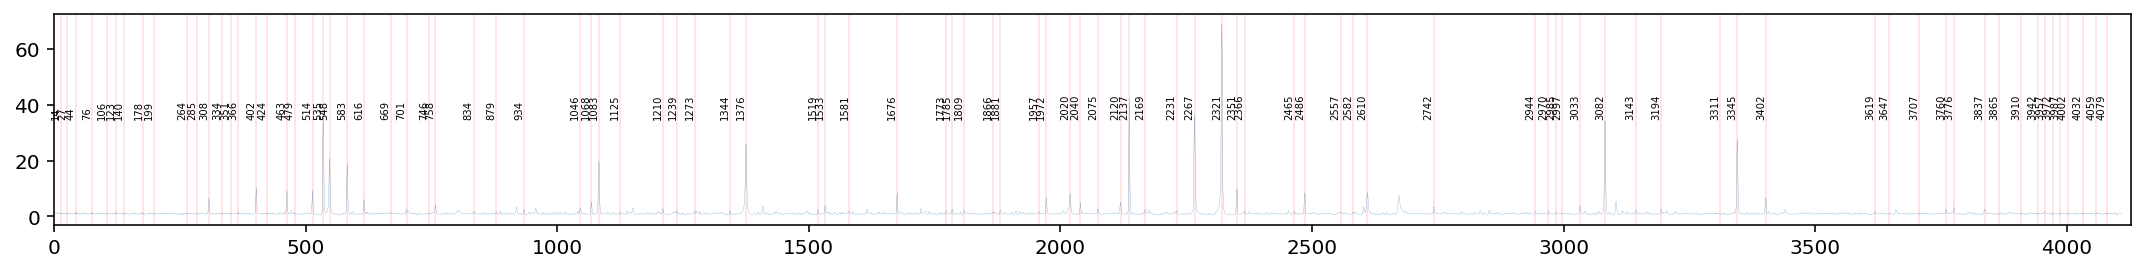

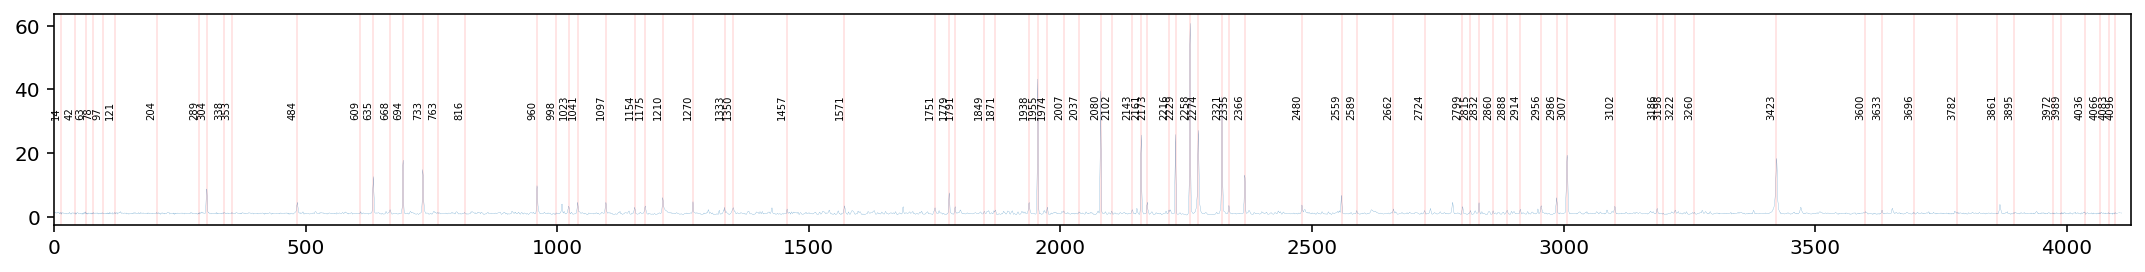

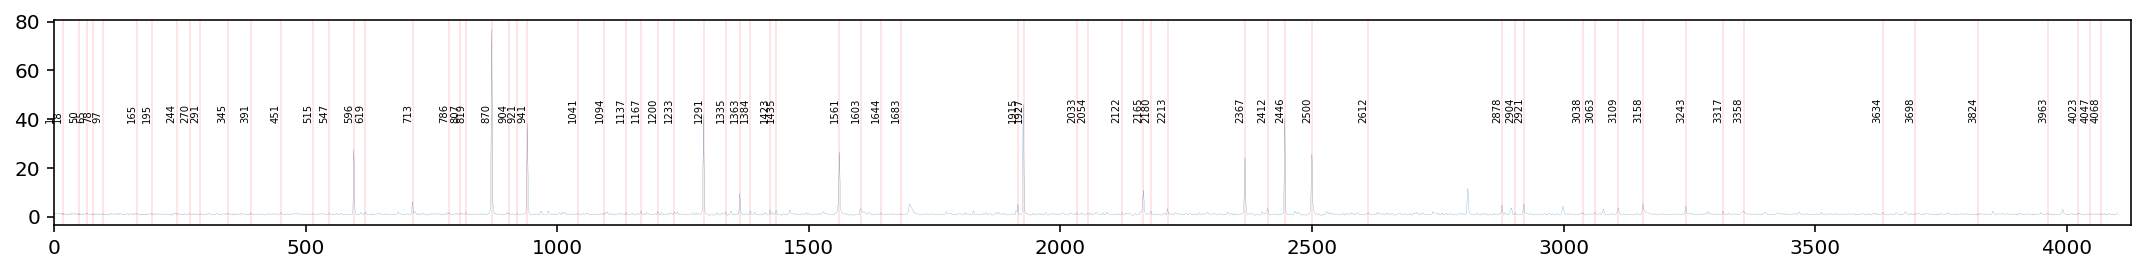

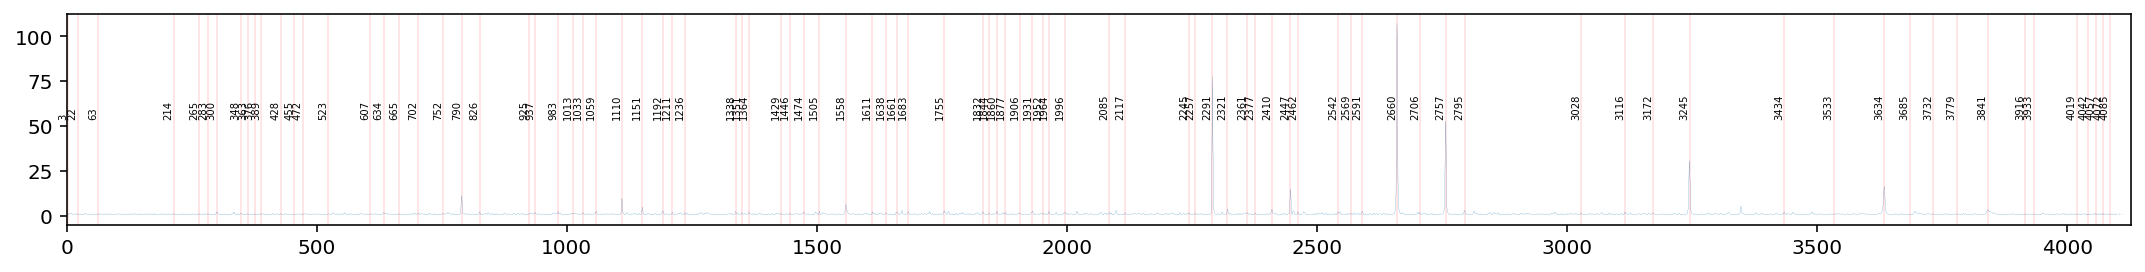

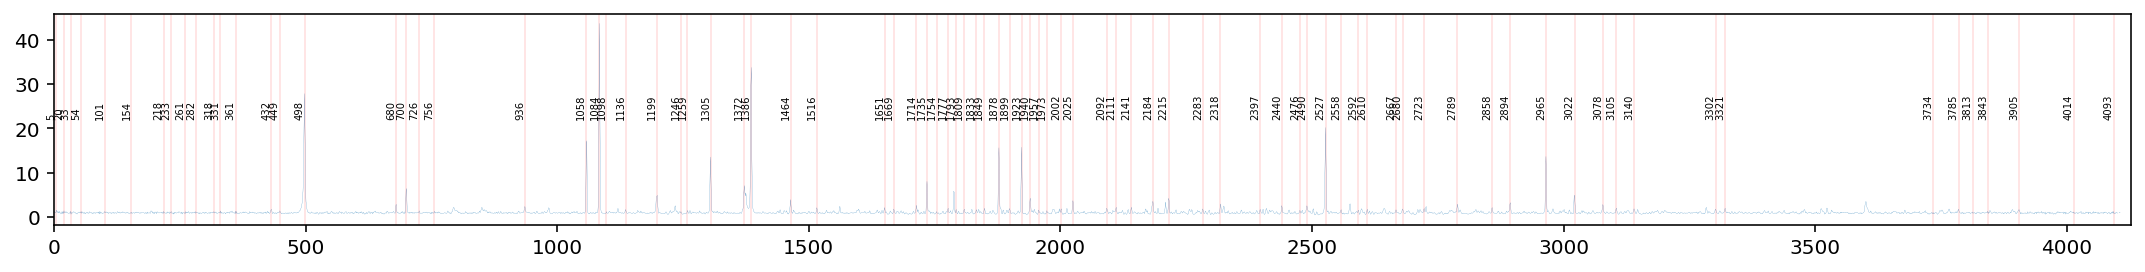

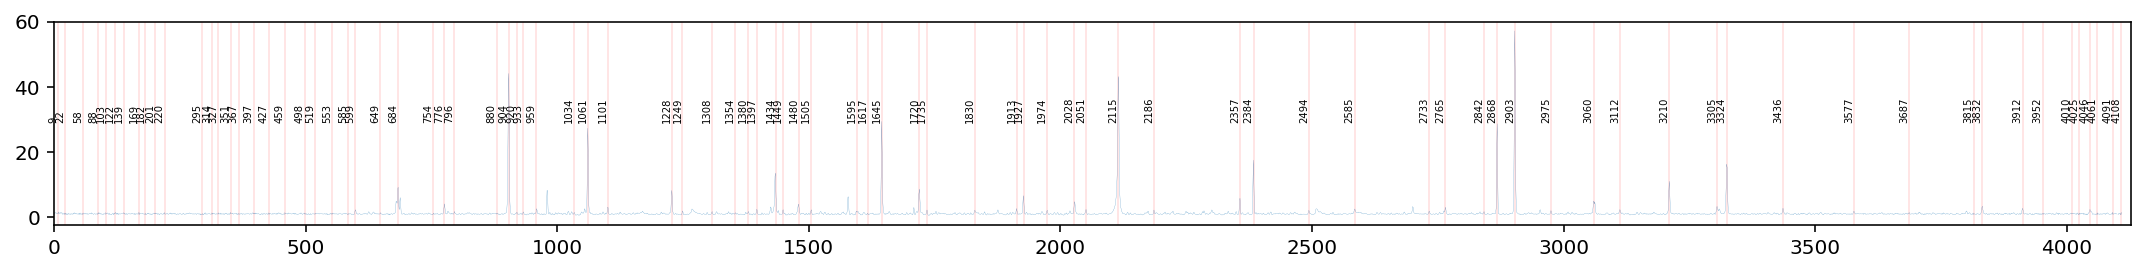

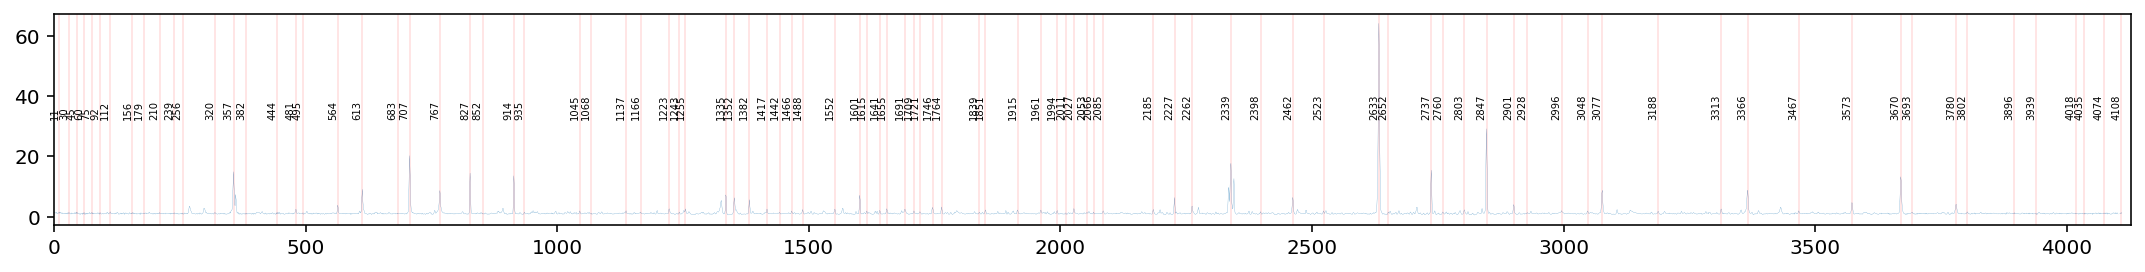

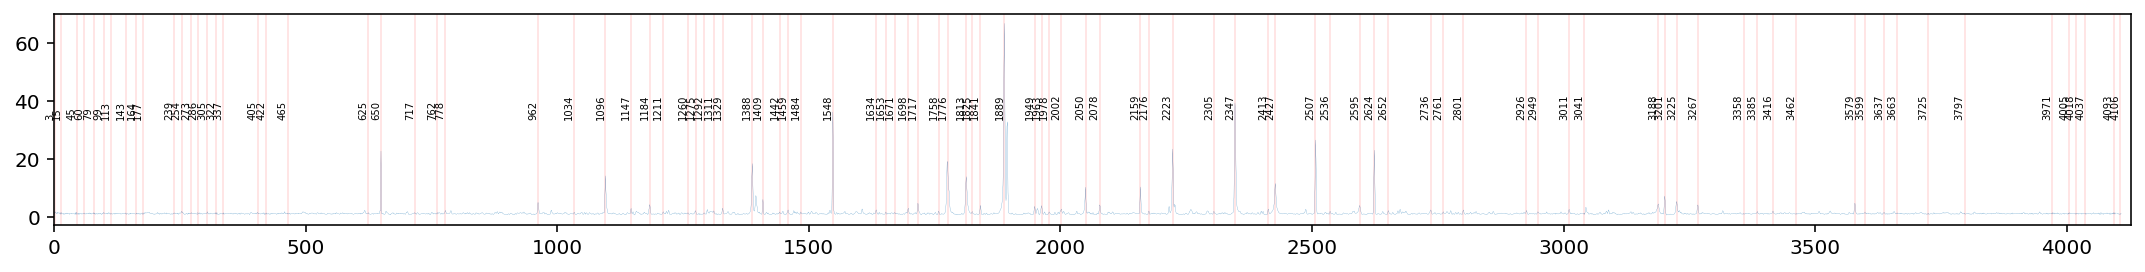

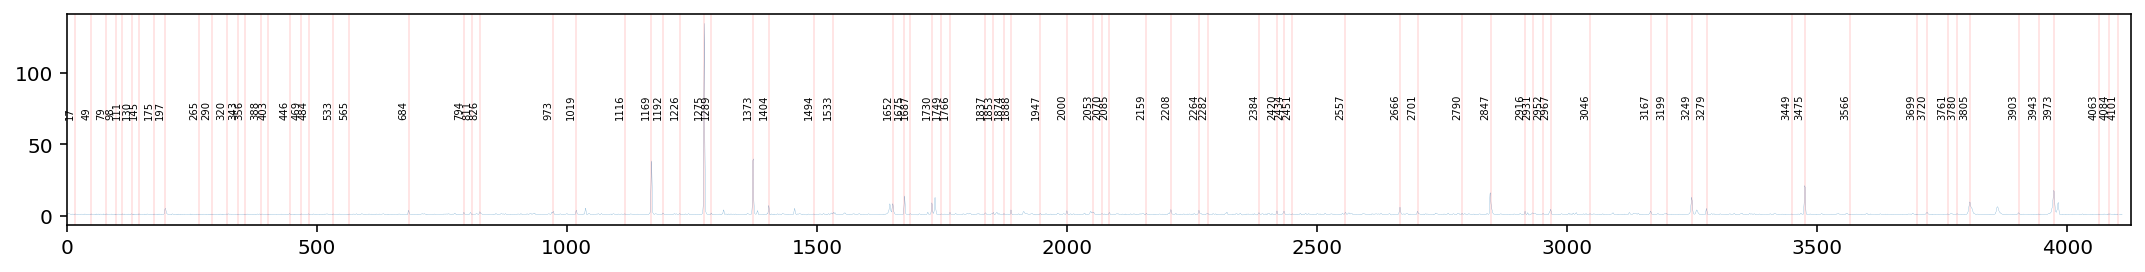

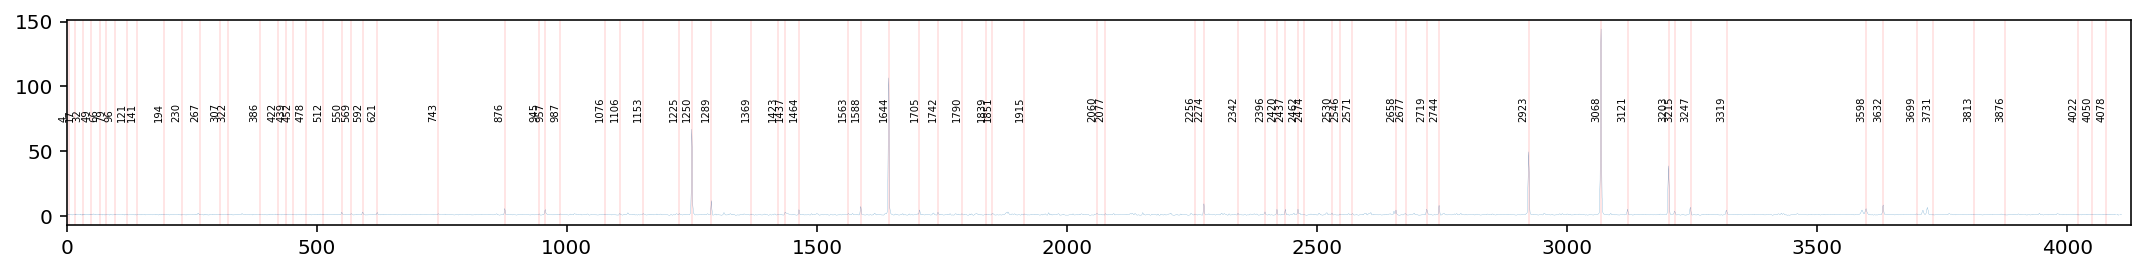

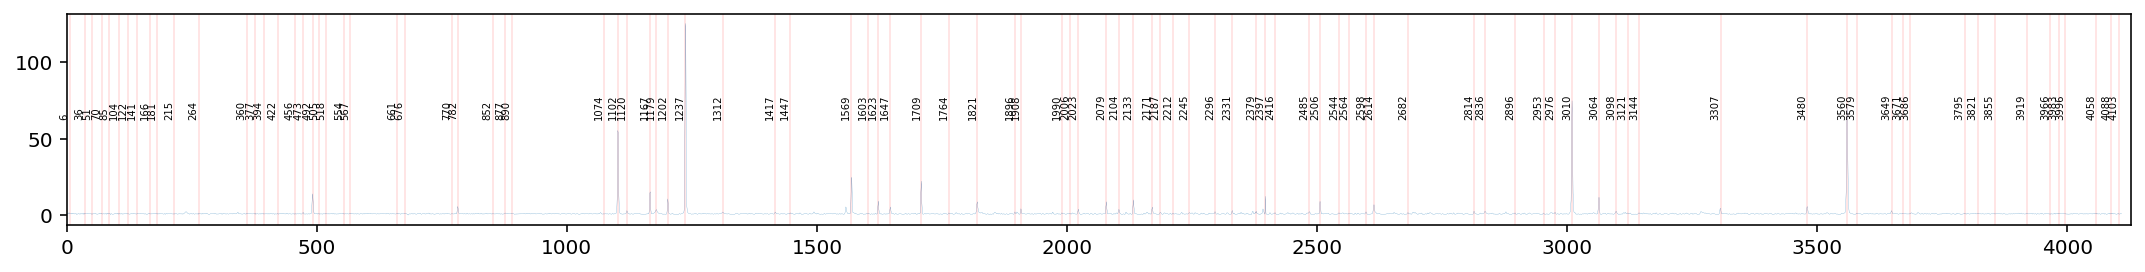

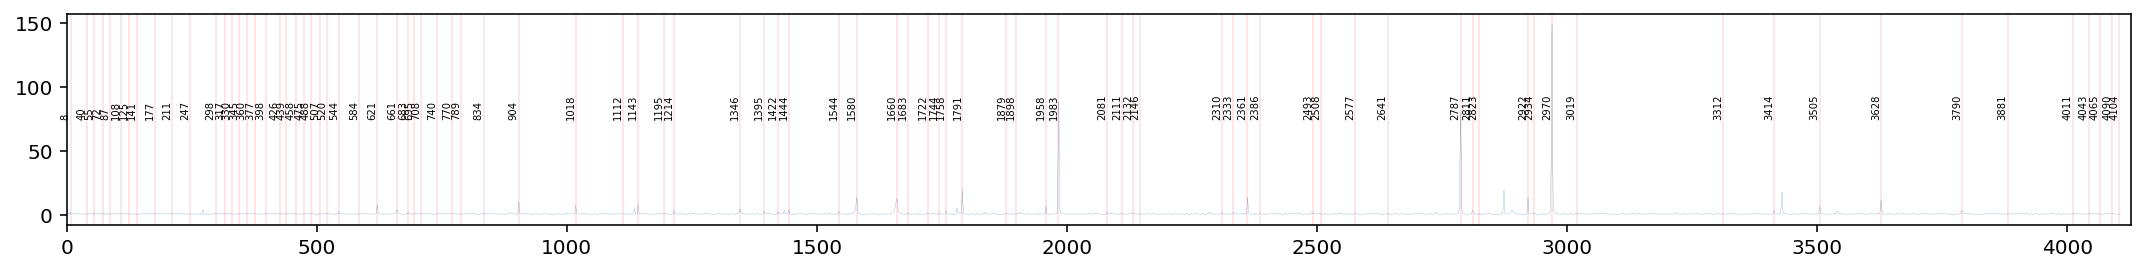

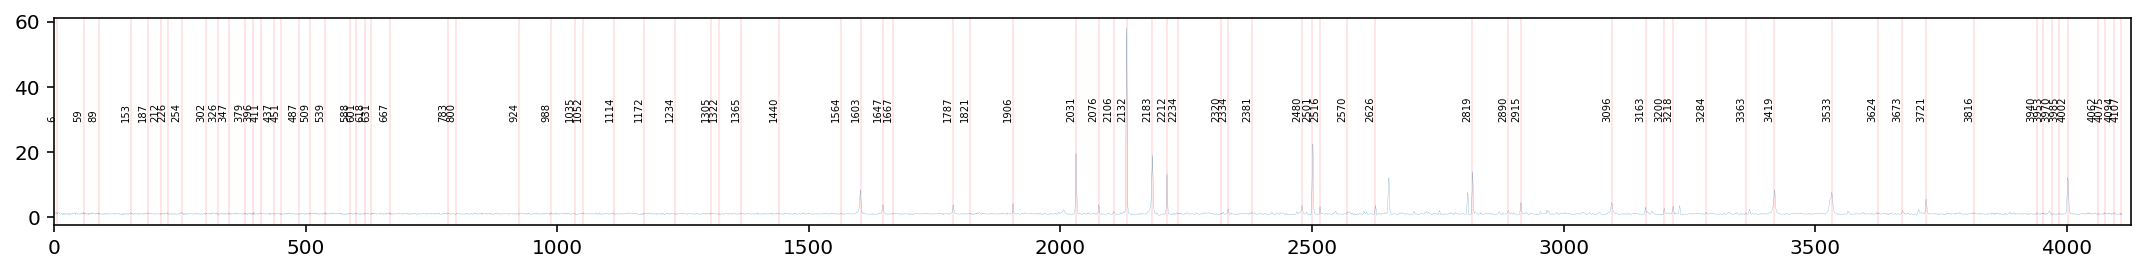

In [394]:
for order in range(1,len(file)):
    
    order_name = file[order].header['EXTNAME'].lower()
    
    thxe = file[order].data[2,:]/file[order].data[1,:]
    
    thxe_filtered = thxe/medfilt(thxe, kernel_size=51)
    peaks, properties = find_peaks(thxe_filtered, threshold=0.25, distance=12)

    f, ax = plt.subplots(panels,1,figsize=(15,2))

    pixels = np.arange(len(thxe_filtered))

    for panel in np.arange(panels):

        ax.plot(
            pixels,
            thxe_filtered,
            lw = 0.1
        )
        ylim = ax.get_ylim()
        for peak in peaks:
            ax.axvline(peak,c='r',lw=0.1)
            ax.text(peak,0.5*(ylim[0]+ylim[1]),str(peak),rotation=90,ha='right',va='bottom',fontsize=5)

        ax.set_xlim(fourth_order(0, *fourth_order_coeffs),fourth_order(4128, *fourth_order_coeffs))
    ax.set_xlim(0,4128)
    plt.tight_layout()
    plt.savefig('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name+'.pdf')
    plt.show()
    plt.close()

In [396]:
wavelength_coefficients = dict()
for order in range(1,len(file)):
    
    order_name = file[order].header['EXTNAME'].lower()
    wavelength_coefficients[order_name] = np.loadtxt('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name+'_px_wl.txt')

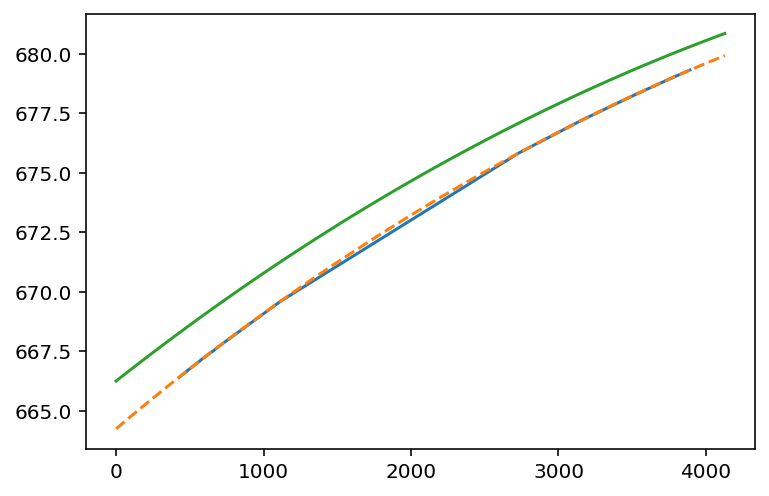

In [440]:
order_name = 'ccd_3_order_91'

wavelength_coefficients[order_name] = np.loadtxt('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name+'_px_wl.txt')

def fourth_order(xdata, *coeffs):
    c0, c1, c2, c3, c4 = coeffs
    return(c0 + c1 * (xdata-2064) + c2 * (xdata-2064)**2 + c3 * (xdata-2064)**3 + c4 * (xdata-2064)**4)

fourth_order_coeffs, x = curve_fit(fourth_order,
          wavelength_coefficients[order_name][:,0],
          wavelength_coefficients[order_name][:,1],
          p0 = [np.median(wavelength_coefficients[order_name][:,1]), 0.05, 0.0, 0.0, 0.0]
)

plt.plot(
    wavelength_coefficients[order_name][:,0],
    wavelength_coefficients[order_name][:,1]
)
plt.plot(
    np.linspace(0,4128,100),
    fourth_order(np.linspace(0,4128,100), *fourth_order_coeffs),
    ls = 'dashed'
)

adjusted_coeffs = [
    initial_wavelength_coeffs[order_name][0],
    initial_wavelength_coeffs[order_name][1],
    initial_wavelength_coeffs[order_name][2],
    initial_wavelength_coeffs[order_name][3],
    initial_wavelength_coeffs[order_name][4]
]

plt.plot(
    np.linspace(0,4128,100),
    fourth_order(np.linspace(0,4128,100), *adjusted_coeffs)
)

4128


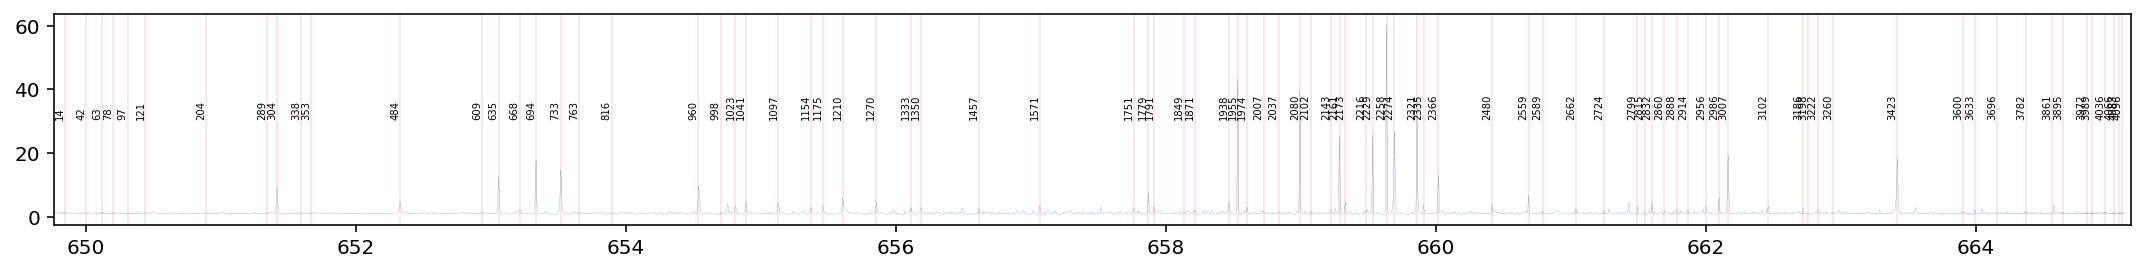

In [357]:
# plot

thxe_filtered = thxe/medfilt(thxe, kernel_size=51)
peaks, properties = find_peaks(thxe_filtered, threshold=0.25, distance=12)


panels = 1

f, gs = plt.subplots(panels,1,figsize=(15,2))
ax = gs

pixels = np.arange(len(lc))
print(len(pixels))

for panel in np.arange(panels):

    ax.plot(
        fourth_order(pixels, *fourth_order_coeffs),
        thxe_filtered,
        lw = 0.1
    )
    ylim = ax.get_ylim()
    for peak in peaks:
        ax.axvline(fourth_order(peak, *fourth_order_coeffs),c='r',lw=0.1)
        ax.text(fourth_order(peak, *fourth_order_coeffs),0.5*(ylim[0]+ylim[1]),str(peak),rotation=90,ha='right',va='bottom',fontsize=5)
    
    ax.set_xlim(fourth_order(0, *fourth_order_coeffs),fourth_order(4128, *fourth_order_coeffs))
#     ax.set_xticks(fourth_order(0, *fourth_order_coeffs),fourth_order(4128, *fourth_order_coeffs))
    
#     ax.set_xticks(np.arange(0,4128,50),labels=np.arange(0,4128,50),rotation=90)
#     ticks = ax.get_xticks()
#     ax.set_xlim(ticks[0],ticks[-1])   
#     ax2 = ax.twiny()
#     ax2.set_xticks(ticks-ticks[0])
#     ax2.set_xticklabels(np.round(10. * polynomial_function(ticks-2064,*initial_wavelength_coeffs[order]),1))

# ax.set_xlim(0,4128)
plt.tight_layout()
plt.savefig('../veloce_luminosa_reduction/fixed_arc_positions/ccd_3_order_93.pdf')

4128


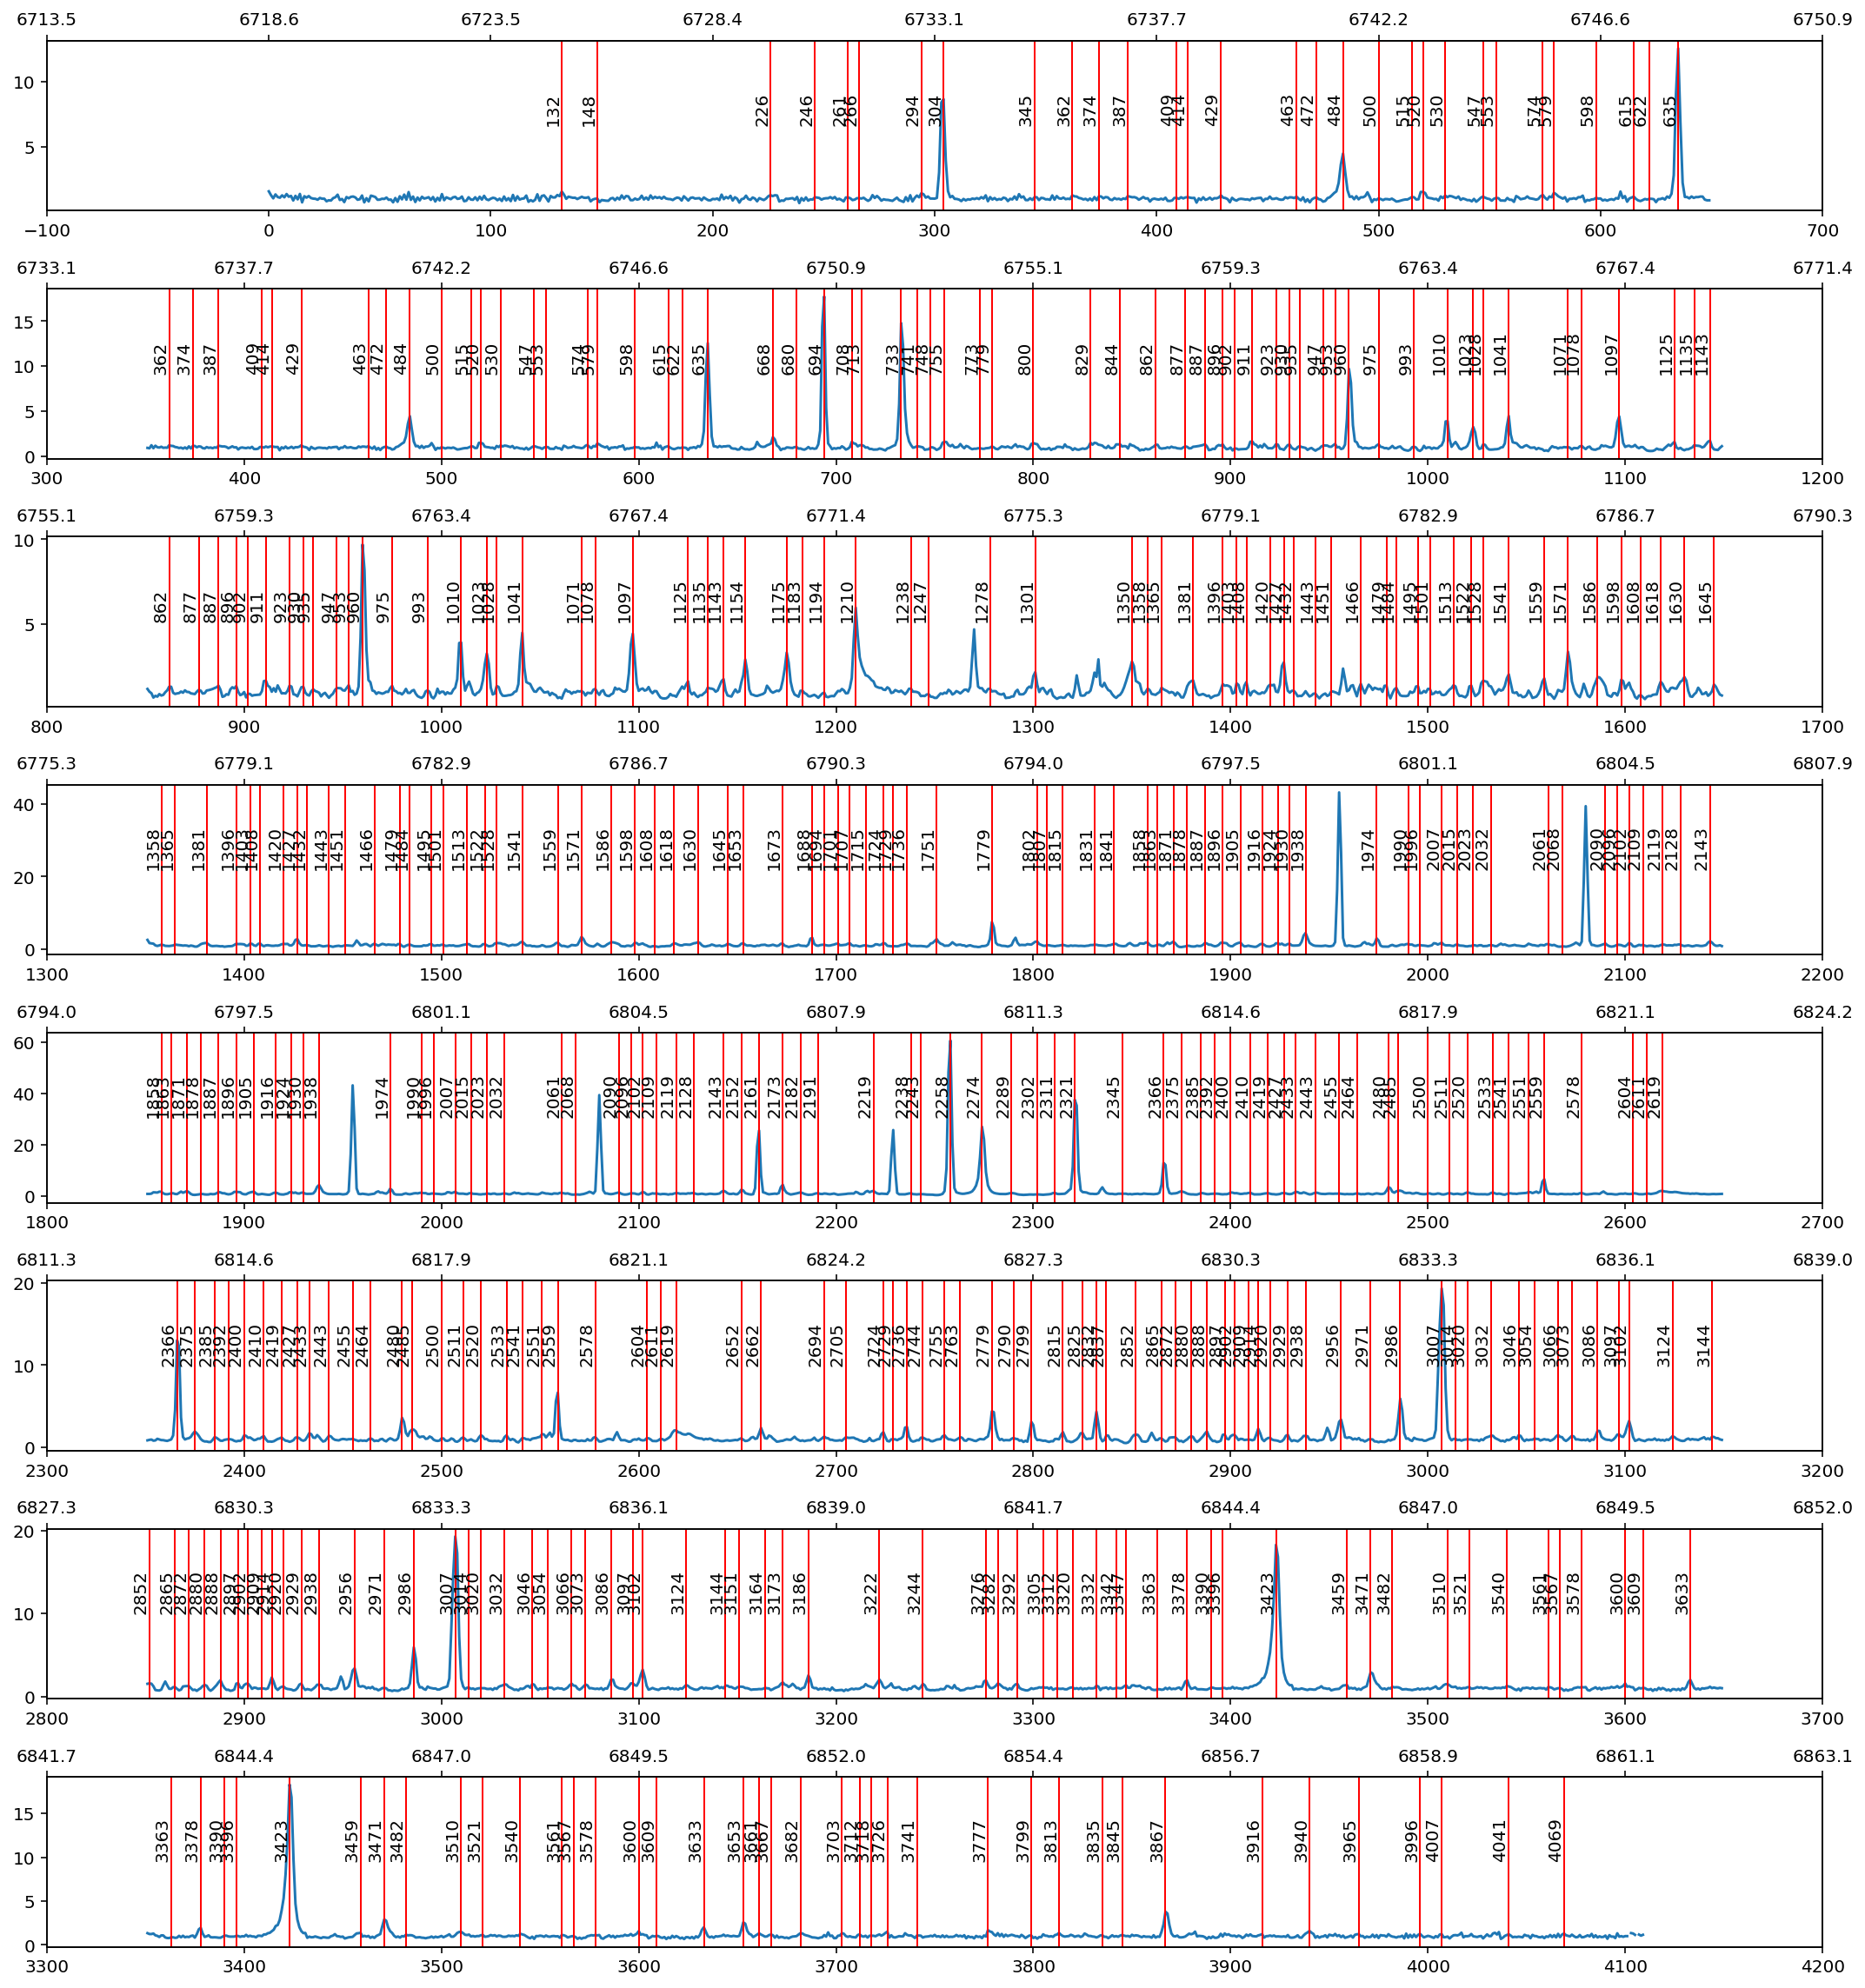

In [242]:
# plot

thxe_filtered = thxe/medfilt(thxe, kernel_size=51)
peaks, properties = find_peaks(thxe_filtered, distance = 5, rel_height=0.1, width=0.5)


panels = 8

f, gs = plt.subplots(panels,1,figsize=(15,panels*2))
gs = gs.flatten()

pixels = np.arange(len(lc))
print(len(pixels))

for panel in np.arange(panels):

    ax = gs[panel]
    in_panel = (pixels > panel * 500 - 150) & (pixels < (panel + 1) * 500 + 150)
    peaks_in_panel = (peaks > panel * 500 - 150) & (peaks < (panel + 1) * 500 + 150)
    
    ax.plot(
        pixels[in_panel],
        thxe_filtered[in_panel]
    )
    ylim = ax.get_ylim()
    for peak in peaks[peaks_in_panel]:
        ax.axvline(peak,c='r',lw=1)
        ax.text(peak,0.5*(ylim[0]+ylim[1]),str(peak),rotation=90,ha='right',va='bottom')
    
    ticks = ax.get_xticks()
    ax.set_xlim(ticks[0],ticks[-1])   
    ax2 = ax.twiny()
    ax2.set_xticks(ticks-ticks[0])
    ax2.set_xticklabels(np.round(10. * polynomial_function(ticks-2064,*initial_wavelength_coeffs[order]),1))

plt.tight_layout()

4128


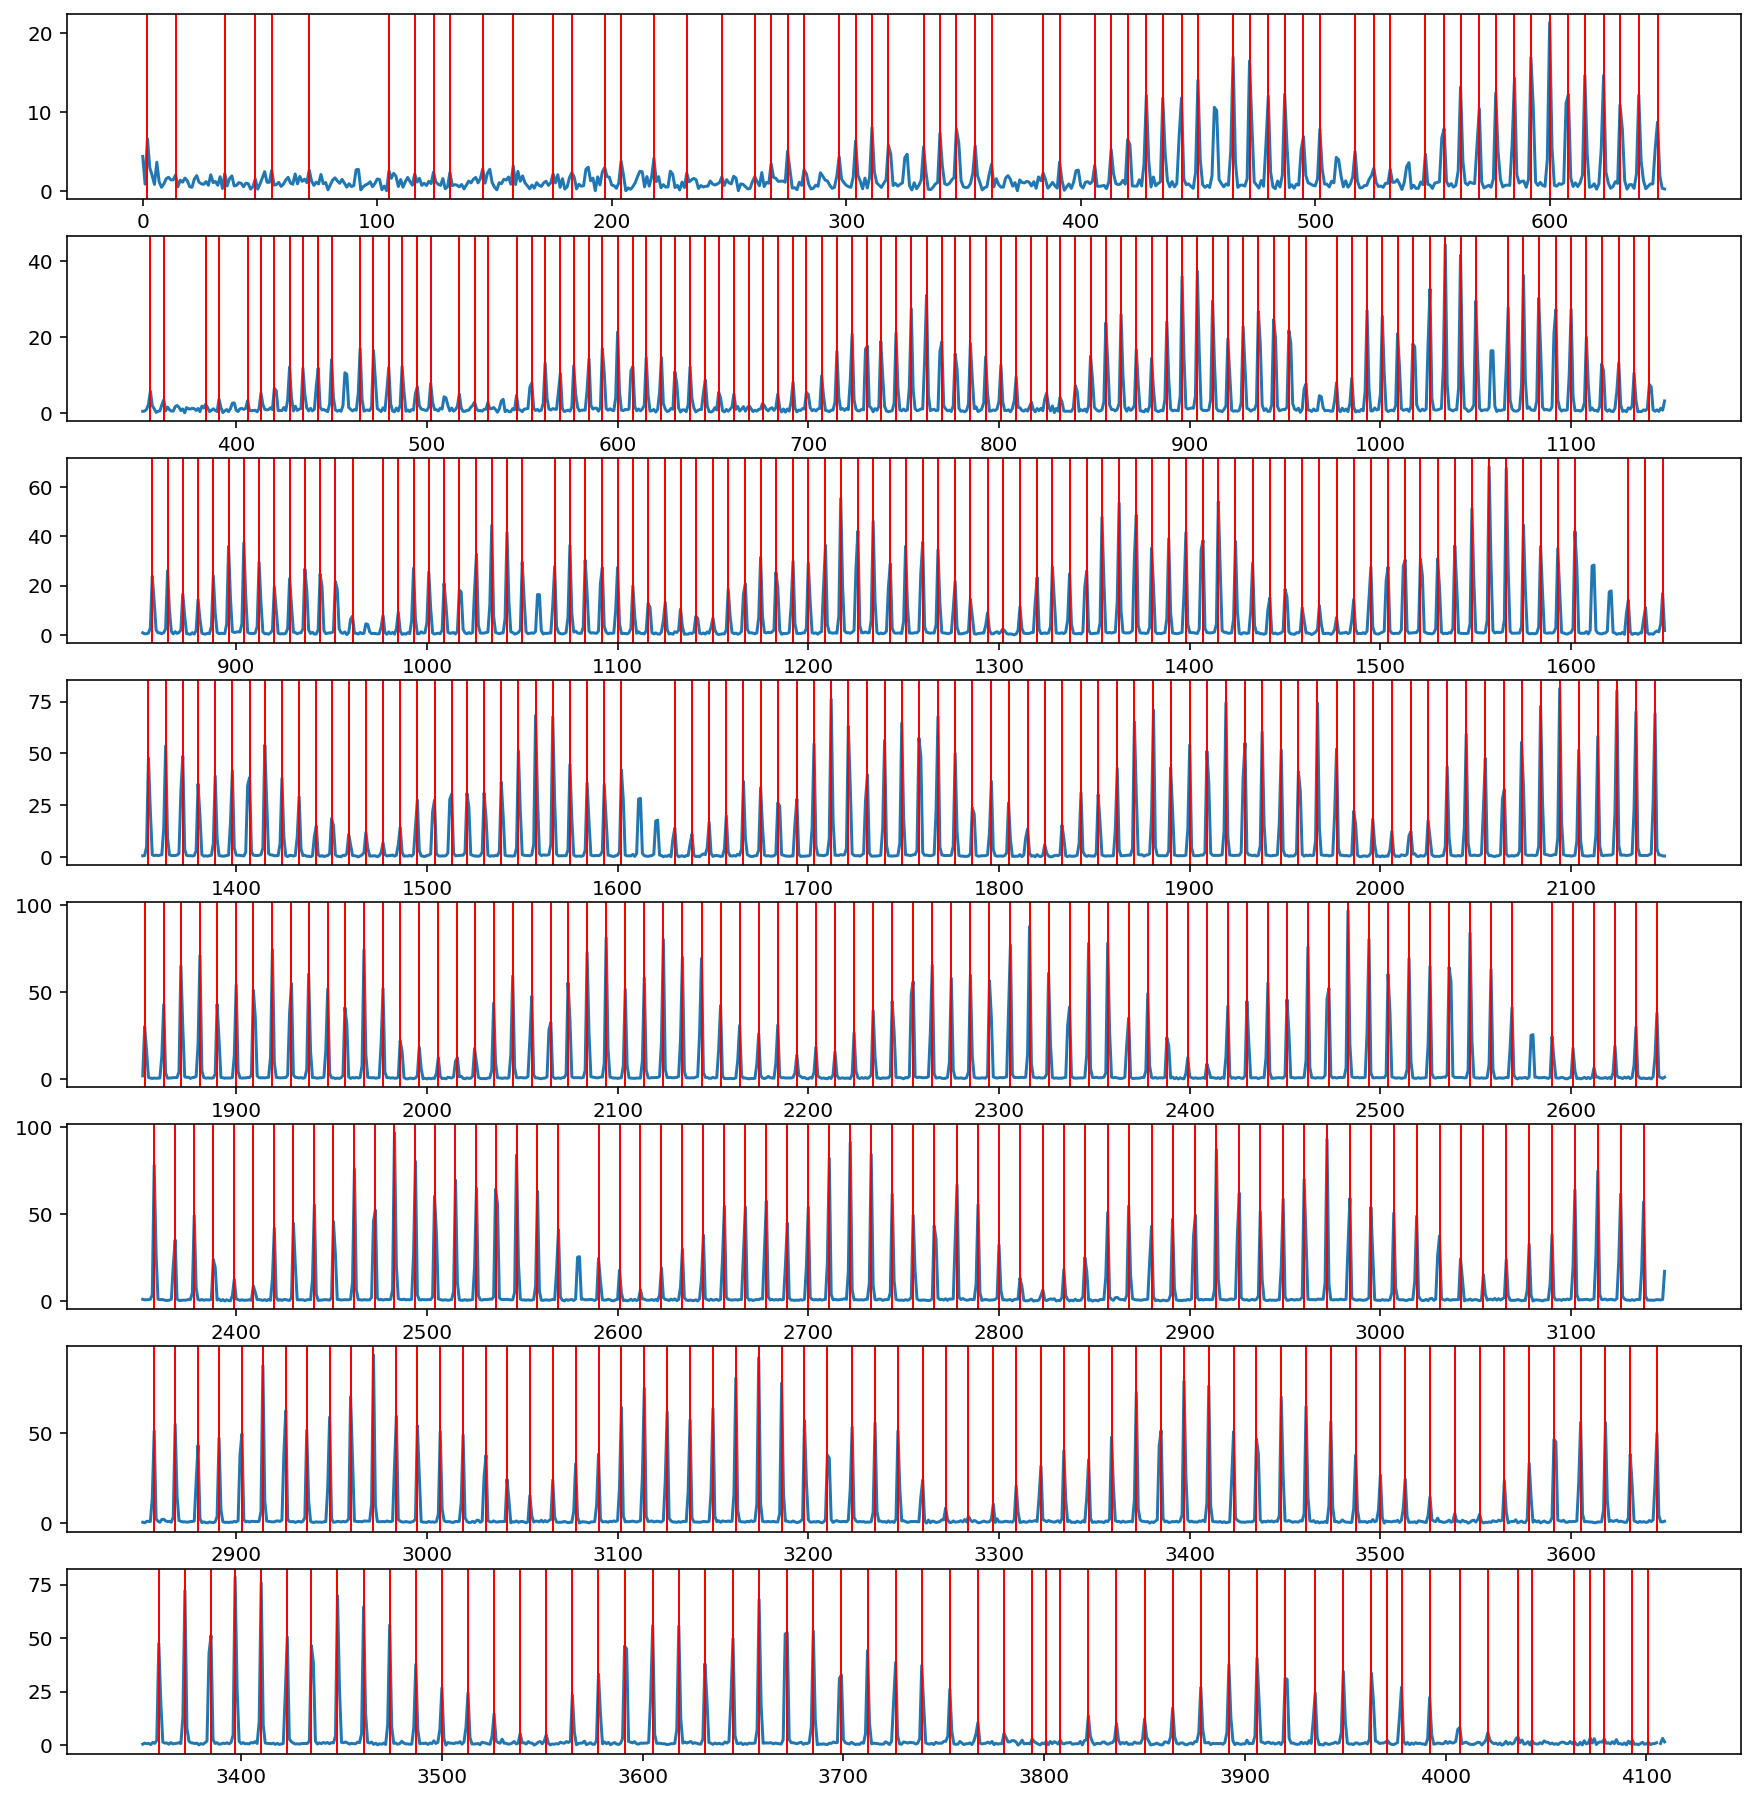

In [164]:
lc_filtered = lc/medfilt(lc, kernel_size=51)

peaks, properties = find_peaks(lc_filtered, distance = 7, threshold=0.5, prominence=0.1, width=1)

panels = 8

f, gs = plt.subplots(panels,1,figsize=(15,panels*2))
gs = gs.flatten()

pixels = np.arange(len(lc))
print(len(pixels))

for panel in np.arange(panels):

    ax = gs[panel]
    in_panel = (pixels > panel * 500 - 150) & (pixels < (panel + 1) * 500 + 150)
    peaks_in_panel = (peaks > panel * 500 - 150) & (peaks < (panel + 1) * 500 + 150)
    
    ax.plot(
        pixels[in_panel],
        lc_filtered[in_panel]
    )
    for peak in peaks[peaks_in_panel]:
        ax.axvline(peak,c='r',lw=1)
    


4128


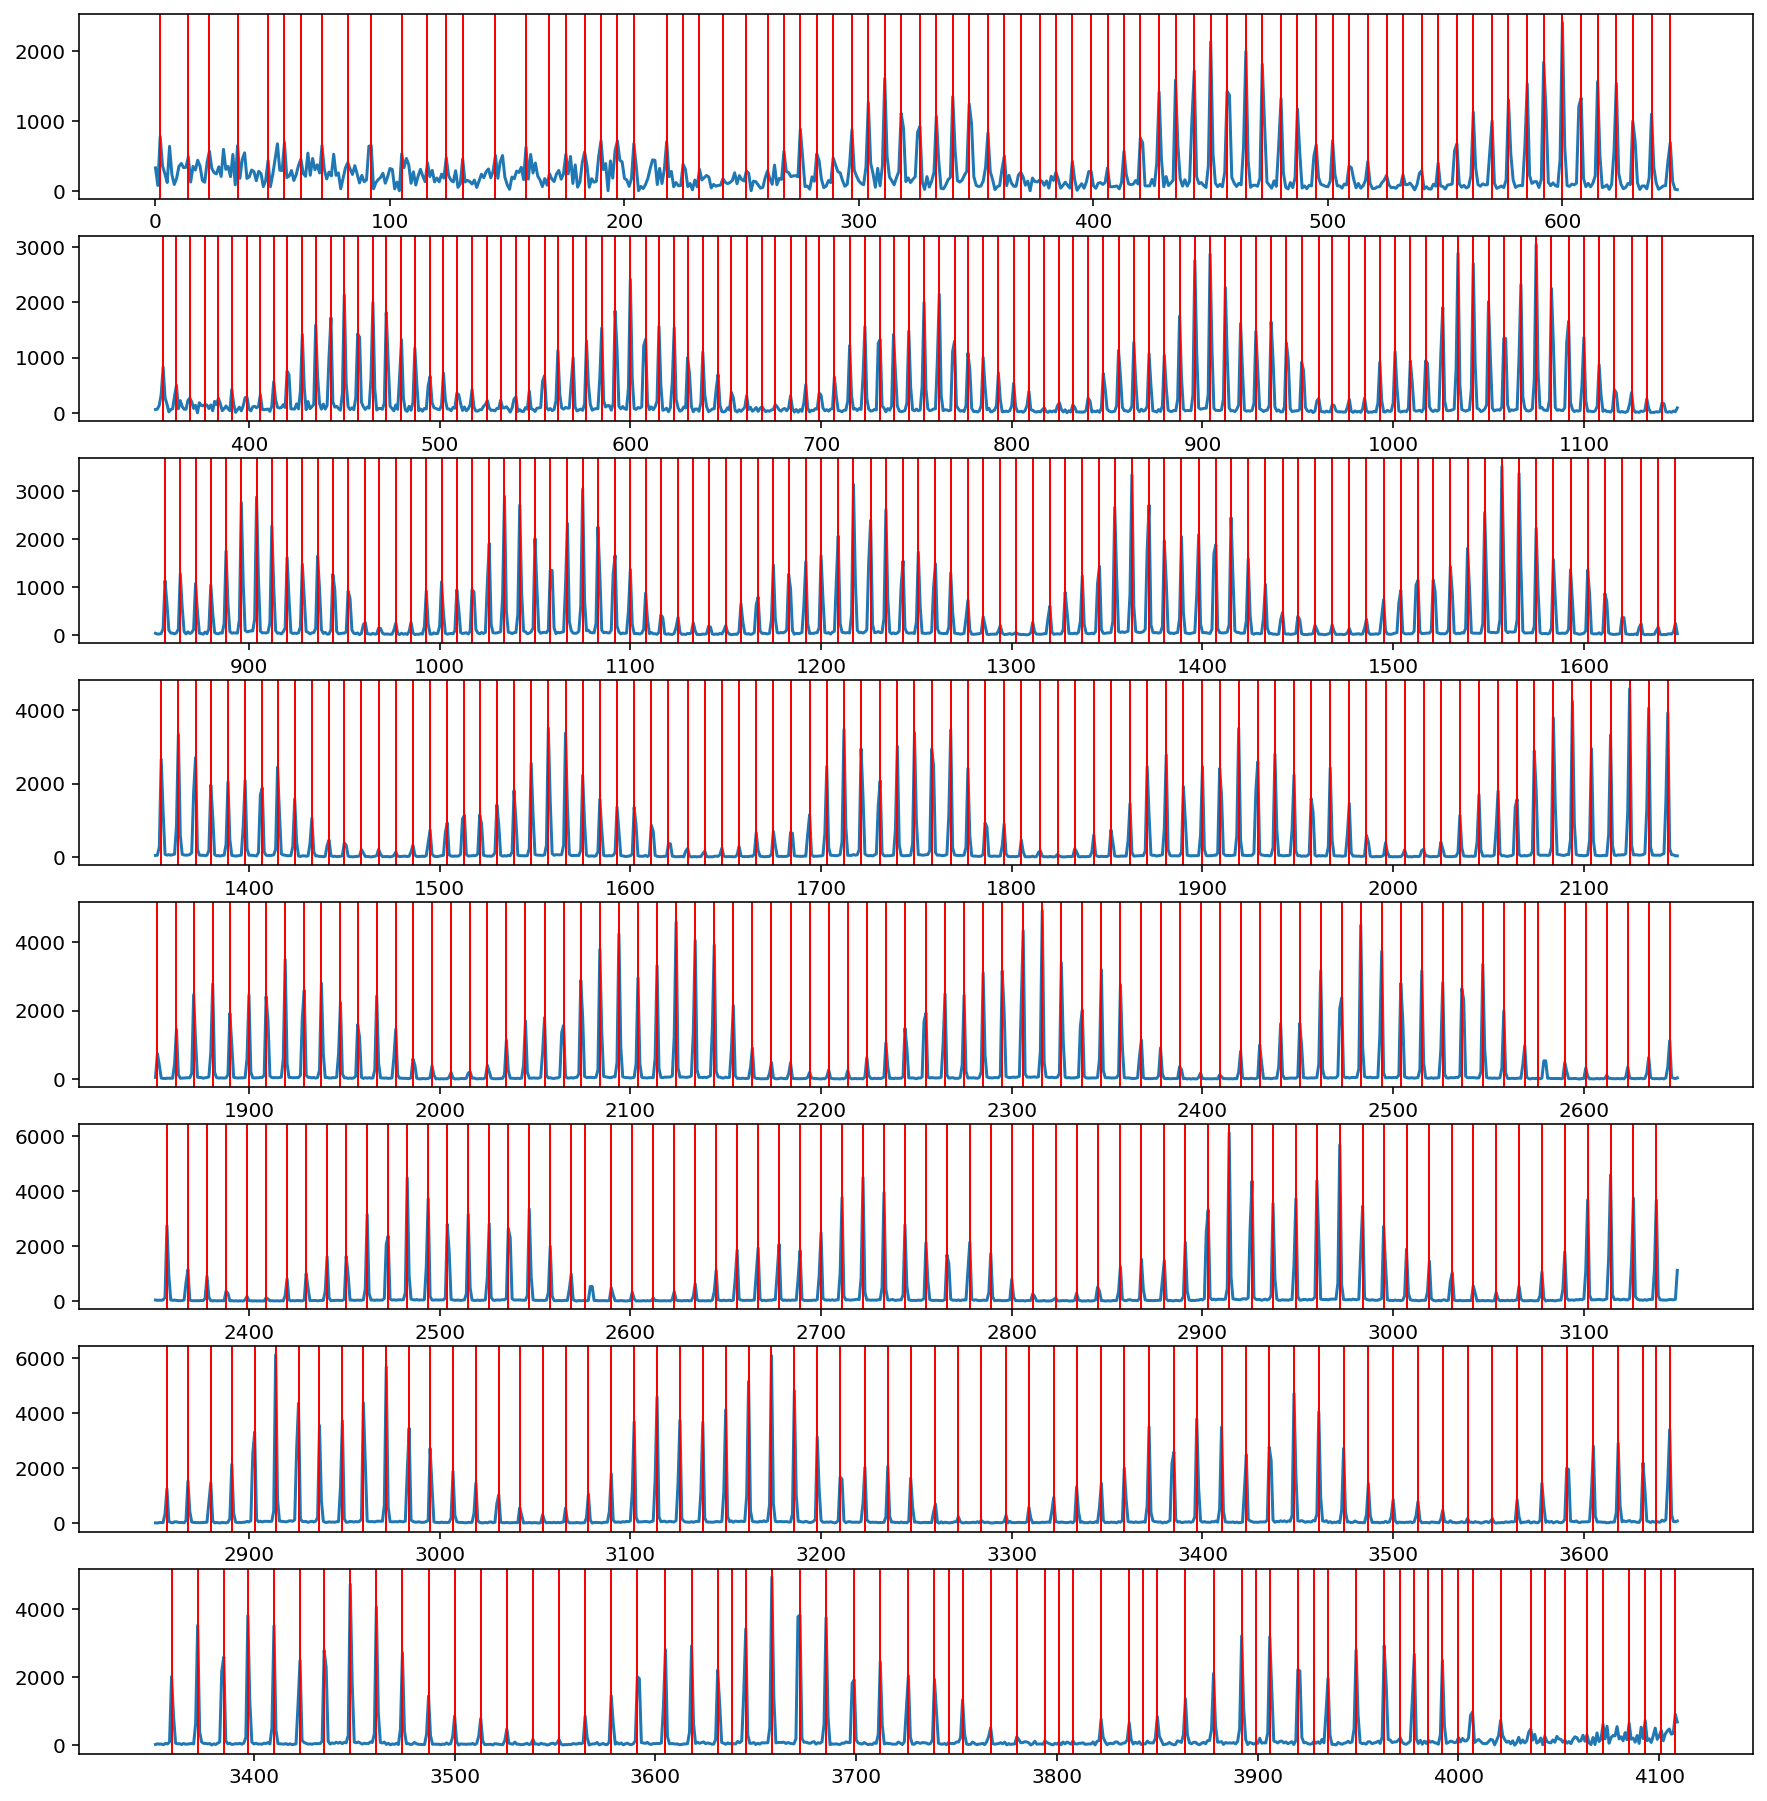

In [132]:
peaks, properties = find_peaks(lc, distance = 7, threshold=1, prominence=0.2)

panels = 8

f, gs = plt.subplots(panels,1,figsize=(15,panels*2))
gs = gs.flatten()

pixels = np.arange(len(lc))
print(len(pixels))

for panel in np.arange(panels):

    ax = gs[panel]
    in_panel = (pixels > panel * 500 - 150) & (pixels < (panel + 1) * 500 + 150)
    peaks_in_panel = (peaks > panel * 500 - 150) & (peaks < (panel + 1) * 500 + 150)
    
    ax.plot(
        pixels[in_panel],
        lc[in_panel]
    )
    for peak in peaks[peaks_in_panel]:
        ax.axvline(peak,c='r',lw=1)
    


In [145]:
def lc_wavelength(n, fr = 25.00000000e9, f0 = 9.56000000000e9):
    frequency = fr * n + f0
    return(299792458 / frequency * 10**10)

lc_wavelength(np.arange(17700,18000))

array([6774.82443543, 6774.44170688, 6774.05902157, 6773.67637949,
       6773.29378064, 6772.91122501, 6772.52871258, 6772.14624337,
       6771.76381734, 6771.38143451, 6770.99909486, 6770.61679838,
       6770.23454507, 6769.85233492, 6769.47016792, 6769.08804407,
       6768.70596336, 6768.32392577, 6767.94193131, 6767.55997997,
       6767.17807173, 6766.7962066 , 6766.41438456, 6766.0326056 ,
       6765.65086973, 6765.26917693, 6764.88752719, 6764.50592051,
       6764.12435688, 6763.7428363 , 6763.36135875, 6762.97992423,
       6762.59853273, 6762.21718424, 6761.83587876, 6761.45461628,
       6761.07339679, 6760.69222029, 6760.31108677, 6759.92999621,
       6759.54894862, 6759.16794398, 6758.78698229, 6758.40606355,
       6758.02518773, 6757.64435485, 6757.26356488, 6756.88281783,
       6756.50211368, 6756.12145243, 6755.74083407, 6755.36025859,
       6754.97972599, 6754.59923626, 6754.21878938, 6753.83838537,
       6753.4580242 , 6753.07770587, 6752.69743037, 6752.31719

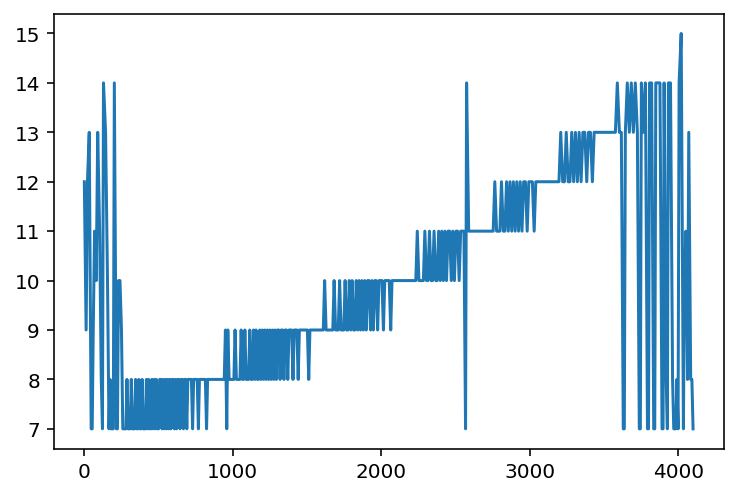

In [133]:
plt.plot(
    peaks[:-1],
    np.diff(peaks)
)